In [1]:
import time
begin=time.time()

In [2]:
prefix = 'bdb_model_passes_final-space-test'
offense = 'MIA'
defense = 'CLE'

In [ ]:
import os
import numpy as np # linear algebra
from numpy.matlib import repmat
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from fuzzywuzzy import fuzz
import datetime
import sklearn

#for image generation
from scipy import stats
from scipy.special import expit
import matplotlib.image as mpimg

import time
from tqdm import tqdm_notebook

import pickle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as kb
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Activation, 
    BatchNormalization, 
    Concatenate,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPooling2D
)

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import to_categorical

import h5py
import bdb_gameplan_space as bdb
from matplotlib.colors import ListedColormap

In [4]:
def ensure_folder_exists(folder):    
    # Check if the folder exists
    if not os.path.exists(folder):
        print(f"Folder '{folder}' does not exist. Creating it.")
        os.makedirs(folder)
    else:
        print(f"Folder '{folder}' already exists.")

In [5]:
prefix_files = os.path.join(prefix, 'files')
prefix_cnn = os.path.join(prefix, 'cnn')
prefix_list = [prefix, prefix_files, prefix_cnn]
for i in prefix_list:
    ensure_folder_exists(i)

Folder 'bdb_model_passes_final-space-test' already exists.
Folder 'bdb_model_passes_final-space-test\files' already exists.
Folder 'bdb_model_passes_final-space-test\cnn' already exists.


In [33]:
#Motion fixed

play_stats = pd.read_csv("nfl-big-data-bowl-2025//plays.csv")
play_stats = play_stats[['gameId', 'playId', 'yardlineSide', 'yardlineNumber', 'quarter', 'gameClock', 'possessionTeam', 'down', 'yardsToGo', 
                         'preSnapHomeScore', 'preSnapVisitorScore', 'yardsGained', 'expectedPointsAdded',  'offenseFormation', 'playDescription', 'dropbackType', 'playAction']]
play_stats = play_stats.rename(columns = {'gameId': 'GameId', 'playId': 'PlayId', 'yardlineSide': 'FieldPosition', 'yardlineNumber': 'YardLine', 
                                          'quarter': 'Quarter', 'gameClock': 'GameClock', 'possessionTeam': 'PossessionTeam', 'down': 'Down', 
                                          'yardsToGo': 'Distance', 'preSnapHomeScore': 'HomeScoreBeforePlay', 
                                          'preSnapVisitorScore': 'VisitorScoreBeforePlay', 
                                          'yardsGained': 'Yards', 'offenseFormation':'OffenseFormation'})
players = pd.read_csv("nfl-big-data-bowl-2025//players.csv")
players = players[['nflId', 'weight', 'position']]
players = players.rename(columns = {'nflId': 'NflId', 'weight': 'PlayerWeight', 'position': 'Position'})
player_play = pd.read_csv("nfl-big-data-bowl-2025//player_play.csv")
player_play = player_play[['gameId', 'playId', 'nflId', 'hadDropback']]
player_play = player_play.rename(columns = {'gameId': 'GameId', 'playId': 'PlayId', 'nflId': 'NflId'})
player_play.loc[(player_play['hadDropback'] == 1), 'NflIdRusher'] = player_play['NflId']
games = pd.read_csv("nfl-big-data-bowl-2025//games.csv")
games = games[['gameId', 'homeTeamAbbr', 'visitorTeamAbbr']]
games = games.rename(columns = {'gameId': 'GameId', 'homeTeamAbbr': 'HomeTeamAbbr', 'visitorTeamAbbr': 'VisitorTeamAbbr'})
location_data = pd.DataFrame()
for i in range(1, 10):
    pl = pd.read_csv('nfl-big-data-bowl-2025//tracking_week_' + str(i) + '.csv')
    pl['pid'] = pl['gameId'].astype(str) + pl['playId'].astype(str).str.zfill(4)
    pl['pid'] = pl['playId'].astype('int64')
    pl = pl.loc[(pl['event'] == 'pass_forward') | (pl['event'] == 'sack') | (pl['event'] == 'qb_strip_sack')].reset_index(drop=True)
    pl = pl[['gameId', 'playId', 'club', 'x', 'y', 's', 'a', 'dis', 'dir', 'nflId', 'playDirection', 'event']]
    pl = pl.rename(columns = {'gameId': 'GameId', 'playId': 'PlayId', 'x': 'X', 'y': 'Y', 's': 'S', 'a': 'A', 'dis': 'Dis', 'dir': 'Dir', 'nflId': 'NflId', 'playDirection': 'PlayDirection'})
    location_data = pd.concat([location_data, pl]).reset_index(drop=True)
train_df = pd.merge(location_data, play_stats, how = 'left', on = ['GameId', 'PlayId']).reset_index(drop=True)
train_df = pd.merge(train_df, players, how = 'left', on = ['NflId']).reset_index(drop=True)
train_df = pd.merge(train_df, player_play, how = 'inner', on = ['GameId', 'PlayId', 'NflId']).reset_index(drop=True)
train_df = pd.merge(train_df, games, how = 'left', on = ['GameId']).reset_index(drop=True)
train_df = train_df.rename(columns = {'club': 'Team'})
train_df['PlayId'] = train_df['GameId'].astype(str) + train_df['PlayId'].astype(str).str.zfill(4)
train_df['PlayId'] = train_df['PlayId'].astype('int64')
train_df.loc[(train_df['PossessionTeam'] == train_df['HomeTeamAbbr']), 'DefensiveTeam'] = train_df['VisitorTeamAbbr']
train_df.loc[(train_df['PossessionTeam'] != train_df['HomeTeamAbbr']), 'DefensiveTeam'] = train_df['HomeTeamAbbr']
#Filter for Runs
#train_df = train_df.loc[(train_df['rushLocationType'].isna() == False) & (train_df['rushLocationType'] != 'UNKNOWN')].reset_index(drop=True)
football_location = location_data.loc[(location_data['club'] == 'football')].reset_index(drop=True)
football_dict = {'GameId':[], 'PlayId':[], 'X':[], 'Y':[], 'PlayDirection':[]}
for idx, i in enumerate(football_location['PlayId']):
    football_dict['GameId'].append(football_location['GameId'].iloc[idx])
    football_dict['PlayId'].append(i)
    football_dict['X'].append(football_location['X'].iloc[idx])
    football_dict['Y'].append(football_location['Y'].iloc[idx])
    football_dict['PlayDirection'].append(football_location['PlayDirection'].iloc[idx])
football_df = pd.DataFrame(football_dict)
football_df = bdb.clean_football_df(football_df)
football_df['PlayId'] = football_df['GameId'].astype(str) + football_df['PlayId'].astype(str).str.zfill(4)
football_df['PlayId'] = football_df['PlayId'].astype('int64')
train_df = train_df.loc[(train_df['Team'] != 'football')].reset_index(drop=True)

In [34]:
cleandf = bdb.clean_df(train_df)
#Fix cleandf
play_list = cleandf.loc[(cleandf['NflIdRusher'].isna() == False)]['PlayId']
for idx, i in enumerate(play_list):
    nflrusherid = cleandf.loc[(cleandf['PlayId'] == i) & (cleandf['NflIdRusher'].isna() == False)]['NflIdRusher'].iloc[0]
    cleandf.loc[(cleandf['PlayId'] == i), 'NflIdRusher'] = nflrusherid
cleandf.loc[cleandf['NflId'] == cleandf['NflIdRusher'], 'BallCarrier'] = 1
cleandf.loc[cleandf['NflId'] != cleandf['NflIdRusher'], 'BallCarrier'] = 0
cleandf['ScoreDiff'] = cleandf.apply(bdb.get_score_diff, axis=1)
cleandf['GameClock'] = ((cleandf['GameClock'].str.split(':').str[0]).astype(int) * 3600 + cleandf['GameClock'].str.split(':').str[1].astype(int)) / 3600 / 15
#Base Downs = (1st & 2nd Down, Ball between -10 & +25, Outside of 2 Minute Drill)
cleandf = cleandf.loc[(cleandf['Down'] < 3)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['YardsFromOwnGoal'] >= 10)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['YardsFromOwnGoal'] < 75)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['GameClock'] > (120/900)) | (cleandf['Quarter'].isin([1, 3]))].reset_index(drop=True)
cleandf['DefendersInTheBox'] = 0
cleandf['StadiumType'] = 0
cleandf['Turf'] = 0
cleandf = cleandf.reset_index(drop=True)
#cleandf = cleandf.rename(columns = {'NflIdRusher':'NflIdPasser'})
cleandf = cleandf[['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Dir', 'NflId', 'Position',
       'YardLine', 'Quarter', 'GameClock', 'PossessionTeam', 'DefensiveTeam', 'Down',
       'Distance', 'FieldPosition', 'HomeScoreBeforePlay',
       'VisitorScoreBeforePlay', 'NflIdRusher', 'OffenseFormation',
       'PlayDirection', 'Yards', 'expectedPointsAdded', 'HomeTeamAbbr', 'VisitorTeamAbbr', 'ToLeft',
       'BallCarrier', 'TeamOnOffense', 'IsOnOffense', 'YardsFromOwnGoal',
       'ScoreDiff', 'dropbackType', 'playAction']]
cleandf = cleandf.rename(columns = {'NflIdRusher':'NflIdPasser'})
#All Plays go to Right and are flipped to have the ball on the left hash. Therefore, Forms with similar personnel and placement but 
#flipped between field and boundary are considered different formations for clustering purposes
for idx, i in enumerate(cleandf['PlayId']):
    football_x = football_df.loc[(football_df['PlayId'] == i)]['X'].iloc[0]
    football_y = football_df.loc[(football_df['PlayId'] == i)]['Y'].iloc[0]
    player_x = cleandf['X'].iloc[idx] - football_x + 60
    cleandf.at[idx, 'X'] = player_x
    if (football_y > (53.33/2)):
        player_y = 53.33 - cleandf['Y'].iloc[idx]
        new_football_y = 53.33 - football_y
    else:
        player_y = cleandf['Y'].iloc[idx]
        new_football_y = football_y
    if new_football_y > 23.42:
        y_diff = new_football_y - 23.42
        player_y-=y_diff
    elif new_football_y < 23.42:
        y_diff = 23.42 - new_football_y
        player_y+=y_diff
    cleandf.at[idx, 'Y'] = player_y
#Everyone stays to be evaluated
cleandf = cleandf.loc[(cleandf['dropbackType'].str.contains('DESIGNED') == False) & (cleandf['dropbackType'] != 'UNKNOWN') & (cleandf['playAction'] == False)].reset_index(drop=True)

In [36]:
space_dict = bdb.generateSpaces(cleandf,200,100,1)

  0%|          | 0/2637 [00:00<?, ?it/s]

In [37]:
for idx, i in enumerate(cleandf['PlayId']):
    NflId = cleandf['NflId'].iloc[idx]
    rho = space_dict[i][NflId].sum()
    cleandf.at[idx, 'Space'] = rho
    print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [42]:
player_space = cleandf.groupby(['NflId', 'Position']).agg({'Space':'sum', 'PlayId':'count'}).reset_index()
player_space = player_space.rename(columns = {'Space':'Space_total', 'PlayId':'Plays_total'})
player_space['Space_average'] = player_space['Space_total'] / player_space['Plays_total']
player_space.loc[(player_space['NflId'] == 46162), 'Position'] = 'SS'
player_space.loc[(player_space['NflId'] == 46199), 'Position'] = 'DE'
cleandf.loc[(cleandf['NflId'] == 46162), 'Position'] = 'SS'
cleandf.loc[(cleandf['NflId'] == 46199), 'Position'] = 'DE'
player_space.loc[(player_space['Position'] == 'FB'), 'Position'] = 'RB'
cleandf.loc[(cleandf['Position'] == 'FB'), 'Position'] = 'RB'
for idx, i in enumerate(player_space['Plays_total']):
    if i < 50:
        position_adj = np.percentile(player_space.loc[(player_space['Position'] == player_space['Position'].iloc[idx]) & (player_space['Plays_total'] > 50)]['Space_average'], 10)
        player_space.at[idx, 'Space Adj'] = ((i*player_space['Space_average'].iloc[idx]) + ((50-i)*position_adj)) / 50
    else:
        player_space.at[idx, 'Space Adj'] = player_space['Space_average'].iloc[idx]
for idx, i in enumerate(player_space['Plays_total']):
    position_max = player_space.loc[(player_space['Position'] == player_space['Position'].iloc[idx])]['Space Adj'].max()
    player_space.at[idx, 'Space Factor'] = player_space['Space Adj'].iloc[idx] / position_max

In [43]:
del cleandf

In [44]:
#Motion fixed

play_stats = pd.read_csv("nfl-big-data-bowl-2025//plays.csv")
play_stats = play_stats[['gameId', 'playId', 'yardlineSide', 'yardlineNumber', 'quarter', 'gameClock', 'possessionTeam', 'down', 'yardsToGo', 
                         'preSnapHomeScore', 'preSnapVisitorScore', 'yardsGained', 'expectedPointsAdded',  'offenseFormation', 'playDescription', 'dropbackType', 'playAction']]
play_stats = play_stats.rename(columns = {'gameId': 'GameId', 'playId': 'PlayId', 'yardlineSide': 'FieldPosition', 'yardlineNumber': 'YardLine', 
                                          'quarter': 'Quarter', 'gameClock': 'GameClock', 'possessionTeam': 'PossessionTeam', 'down': 'Down', 
                                          'yardsToGo': 'Distance', 'preSnapHomeScore': 'HomeScoreBeforePlay', 
                                          'preSnapVisitorScore': 'VisitorScoreBeforePlay', 
                                          'yardsGained': 'Yards', 'offenseFormation':'OffenseFormation'})
players = pd.read_csv("nfl-big-data-bowl-2025//players.csv")
players = players[['nflId', 'weight', 'position']]
players = players.rename(columns = {'nflId': 'NflId', 'weight': 'PlayerWeight', 'position': 'Position'})
player_play = pd.read_csv("nfl-big-data-bowl-2025//player_play.csv")
player_play = player_play[['gameId', 'playId', 'nflId', 'hadDropback']]
player_play = player_play.rename(columns = {'gameId': 'GameId', 'playId': 'PlayId', 'nflId': 'NflId'})
player_play.loc[(player_play['hadDropback'] == 1), 'NflIdRusher'] = player_play['NflId']
games = pd.read_csv("nfl-big-data-bowl-2025//games.csv")
games = games[['gameId', 'homeTeamAbbr', 'visitorTeamAbbr']]
games = games.rename(columns = {'gameId': 'GameId', 'homeTeamAbbr': 'HomeTeamAbbr', 'visitorTeamAbbr': 'VisitorTeamAbbr'})
location_data = pd.DataFrame()
for i in range(1, 10):
    pl = pd.read_csv('nfl-big-data-bowl-2025//tracking_week_' + str(i) + '.csv')
    pl['pid'] = pl['gameId'].astype(str) + pl['playId'].astype(str).str.zfill(4)
    pl['pid'] = pl['playId'].astype('int64')
    pl = pl.loc[(pl['frameType'] == 'SNAP')].reset_index(drop=True)
    pl = pl[['gameId', 'playId', 'club', 'x', 'y', 's', 'a', 'dis', 'dir', 'nflId', 'playDirection', 'event']]
    pl = pl.rename(columns = {'gameId': 'GameId', 'playId': 'PlayId', 'x': 'X', 'y': 'Y', 's': 'S', 'a': 'A', 'dis': 'Dis', 'dir': 'Dir', 'nflId': 'NflId', 'playDirection': 'PlayDirection'})
    location_data = pd.concat([location_data, pl]).reset_index(drop=True)
train_df = pd.merge(location_data, play_stats, how = 'left', on = ['GameId', 'PlayId']).reset_index(drop=True)
train_df = pd.merge(train_df, players, how = 'left', on = ['NflId']).reset_index(drop=True)
train_df = pd.merge(train_df, player_play, how = 'inner', on = ['GameId', 'PlayId', 'NflId']).reset_index(drop=True)
train_df = pd.merge(train_df, games, how = 'left', on = ['GameId']).reset_index(drop=True)
train_df = train_df.rename(columns = {'club': 'Team'})
train_df['PlayId'] = train_df['GameId'].astype(str) + train_df['PlayId'].astype(str).str.zfill(4)
train_df['PlayId'] = train_df['PlayId'].astype('int64')
train_df.loc[(train_df['PossessionTeam'] == train_df['HomeTeamAbbr']), 'DefensiveTeam'] = train_df['VisitorTeamAbbr']
train_df.loc[(train_df['PossessionTeam'] != train_df['HomeTeamAbbr']), 'DefensiveTeam'] = train_df['HomeTeamAbbr']
#Filter for Runs
#train_df = train_df.loc[(train_df['rushLocationType'].isna() == False) & (train_df['rushLocationType'] != 'UNKNOWN')].reset_index(drop=True)
football_location = location_data.loc[(location_data['club'] == 'football')].reset_index(drop=True)
football_dict = {'GameId':[], 'PlayId':[], 'X':[], 'Y':[], 'PlayDirection':[]}
for idx, i in enumerate(football_location['PlayId']):
    football_dict['GameId'].append(football_location['GameId'].iloc[idx])
    football_dict['PlayId'].append(i)
    football_dict['X'].append(football_location['X'].iloc[idx])
    football_dict['Y'].append(football_location['Y'].iloc[idx])
    football_dict['PlayDirection'].append(football_location['PlayDirection'].iloc[idx])
football_df = pd.DataFrame(football_dict)
football_df = bdb.clean_football_df(football_df)
football_df['PlayId'] = football_df['GameId'].astype(str) + football_df['PlayId'].astype(str).str.zfill(4)
football_df['PlayId'] = football_df['PlayId'].astype('int64')
train_df = train_df.loc[(train_df['Team'] != 'football')].reset_index(drop=True)

In [45]:
cleandf = bdb.clean_df(train_df)
#Fix cleandf
play_list = cleandf.loc[(cleandf['NflIdRusher'].isna() == False)]['PlayId']
for idx, i in enumerate(play_list):
    nflrusherid = cleandf.loc[(cleandf['PlayId'] == i) & (cleandf['NflIdRusher'].isna() == False)]['NflIdRusher'].iloc[0]
    cleandf.loc[(cleandf['PlayId'] == i), 'NflIdRusher'] = nflrusherid
cleandf.loc[cleandf['NflId'] == cleandf['NflIdRusher'], 'BallCarrier'] = 1
cleandf.loc[cleandf['NflId'] != cleandf['NflIdRusher'], 'BallCarrier'] = 0
cleandf['ScoreDiff'] = cleandf.apply(bdb.get_score_diff, axis=1)
cleandf['GameClock'] = ((cleandf['GameClock'].str.split(':').str[0]).astype(int) * 3600 + cleandf['GameClock'].str.split(':').str[1].astype(int)) / 3600 / 15
#Base Downs = (1st & 2nd Down, Ball between -10 & +25, Outside of 2 Minute Drill)
cleandf = cleandf.loc[(cleandf['Down'] < 3)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['YardsFromOwnGoal'] >= 10)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['YardsFromOwnGoal'] < 75)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['GameClock'] > (120/900)) | (cleandf['Quarter'].isin([1, 3]))].reset_index(drop=True)
play_list = list(cleandf.loc[(cleandf['NflIdRusher'] != 0)]['PlayId'])
cleandf['DefendersInTheBox'] = 0
cleandf['StadiumType'] = 0
cleandf['Turf'] = 0
cleandf = cleandf.reset_index(drop=True)
#cleandf = cleandf.rename(columns = {'NflIdRusher':'NflIdPasser'})
cleandf = cleandf[['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Dir', 'NflId', 'Position',
       'YardLine', 'Quarter', 'GameClock', 'PossessionTeam', 'DefensiveTeam', 'Down',
       'Distance', 'FieldPosition', 'HomeScoreBeforePlay',
       'VisitorScoreBeforePlay', 'NflIdRusher', 'OffenseFormation',
       'PlayDirection', 'Yards', 'expectedPointsAdded', 'HomeTeamAbbr', 'VisitorTeamAbbr', 'ToLeft',
       'BallCarrier', 'TeamOnOffense', 'IsOnOffense', 'YardsFromOwnGoal',
       'ScoreDiff', 'dropbackType', 'playAction']]
cleandf = cleandf.rename(columns = {'NflIdRusher':'NflIdPasser'})
#All Plays go to Right and are flipped to have the ball on the left hash. Therefore, Forms with similar personnel and placement but 
#flipped between field and boundary are considered different formations for clustering purposes
for idx, i in enumerate(cleandf['PlayId']):
    football_x = football_df.loc[(football_df['PlayId'] == i)]['X'].iloc[0]
    football_y = football_df.loc[(football_df['PlayId'] == i)]['Y'].iloc[0]
    player_x = cleandf['X'].iloc[idx] - football_x + 60
    cleandf.at[idx, 'X'] = player_x
    if (football_y > (53.33/2)):
        player_y = 53.33 - cleandf['Y'].iloc[idx]
        new_football_y = 53.33 - football_y
    else:
        player_y = cleandf['Y'].iloc[idx]
        new_football_y = football_y
    if new_football_y > 23.42:
        y_diff = new_football_y - 23.42
        player_y-=y_diff
    elif new_football_y < 23.42:
        y_diff = 23.42 - new_football_y
        player_y+=y_diff
    cleandf.at[idx, 'Y'] = player_y
#Everyone stays to be evaluated
off_form_df = cleandf.loc[(cleandf['PossessionTeam'] == offense)].reset_index(drop=True)
def_form_df = cleandf.loc[(cleandf['DefensiveTeam'] == defense)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['PossessionTeam'] != offense)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['DefensiveTeam'] != defense)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['dropbackType'].str.contains('DESIGNED') == False) & (cleandf['dropbackType'] != 'UNKNOWN') & (cleandf['playAction'] == False)].reset_index(drop=True)

In [90]:
def one_hot_enc(df2, var):
    one_hot = pd.get_dummies(df2[var])
    df2 = (df2
              .drop(var, axis=1)
              .join(one_hot)
         )
    return df2

In [202]:
## game state information for each row

plays = cleandf.groupby('PlayId').first().drop(columns=['Team', 'X', 'Y', 'Dir', 'NflId', 'PossessionTeam',
                                                        'ToLeft', 'IsOnOffense', 'BallCarrier', 'HomeTeamAbbr',
                                                       'VisitorTeamAbbr', 'PlayDirection', 'YardLine', 
                                                       'A', 'S', 'FieldPosition',
                                                       'Dis', 'GameId', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay'])
# one-hot categoricals
plays = one_hot_enc(plays, 'OffenseFormation')
di = {"outdoor":1, "indoor":0, "artificial":1, "natural":0, "home":1, "away":0}
plays = plays.replace({'StadiumType':di, 'Turf':di, 'TeamOnOffense':di})
di = {1:"D1", 2:"D2", 3:"D3", 4:"D4"}
plays = plays.replace({'Down':di})
plays = one_hot_enc(plays, 'Down')
di = {1:"Q1", 2:"Q2", 3:"Q3", 4:"Q4", 5:"OT"}
plays = plays.replace({'Quarter':di})
plays = one_hot_enc(plays, 'Quarter')

# add play id back to groupby dataframe
pids = plays.index.tolist()
plays['PlayId'] = pids

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\3665325619.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plays = plays.replace({'StadiumType':di, 'Turf':di, 'TeamOnOffense':di})


In [203]:
def generateImages(df,nx,ny,alpha):
    plays = df.groupby('PlayId')
    nPlays = plays.ngroups
    playDict = {}
    
    xg = np.linspace(0,100,nx)
    yg = np.linspace(0,53.3,ny)
    x, y = np.meshgrid(xg,yg)
    grid = np.stack((x, y), axis=-1)
    
    
    for playId, playData in tqdm_notebook(plays):
        playDensities = makeFields(playData,grid)
        playTensor = makeTensor(playDensities,alpha)
        if np.isnan(playTensor).any():
            print(playId)
        playDict[playId] = playTensor
        
    return playDict

def makeTensor(rho,alpha):
    #alpha should be in the range [1e-3, 1e2]
    #dens_list[0] = defense
    #dens_list[1] = offense
    #dens_list[2] = ball carrier
    
    rho_def = rho[0]/np.max(rho[0])*127
    rho_off = rho[1]/np.max(rho[1])*127
    rho_bc = rho[2]/np.max(rho[2])*127
    rho_comp = (expit(alpha*(rho_off-rho_def)))*127
    playTensor = np.stack([rho_def,rho_off,rho_comp], axis = -1)
    playTensor = playTensor.astype('int8')
    #converting to int8 to save memory
    
    return playTensor

def makeFields(df,grid): 
    ny, nx, _ = grid.shape
    rho_def = np.zeros((ny,nx))
    rho_off = np.zeros((ny,nx))
    rho_bc = np.zeros((ny,nx))
    
    
    for _, row in df.iterrows():
        pos = [row['X'],53.3 - row['Y']]
        spe = row['S']
        ori = row['Dir']
        
        if np.isnan(ori):
            ori = 0
            
        rho = dens(pos,spe,ori,grid)
   
        if row['IsOnOffense']:
            rho_off += rho
            if row['BallCarrier']:
                rho_bc += rho
        else:
            rho_def += rho
            
    return [rho_def,rho_off,rho_bc]

def dens(pos,spe,ori,grid):
    #need to convert units on parameters and estimate proper values for football vs. soccer
    roc = 4
    srat = spe**2/13**2
    
    R = np.array([[np.cos(ori),-np.sin(ori)], [np.sin(ori),np.cos(ori)]])
    S2 = np.array([[((roc-roc*srat)/2)**2,0],[0,((roc+roc*srat)/2)**2+1e-8]])
    sigma = np.matmul(np.matmul(R,S2),np.transpose(R))
    mu = (pos[0]+spe*np.cos(ori)*0.5, pos[1]+spe*np.sin(ori)*0.5)
    
    return stats.multivariate_normal.pdf(grid, mean = mu, cov = sigma)

In [204]:
image_dict = generateImages(cleandf,200,100,1)

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/2716 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


In [205]:
def create_cnn(height, width, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs
            filt = (5,5)
        else:
            filt = (3,3)
        # CONV => RELU => BN => POOL
        
        x = Conv2D(f, filt, padding="same")(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = BatchNormalization()(x)
    
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)
    
    
    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(128)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

In [206]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, imageDim=(100,200),
                 nChannels = 3, gsDim = 34, shuffle=True):
        'Initialization'
        self.imageDim = imageDim
        self.gsDim = gsDim
        self.nChannels = nChannels
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        Xim, yardage = self.__data_generation(list_IDs_temp)

        return Xim, yardage

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        Xim = np.empty((self.batch_size, *self.imageDim, self.nChannels))
        #Xgs = np.empty((self.batch_size, self.gsDim))
        yardage = np.empty((self.batch_size,199), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            temp = np.load(prefix + '/files/image' + str(int(ID)) + '.npy')
            Xim[i,] = temp.astype('float')/128.
            #Xgs[i,] = np.load(prefix + '/files/gameState' + str(int(ID)) + '.npy')
            
            # Store output
            yardage_temp = np.load(prefix + '/files/yardage' + str(int(ID)) + '.npy')
            yardage_temp_adj = []
            pl = 0
            for j in yardage_temp[0]:
                if (j == 1) & (pl == 0):
                    yardage_temp_adj.append(1)
                    pl+=1
                else:
                    yardage_temp_adj.append(0)
            yardage_temp_adj = np.array(yardage_temp_adj)
            yardage[i,] = yardage_temp_adj
            
        return Xim, yardage  # Return a tuple instead of a list

In [207]:
plays = cleandf.groupby('PlayId').first().drop(columns=['Team', 'X', 'Y', 'Dir', 'NflId', 'PossessionTeam', 'DefensiveTeam',
                                                        'ToLeft', 'IsOnOffense', 'BallCarrier', 'HomeTeamAbbr',
                                                       'VisitorTeamAbbr', 'PlayDirection', 'YardLine', 
                                                       'A', 'S', 'FieldPosition',
                                                       'Dis', 'GameId', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay'])
# one-hot categoricals
plays = one_hot_enc(plays, 'OffenseFormation')
di = {"outdoor":1, "indoor":0, "artificial":1, "natural":0, "home":1, "away":0}
plays = plays.replace({'StadiumType':di, 'Turf':di, 'TeamOnOffense':di})
di = {1:"D1", 2:"D2", 3:"D3", 4:"D4"}
plays = plays.replace({'Down':di})
plays = one_hot_enc(plays, 'Down')
di = {1:"Q1", 2:"Q2", 3:"Q3", 4:"Q4", 5:"OT"}
plays = plays.replace({'Quarter':di})
plays = one_hot_enc(plays, 'Quarter')

# add play id back to groupby dataframe
pids = plays.index.tolist()
plays['PlayId'] = pids

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\4096794483.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plays = plays.replace({'StadiumType':di, 'Turf':di, 'TeamOnOffense':di})


In [208]:
del plays['Position']
del plays['dropbackType']
del plays['playAction']

In [209]:
for idx, i in enumerate(plays.columns):
    if i == 'Yards':
        yard_var = idx
        break

playMat = plays.to_numpy()
playMat = playMat.astype('float')
nanInd = np.argwhere(np.isnan(playMat))
playMat[nanInd[:,0],nanInd[:,1]] = np.zeros((1,1))
gs = playMat

yards = gs[:,yard_var]
pids = gs[:,-1].astype('int64')
    
gs[:,7] = (100-gs[:,7])/100.
        
gs = gs.astype('float')
gsTrain, gsTV = train_test_split(gs,train_size = 0.7)
gsVal, gsTest = train_test_split(gsTV, test_size = 0.5)

yardsTrain = gsTrain[:,yard_var]
pidTrain = gsTrain[:,-1]
gsTrain = np.delete(gsTrain, -1, axis=1)
gsTrain = np.delete(gsTrain, yard_var, axis=1)

yardsTest = gsTest[:,yard_var]
pidTest = gsTest[:,-1]
gsTest = np.delete(gsTest, -1, axis=1)
gsTest = np.delete(gsTest, yard_var, axis=1)

yardsVal = gsVal[:,yard_var]
pidVal = gsVal[:,-1]
gsVal = np.delete(gsVal, -1, axis=1)
gsVal = np.delete(gsVal, yard_var, axis=1)

In [210]:
gs, y, pids = splitGS(playMat, yard_var)
saveToFile(gs,y,pids,image_dict)

temp = list(pids)
np.save(prefix + '/PlayIds.npy',temp)

Saving files for each play...


C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\3881646398.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ii in tqdm_notebook(range(n)):


  0%|          | 0/2716 [00:00<?, ?it/s]

In [211]:
batch_size = 64
gsDim = 20
training_generator = DataGenerator(
    pidTrain, 
    batch_size = batch_size)
validation_generator = DataGenerator(
    pidVal, 
    batch_size = batch_size)
testing_generator = DataGenerator(
    pidTest, 
    batch_size = batch_size)

In [214]:
cnn = create_cnn(100, 200, 3)

x = cnn.output

x = BatchNormalization()(x)
x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

x = Dense(199, activation="softmax")(x)

model = Model(inputs=cnn.input, 
              outputs=x)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_89 (InputLayer)     │ (None, 100, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 100, 200, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_62 (Activation)      │ (None, 100, 200, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 50, 100, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 50, 100, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_63 (Activation)      │ (None, 50, 100, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 25, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 25, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_64 (Activation)      │ (None, 25, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 12, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 19200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 19200)          │        76,800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1024)           │    19,661,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_65 (Activation)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_66 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_67 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 20,001,575 (76.30 MB)

 Trainable params: 19,959,847 (76.14 MB)

 Non-trainable params: 41,728 (163.00 KB)

In [215]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath=prefix + 'combinedWeights.hdf5.keras', verbose=1, save_best_only=False)

es = EarlyStopping(monitor='val_loss', 
                   mode='min',
                   restore_best_weights=True, 
                   verbose=1, 
                   patience=11)
es.set_model(model)

lr = ReduceLROnPlateau(monitor='val_loss', 
                       factor=0.5,
                       patience=5,
                       verbose=1,
                       mode='min',
                       min_delta=0.00001)

history = model.fit(training_generator,
                   validation_data = validation_generator,
                   epochs = 100,
                   callbacks = [es, lr, checkpointer],
                   verbose = 1)

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0061 - loss: 5.9392
Epoch 1: saving model to bdb_model_passes_final-space-testcombinedWeights.hdf5.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.0062 - loss: 5.9359 - val_accuracy: 0.2682 - val_loss: 5.0809 - learning_rate: 0.0010
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.0262 - loss: 5.6105
Epoch 2: saving model to bdb_model_passes_final-space-testcombinedWeights.hdf5.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 733ms/step - accuracy: 0.0263 - loss: 5.6072 - val_accuracy: 0.2786 - val_loss: 4.7588 - learning_rate: 0.0010
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.0659 - loss: 5.2790
Epoch 3: saving model to bdb_model_passes_final-space-testcombinedWeights.hdf5.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 774ms/step - accuracy: 0.0663 - loss: 5.2753 - val_accuracy: 0.2760 - val_loss: 4.4857 - learning_rate: 0.0010
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


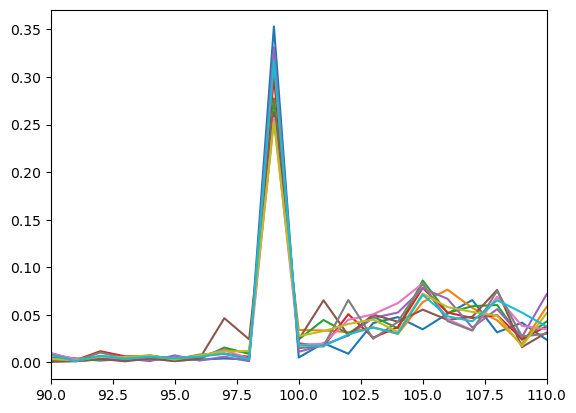

In [217]:
#Epochs = 2
for i in range(0, 10):
    PlayId1 = pidTest[i]
    gs1 = np.load(prefix + '/files/gameState' + str(int(PlayId1)) + '.npy')
    im1 = np.load(prefix + '/files/image' + str(int(PlayId1)) + '.npy')/128.
    y1 = np.load(prefix + '/files/yardage' + str(int(PlayId1)) + '.npy')
    dist1 = model.predict(im1.reshape((1, 100, 200, 3)))
    plt.plot(dist1.reshape(-1,))
    plt.xlim([90,110])

In [218]:
#Offense Cleaning
total_form_df = pd.concat([off_form_df, def_form_df]).reset_index(drop=True)
play_df = pd.DataFrame()
playlist = list(total_form_df['PlayId'].drop_duplicates())
for idx, i in enumerate(playlist):
    pl = total_form_df.loc[(total_form_df['PlayId'] == i)].reset_index(drop=True)
    pl = pl.loc[(pl['IsOnOffense'] == True)].reset_index(drop=True)
    snap = pd.DataFrame(bdb.offense_locations(pl))
    snap = snap.iloc[5:, :].reset_index(drop=True)
    for jdx, j in enumerate(snap['NflId']):
        if (j in list(pl['NflId'])):
            pl2 = pl.loc[(pl['PlayId'] == i) & (pl['NflId'] == j)].reset_index(drop=True)
            play_df = pd.concat([play_df, pl2]).reset_index(drop=True)

offense_formation_dict = bdb.generateFormationImages(play_df,200,100,1)
np.save(prefix + '/offense_formation_dict.npy',offense_formation_dict)

  0%|          | 0/154 [00:00<?, ?it/s]

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
Number of clusters: 20, Silhouette score: 0.2200
Number of clusters: 21, Silhouette score: 0.1974
Number of clusters: 22, Silhouette score: 0.1975


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

Number of clusters: 23, Silhouette score: 0.2045
Number of clusters: 24, Silhouette score: 0.2096
Number of clusters: 25, Silhouette score: 0.2111
Number of clusters: 26, Silhouette score: 0.2086
Number of clusters: 27, Silhouette score: 0.2068
Number of clusters: 28, Silhouette score: 0.2151
Number of clusters: 29, Silhouette score: 0.2150
Number of clusters: 30, Silhouette score: 0.2151
Number of clusters: 31, Silhouette score: 0.2159
Number of clusters: 32, Silhouette score: 0.2142
Number of clusters: 33, Silhouette score: 0.2179
Number of clusters: 34, Silhouette score: 0.2217


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

Number of clusters: 35, Silhouette score: 0.2207
Number of clusters: 36, Silhouette score: 0.2184
Number of clusters: 37, Silhouette score: 0.2220
Number of clusters: 38, Silhouette score: 0.2267
Number of clusters: 39, Silhouette score: 0.2310
Number of clusters: 40, Silhouette score: 0.2281
Number of clusters: 41, Silhouette score: 0.2307


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

Number of clusters: 42, Silhouette score: 0.2253
Number of clusters: 43, Silhouette score: 0.2291
Number of clusters: 44, Silhouette score: 0.2275
Number of clusters: 45, Silhouette score: 0.2291
Number of clusters: 46, Silhouette score: 0.2314
Number of clusters: 47, Silhouette score: 0.2253


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

Number of clusters: 48, Silhouette score: 0.2247
Number of clusters: 49, Silhouette score: 0.2275


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


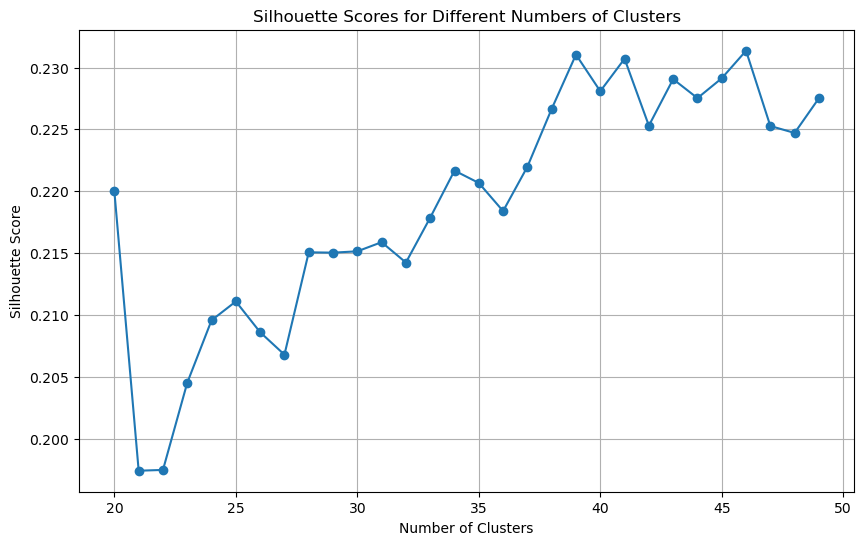

Optimal Number of Clusters: 46


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [219]:
#Finding all offensive formation plays
form_dict = {}
for i in offense_formation_dict.keys():
    if (i in playlist):
        form_dict[i] = offense_formation_dict[i]
images = np.array(list(form_dict.values()))
clustering = bdb.KMeansClusteringWithVGG16(min_clusters=20, max_clusters=50)#len(images)-1)
labels = clustering.fit(images)
league_dict = {'PlayId':[], 'Label':[], 'Team':[]}
for idx, label in enumerate(labels):
    # Assuming you want to store the labels in the same dict
    league_dict['PlayId'].append(list(form_dict.keys())[idx])
    league_dict['Label'].append(label)
    league_dict['Team'].append(play_df.loc[(play_df['PlayId'] == list(form_dict.keys())[idx])]['PossessionTeam'].iloc[0])
leaguedf = pd.DataFrame(league_dict)
leaguedf.loc[(leaguedf['Team'] != offense), 'Team'] = defense

In [220]:
#Finding shared formations between offense and ones defense has faced
ldf = leaguedf.drop_duplicates(subset = ['Label', 'Team'], keep = 'first').reset_index(drop=True)
labels = list(leaguedf.drop_duplicates(subset = 'Label')['Label'])
reciprocated_labels = []
for i in labels:
    if (len(ldf.loc[(ldf['Label'] == i)]) > 1):
        reciprocated_labels.append(i)

In [221]:
for idx, i in enumerate(off_form_df['PlayId']):
    if (str(i) == 'nan'):
        position_adj = np.percentile(player_space.loc[(player_space['Position'] == off_form_df['Position'].iloc[idx]) & (player_space['Plays_total'] > 50)]['Space Factor'], 10)
        off_form_df.at[idx, 'Space Factor'] = position_adj
for idx, i in enumerate(def_form_df['PlayId']):
    if (str(i) == 'nan'):
        position_adj = np.percentile(player_space.loc[(player_space['Position'] == def_form_df['Position'].iloc[idx]) & (player_space['Plays_total'] > 50)]['Space Factor'], 10)
        def_form_df.at[idx, 'Space Factor'] = position_adj

  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)


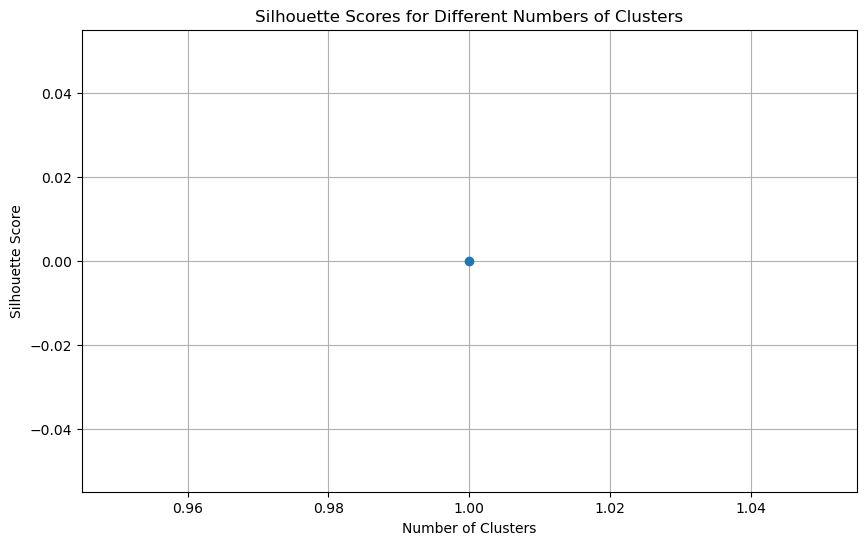

Optimal Number of Clusters: 1


C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
40


  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.1586


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


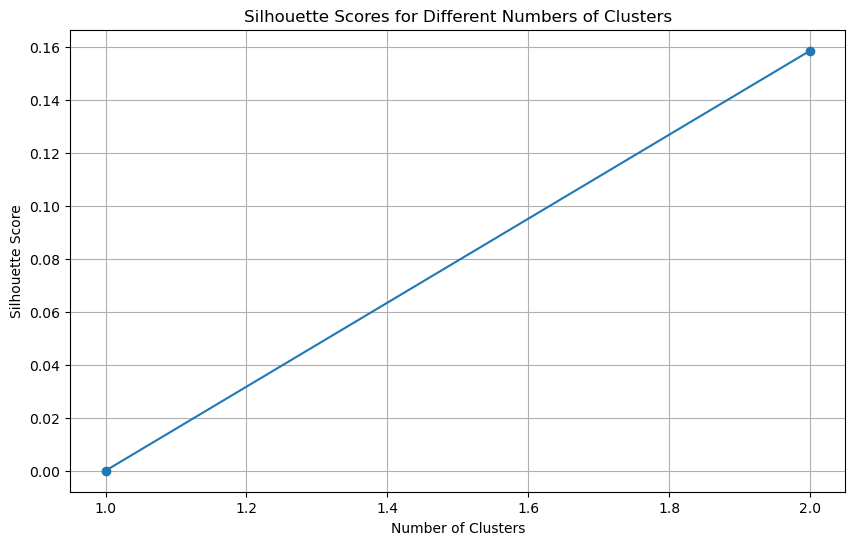

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
9


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)


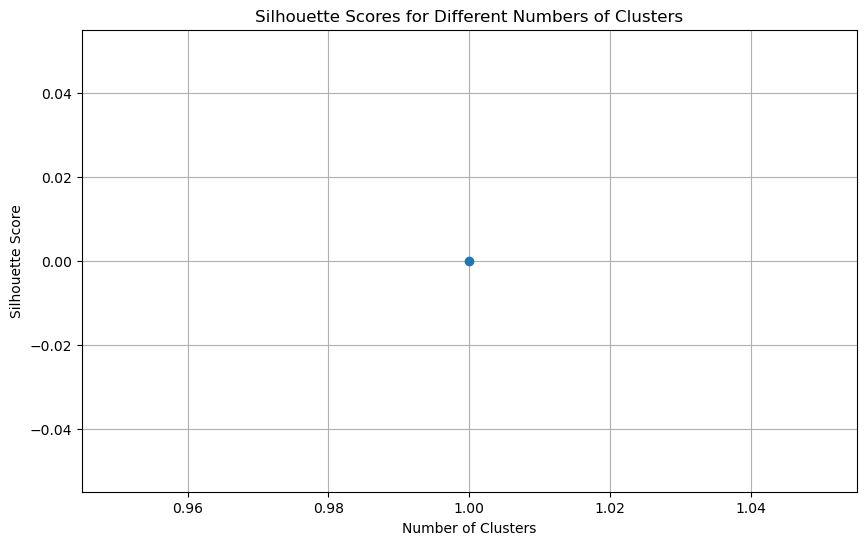

Optimal Number of Clusters: 1


C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
13


  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.1875
Number of clusters: 3, Silhouette score: 0.3228


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


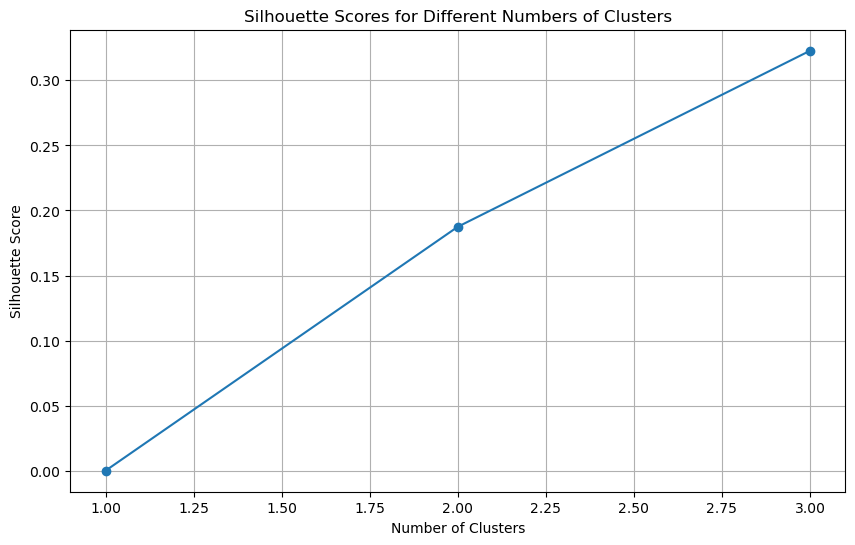

Optimal Number of Clusters: 3


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
10


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
29


  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.3704
Number of clusters: 3, Silhouette score: 0.2619


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


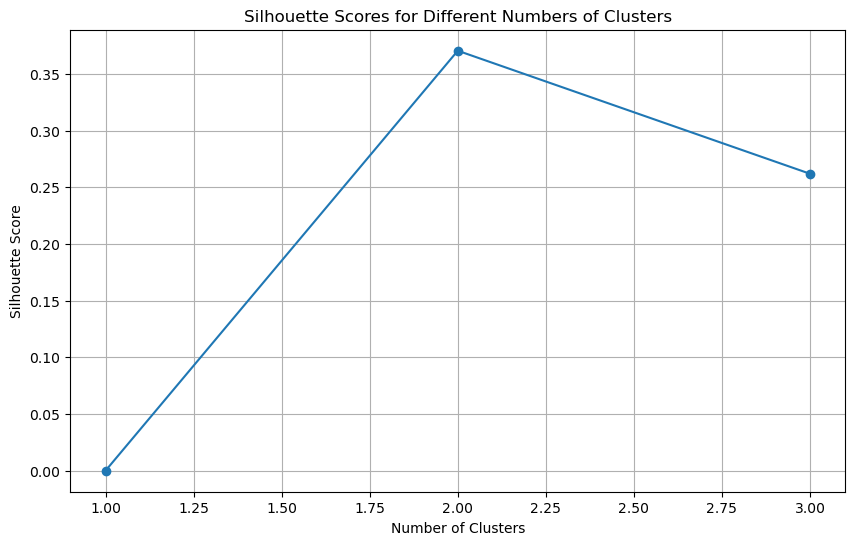

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
3


  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.2272
Number of clusters: 3, Silhouette score: 0.0018


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


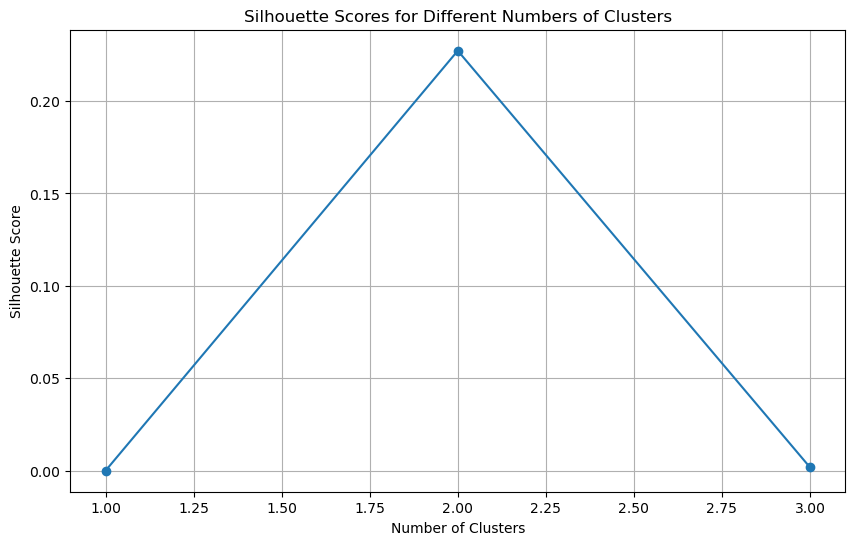

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
7


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)


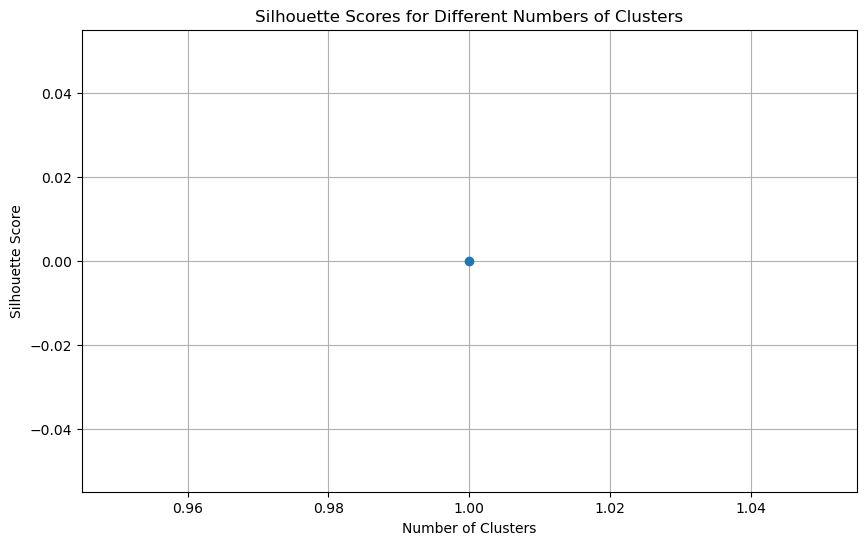

Optimal Number of Clusters: 1


C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
19


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


8


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
42


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)


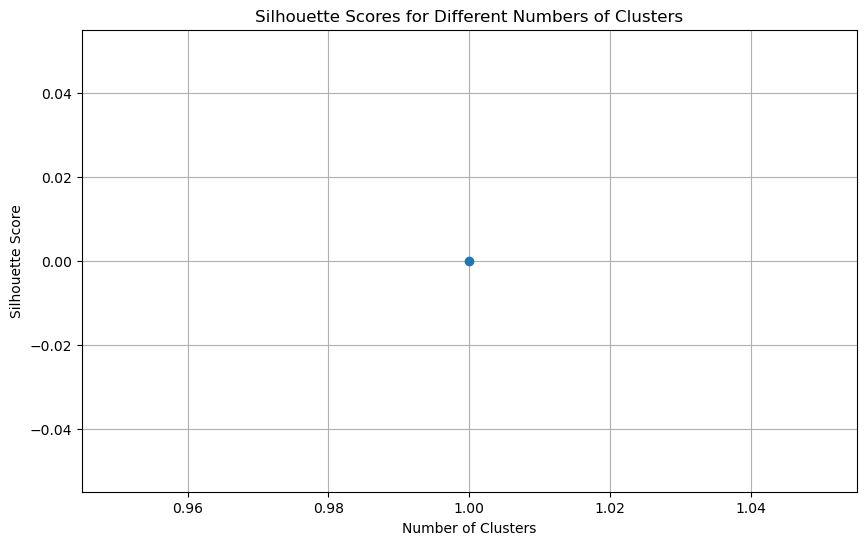

Optimal Number of Clusters: 1


C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


5


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


33


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)


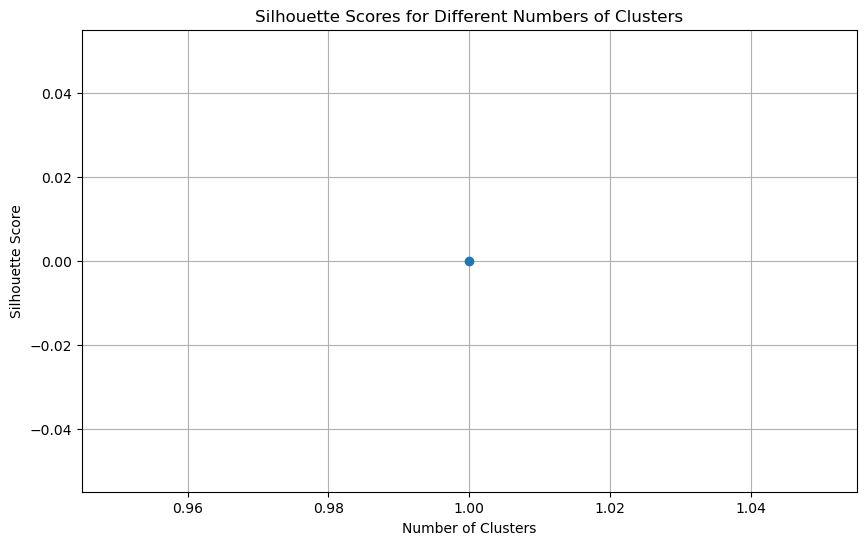

Optimal Number of Clusters: 1


C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
34


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)


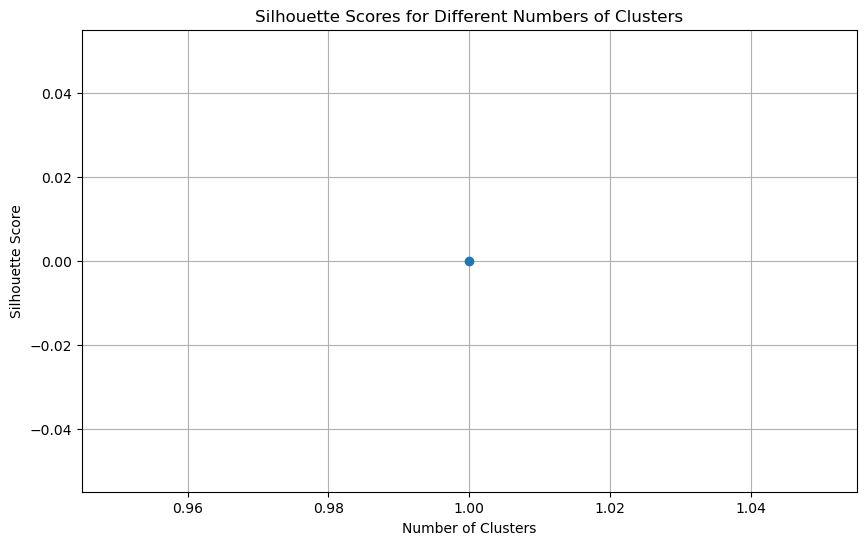

Optimal Number of Clusters: 1


C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
35


  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.3026
Number of clusters: 3, Silhouette score: 0.3458


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


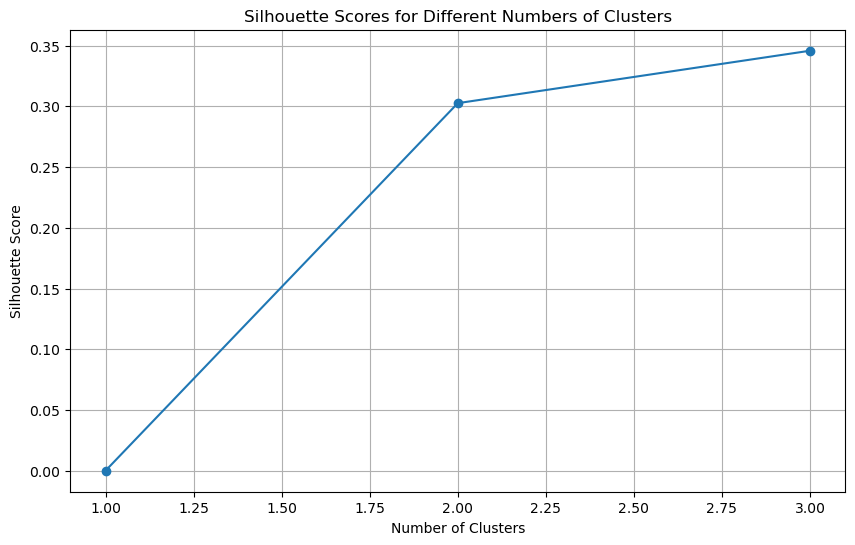

Optimal Number of Clusters: 3


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
27


  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.3040
Number of clusters: 3, Silhouette score: 0.4391


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


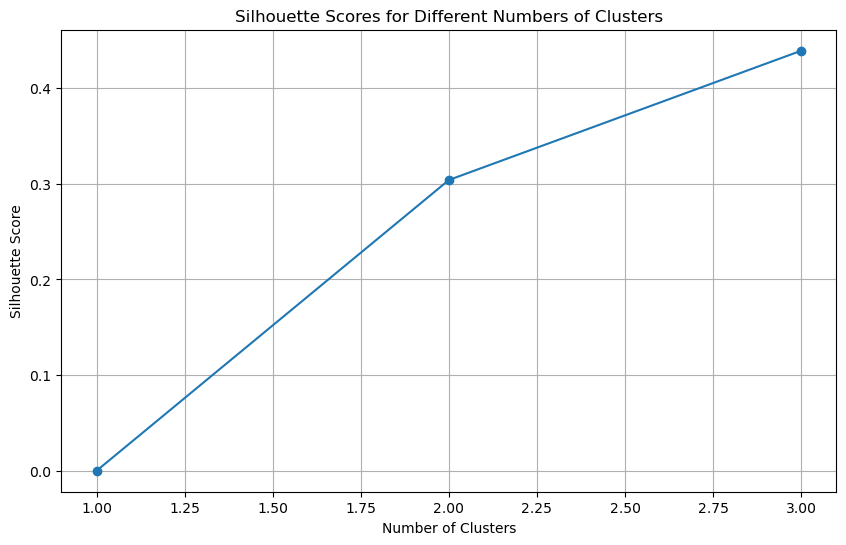

Optimal Number of Clusters: 3


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
15


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


17


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)


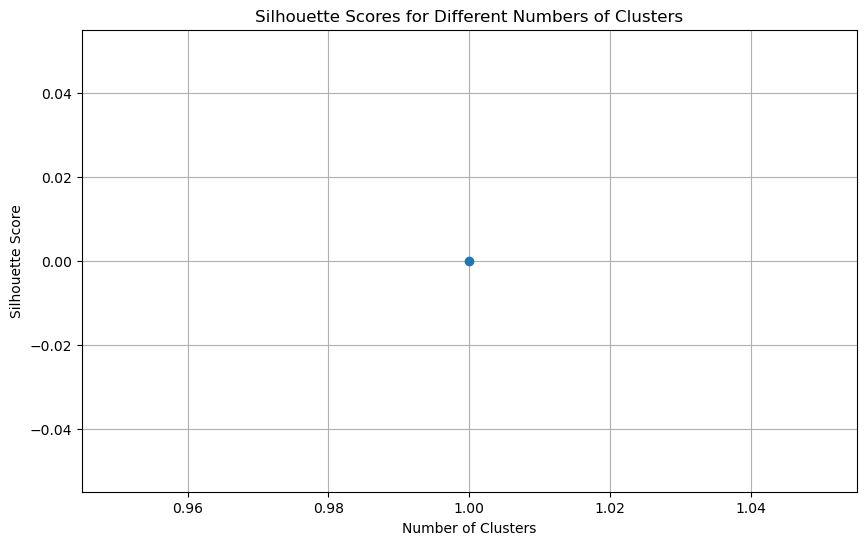

Optimal Number of Clusters: 1


C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


16


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
21


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
38


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
45


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
24


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_2884\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
23


In [222]:
#Clustering all the defensive looks against each reciprocated formation
defensive_clustering = pd.DataFrame()
predict_dict = {'PlayId':[], 'O_Label':[], 'D_Label':[], 'Count':[], 'Prediction':[], 'Mean':[], 'Mean EPA':[], 'Explosive_%':[], 'Negative_%':[]}
drawings_dict = {}
predicted_plays = pd.DataFrame()
weights = np.linspace(-99, 99, 199)
ooo = 0
oo = pd.DataFrame()
#pmf multiplication is just times they happen added up
for i in reciprocated_labels:
    def_play_df = pd.DataFrame()
    defensive_label_df = leaguedf.loc[(leaguedf['Team'] == defense) & (leaguedf['Label'] == i)].reset_index(drop=True)
    for jdx, j in enumerate(defensive_label_df['PlayId']):
        pl = def_form_df.loc[(def_form_df['PlayId'] == j) & (def_form_df['IsOnOffense'] == False)].reset_index(drop=True)
        pl2 = pd.DataFrame()
        snap = pd.DataFrame(bdb.defense_locations(pl)).reset_index(drop=True)
        for kdx, k in enumerate(snap['NflId']):
            if (k in list(pl['NflId'])):
                pl2 = def_form_df.loc[(def_form_df['PlayId'] == j) & (def_form_df['IsOnOffense'] == False) & (def_form_df['NflId'] == k)].reset_index(drop=True)
                def_play_df = pd.concat([def_play_df, pl2]).reset_index(drop=True)
    #Find best offense and best of each defensive cluster, then predict
    defense_formation_dict = bdb.generateDefFormationImages(def_play_df,200,100,1)
    def_form_dict = {}
    for j in defense_formation_dict.keys():
        #if (i in playlist):
        def_form_dict[j] = defense_formation_dict[j]
    def_images = np.array(list(def_form_dict.values()))
    if len(def_images) > 2:
        def_clustering = bdb.DefKMeansClusteringWithVGG16(min_clusters=1, max_clusters=len(def_images)-1)
        def_labels = def_clustering.def_fit(def_images)
    elif len(def_images) > 1:
        def_clustering = bdb.DefKMeansClusteringWithVGG16(min_clusters=1, max_clusters=len(def_images))
        def_labels = def_clustering.def_fit(def_images)
    else:
        def_labels = np.array([0])
    def_dict = {'PlayId':[], 'Label':[], 'Team':[]}
    for idx, label in enumerate(def_labels):
        # Assuming you want to store the labels in the same dict
        def_dict['PlayId'].append(list(def_form_dict.keys())[idx])
        def_dict['Label'].append(label)
        def_dict['Team'].append(defense)
    def_df = pd.DataFrame(def_dict)
    dunique = def_form_df.drop_duplicates(subset = ['PlayId', 'expectedPointsAdded']).reset_index(drop=True)
    def_df = pd.merge(def_df, dunique[['PlayId', 'expectedPointsAdded']], how = 'left', on = 'PlayId').reset_index(drop=True)
    def_labels_deduped = np.unique(def_labels)
    #Find Offensive PlayID with Max EPA with this label
    offense_plays = list(leaguedf.loc[(leaguedf['Team'] == offense) & (leaguedf['Label'] == i)]['PlayId'])
    off_df = off_form_df.loc[(off_form_df['PlayId'].isin(offense_plays))].reset_index(drop=True)
    offense_max_pid = off_df.loc[(off_df['expectedPointsAdded'] == off_df['expectedPointsAdded'].min())]['PlayId'].iloc[0]
    offense_max = off_df.loc[(off_df['IsOnOffense'] == True) & (off_df['PlayId'] == offense_max_pid) & (off_df['PossessionTeam'] == offense)].reset_index(drop=True)
    #Find all Defensive PlayIds with Max EPA for all clusters within this label
    defense_plays = pd.DataFrame()
    for j in def_labels_deduped:
        pl = def_df.loc[(def_df['Label'] == j)].reset_index(drop=True)
        defense_min_pid = pl.loc[(pl['expectedPointsAdded'] == pl['expectedPointsAdded'].min())]['PlayId'].iloc[0]
        defense_min = def_form_df.loc[(def_form_df['PlayId'] == defense_min_pid) & (def_form_df['IsOnOffense'] == False)].reset_index(drop=True)
        offense_max['PlayIdO'] = offense_max['PlayId']
        offense_max['PlayIdD'] = defense_min['PlayId']
        defense_min['PlayIdO'] = offense_max['PlayId']
        defense_min['PlayIdD'] = defense_min['PlayId']
        defense_min = defense_min.loc[(defense_min['DefensiveTeam'] == defense) & (defense_min['IsOnOffense'] == False)].reset_index(drop=True)
        defense_comp = pd.concat([defense_min, offense_max]).reset_index(drop=True)
        defense_comp['PlayId'] = defense_comp['PlayIdD']
        defense_comp['Count'] = len(pl)
        defense_comp['O_Label'] = i
        defense_comp['D_Label'] = j
        defense_plays = pd.concat([defense_plays, defense_comp]).reset_index(drop=True)
        outliers = defense_min.loc[(defense_min['X'] > 70) | (defense_min['X'] < 50)].reset_index(drop=True)
        oo = pd.concat([oo, outliers])
        if (len(outliers) > 0):
            ooo+=1
            break
    predicted_plays = pd.concat([predicted_plays, defense_plays]).reset_index(drop=True)
    compare_dict = generateImages(defense_plays, 200, 100, 1)
    #Fix Drawings Dict
    for jdx, j in enumerate(compare_dict.keys()):
        drawings_dict[j] = compare_dict[j]
        o_label = defense_plays.loc[(defense_plays['PlayId'] == j)]['O_Label'].iloc[0]
        d_label = defense_plays.loc[(defense_plays['PlayId'] == j)]['D_Label'].iloc[0]
        play_count = defense_plays.loc[(defense_plays['PlayId'] == j)]['Count'].iloc[0]
        model_prediction = model.predict(compare_dict[j].reshape(1, 100, 200, 3) / 128.)
        avg = np.sum(weights * model_prediction)
        predict_dict['PlayId'].append(j)
        predict_dict['O_Label'].append(o_label)
        predict_dict['D_Label'].append(d_label)
        predict_dict['Count'].append(play_count)
        predict_dict['Prediction'].append(model_prediction)
        predict_dict['Mean'].append(avg)
        predict_dict['Mean EPA'].append(avg * 0.135 - 0.543)
        predict_dict['Explosive_%'].append(model_prediction[0][111:].sum())
        predict_dict['Negative_%'].append(model_prediction[0][:99].sum())
    print(i)

In [223]:
predict_df = pd.DataFrame(predict_dict)

In [224]:
offensive_formations = {'O_Label':[], 'Prediction':[], 'Mean':[], 'Mean EPA':[], 'Explosive_%':[], 'Negative_%':[]}
labels_unique = list(predict_df['O_Label'].drop_duplicates())
for idx, i in enumerate(labels_unique):
    pl = predict_df.loc[(predict_df['O_Label'] == i)].reset_index(drop=True)
    avg = (weights * pl['Prediction'].iloc[0]).sum()
    offensive_formations['O_Label'].append(i)
    offensive_formations['Prediction'].append((pl['Prediction'] * pl['Count']).sum() / pl['Count'].sum())
    offensive_formations['Mean'].append(avg)
    offensive_formations['Mean EPA'].append(avg * 0.135 - 0.543)
    offensive_formations['Explosive_%'].append(pl['Prediction'][0][0][115:].sum())
    offensive_formations['Negative_%'].append(pl['Prediction'][0][0][:99].sum())

In [225]:
ppdict = bdb.generateImages(predicted_plays, 1600, 800, 1)

  0%|          | 0/23 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:179: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127
C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:182: RuntimeWarning: invalid value encountered in cast
  playTensor = playTensor.astype('int8')


In [226]:
player_number = pd.DataFrame()
for i in range(1, 10):
    pl = pd.read_csv('nfl-big-data-bowl-2025/tracking_week_' + str(i) + '.csv')
    pl = pl.loc[(pl['frameType'] == 'SNAP')].reset_index(drop=True)
    pl = pl.loc[(pl['displayName'] != 'football')].reset_index(drop=True)
    player_number = pd.concat([player_number, pl]).reset_index(drop=True)
player_number = player_number.rename(columns = {'playId':'PlayId', 'nflId':'NflId', 'jerseyNumber':'JerseyNumber'})
player_number['PlayId'] = player_number['gameId'].astype(str) + player_number['PlayId'].astype(str).str.zfill(4)
player_number['PlayId'] = player_number['PlayId'].astype('int64')
player_number = player_number[['PlayId', 'NflId', 'JerseyNumber']].reset_index(drop=True)

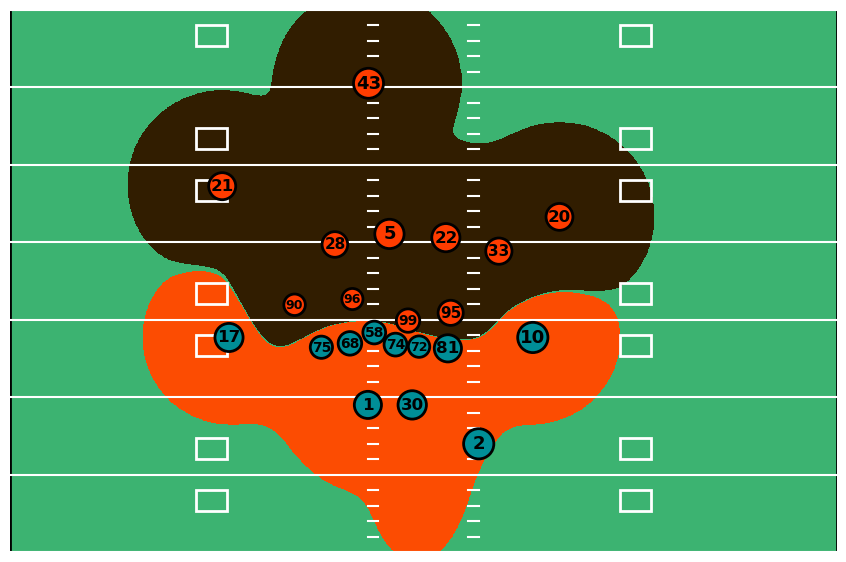

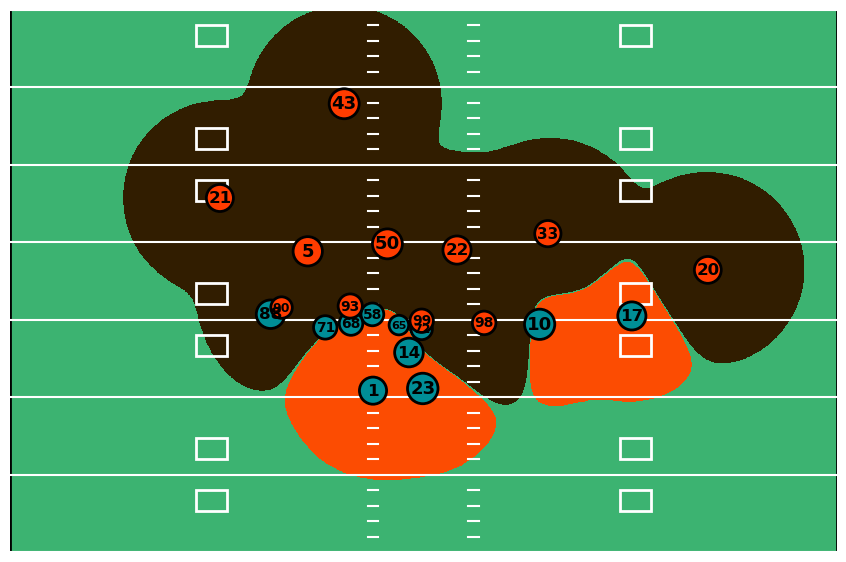

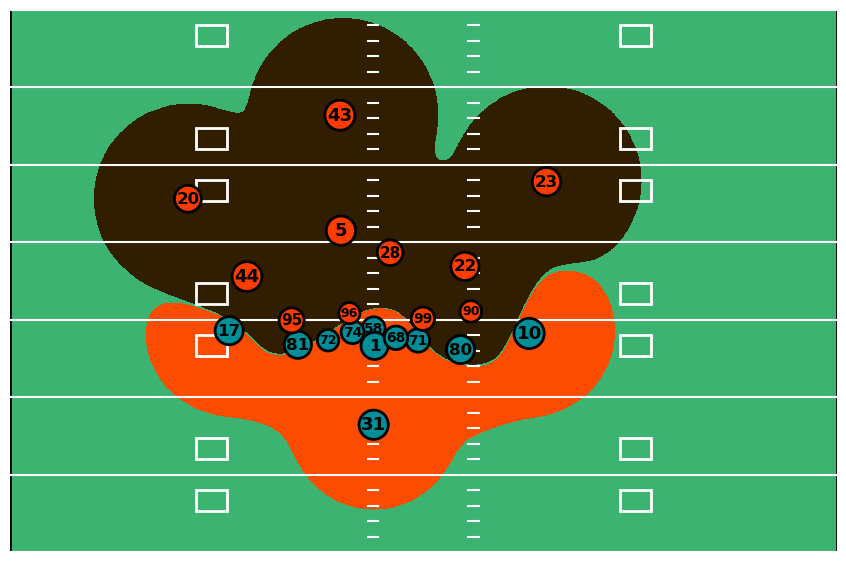

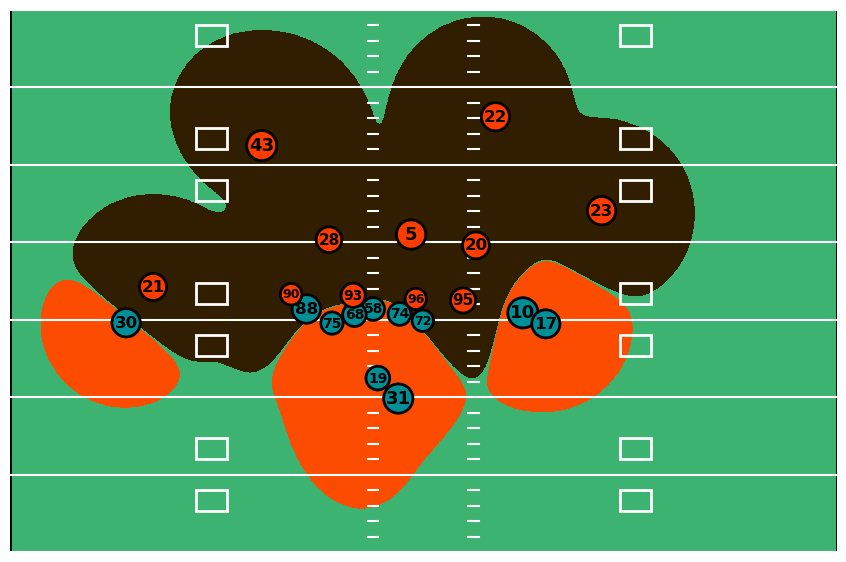

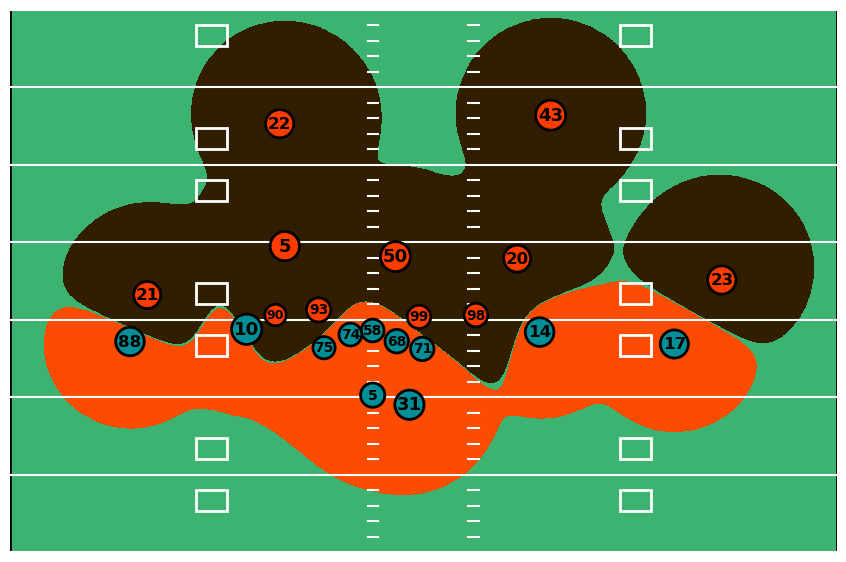

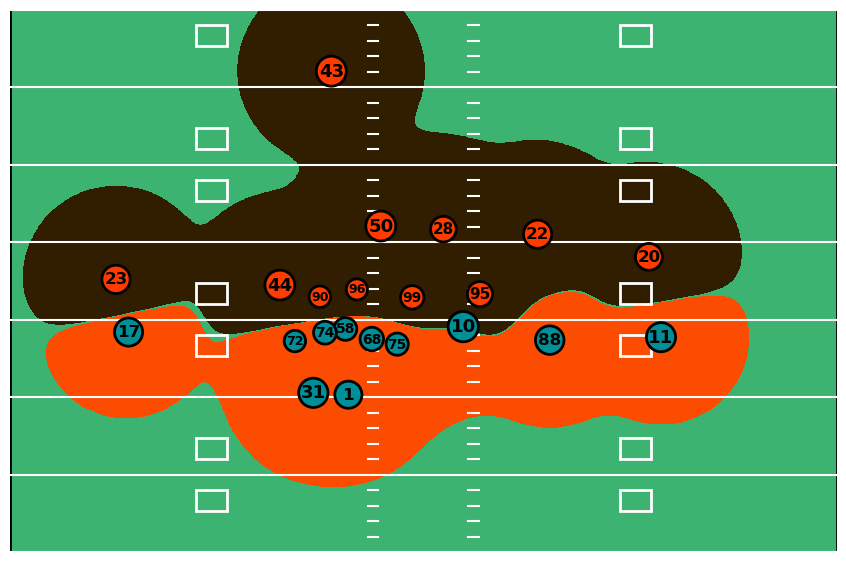

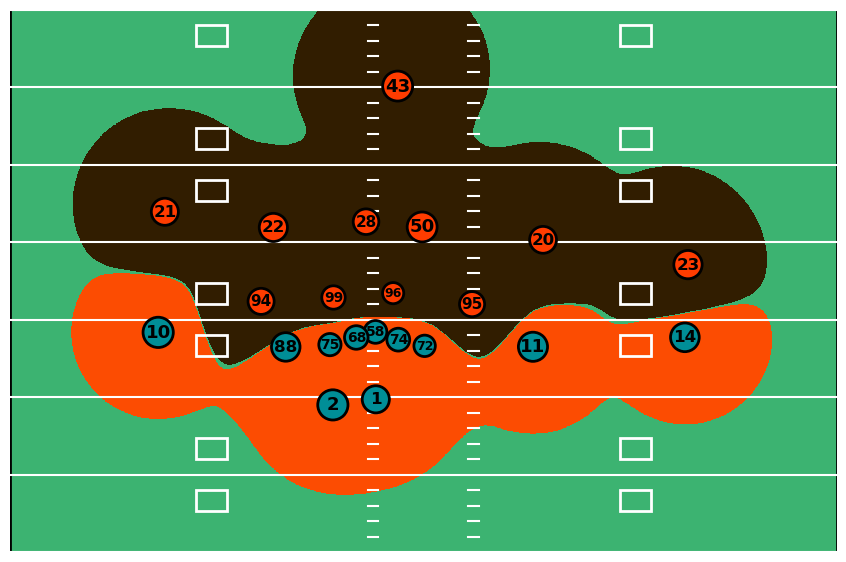

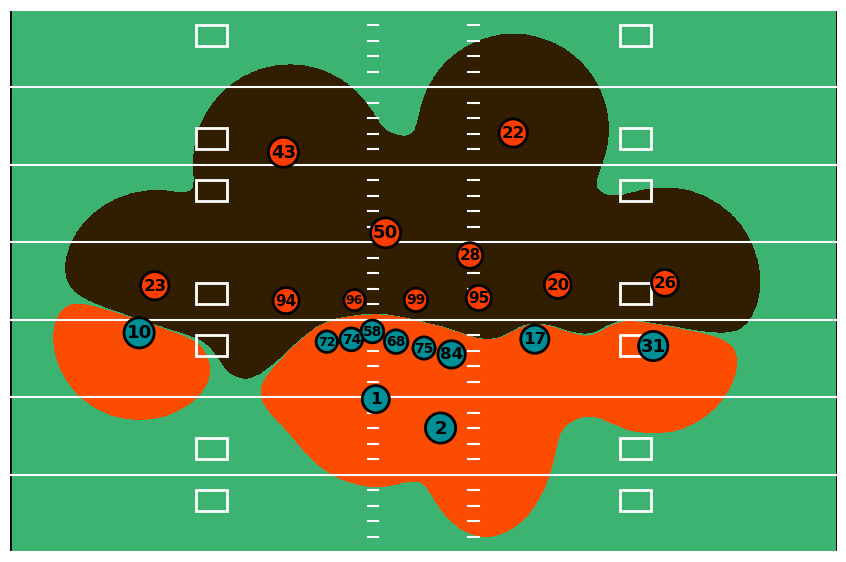

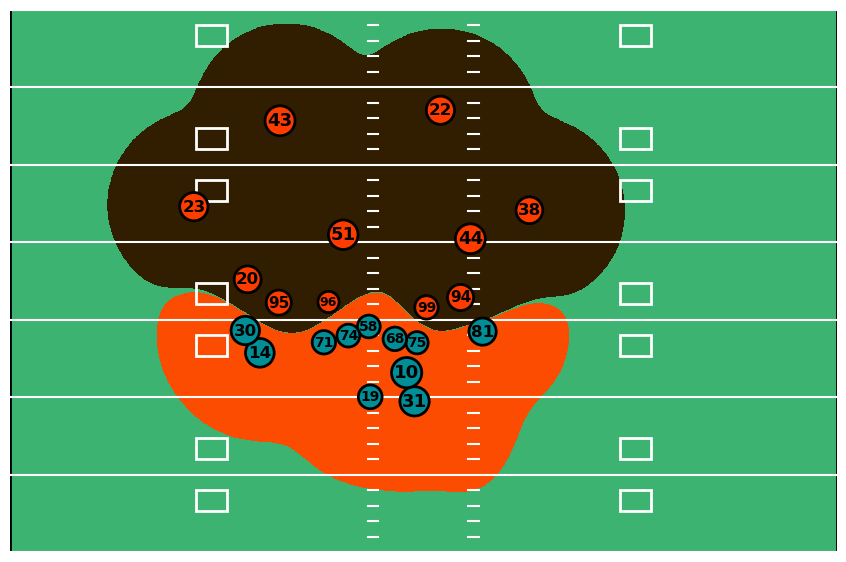

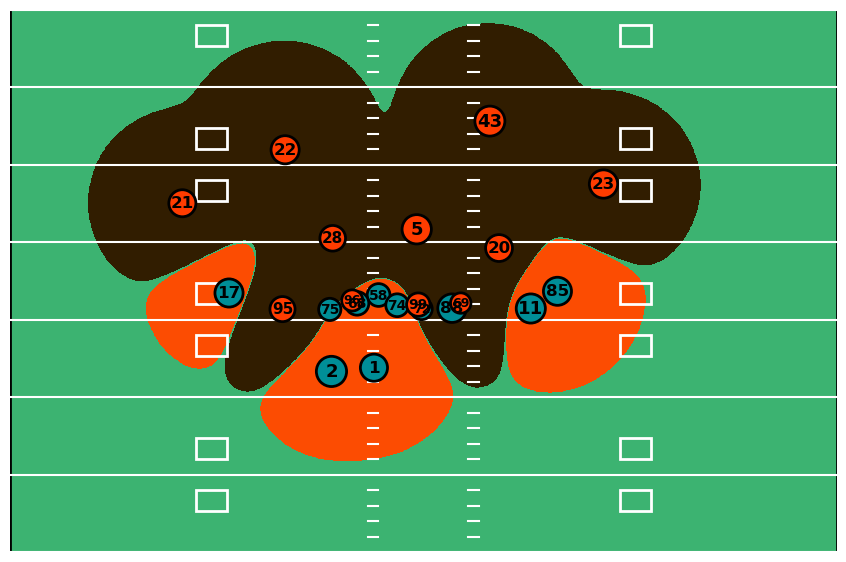

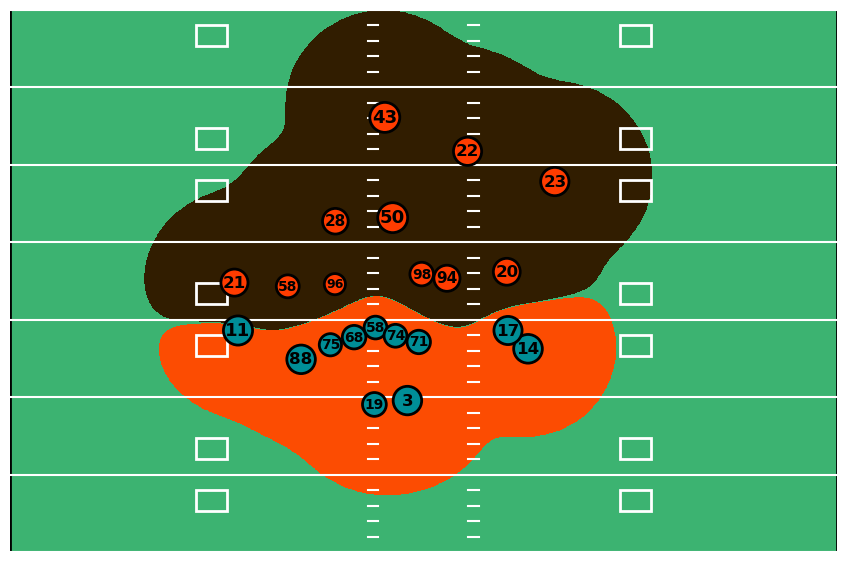

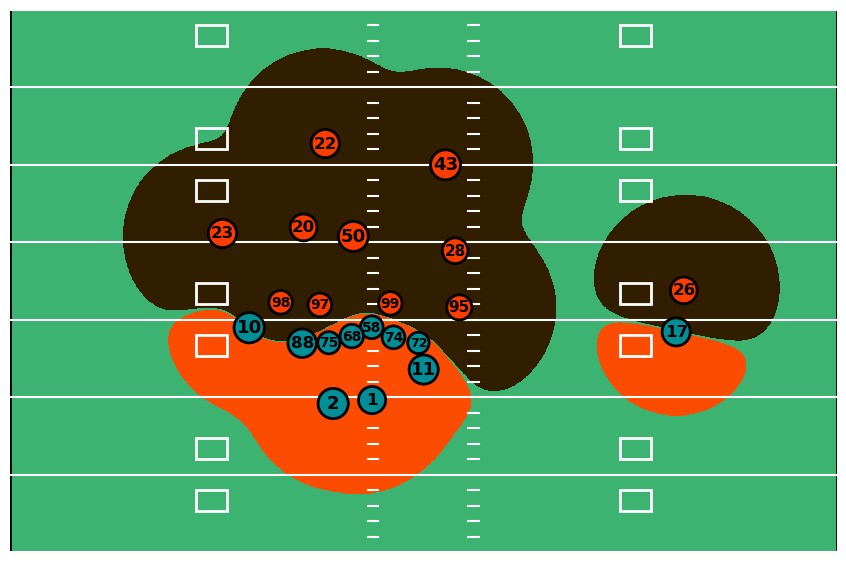

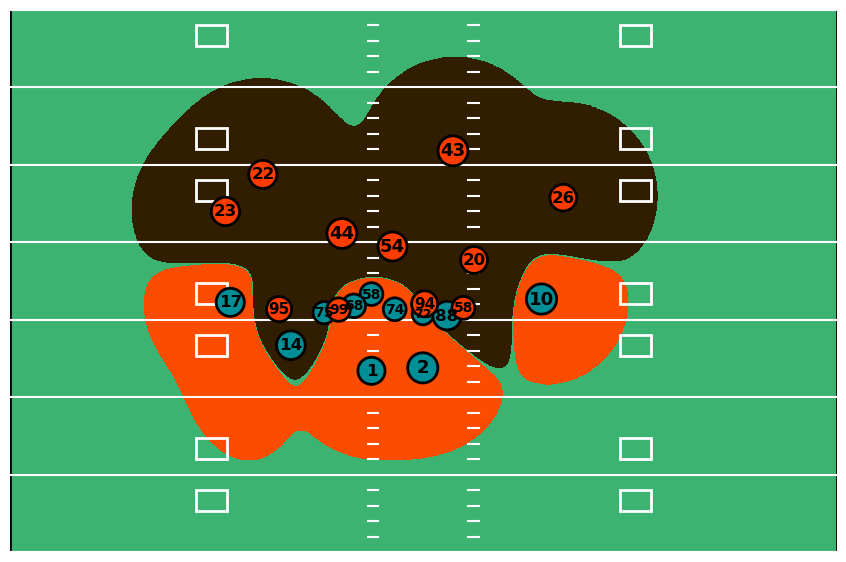

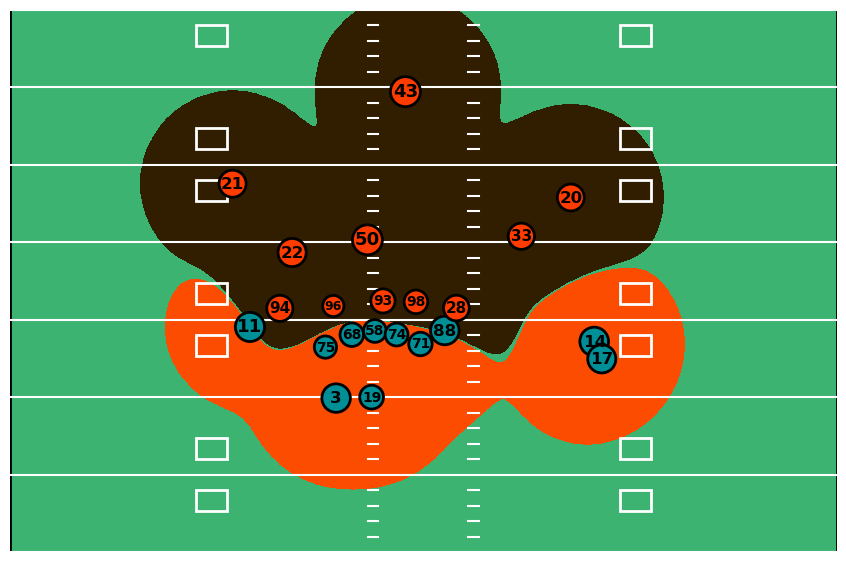

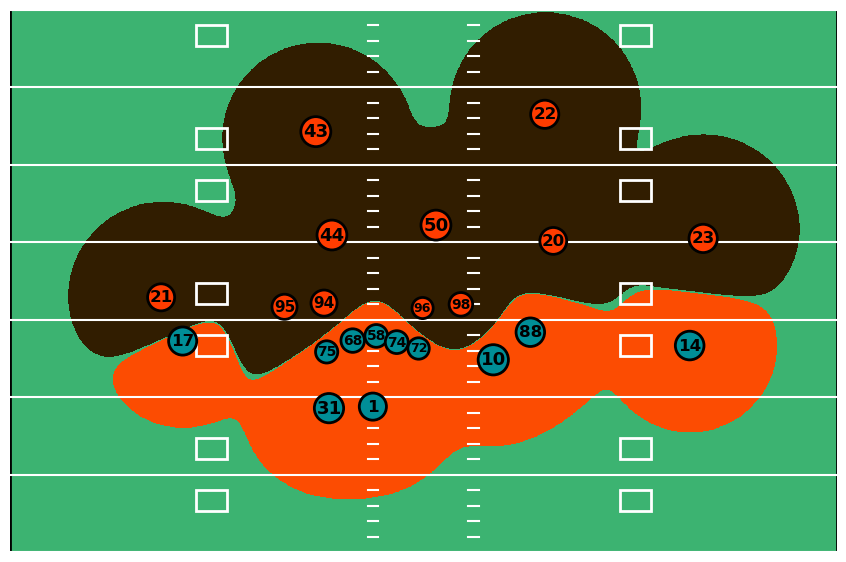

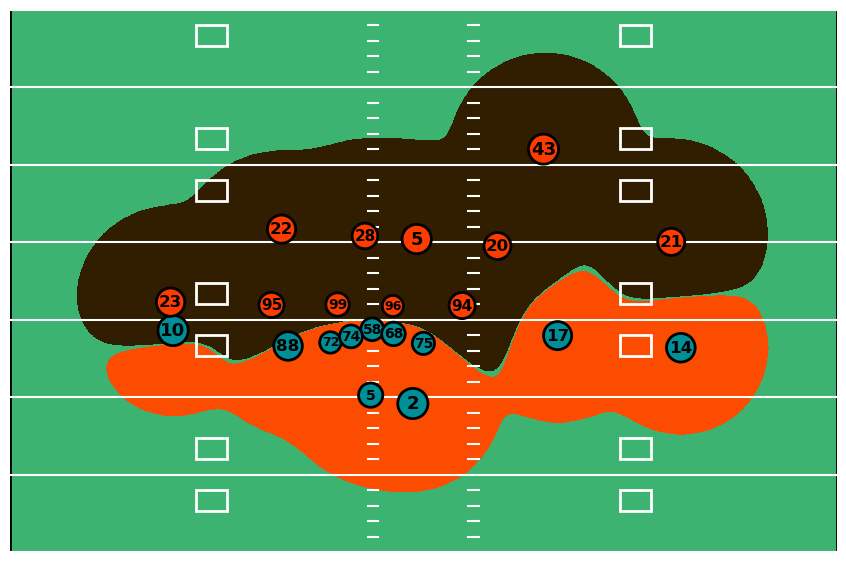

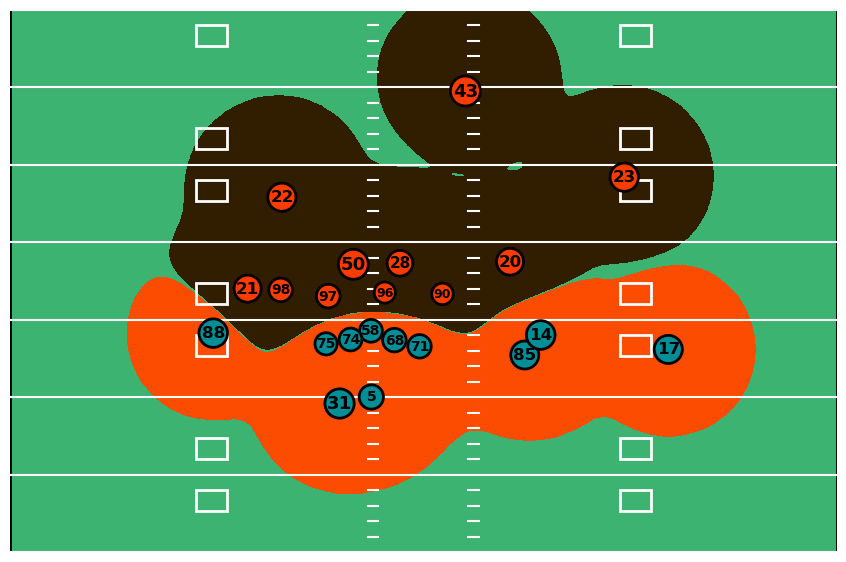

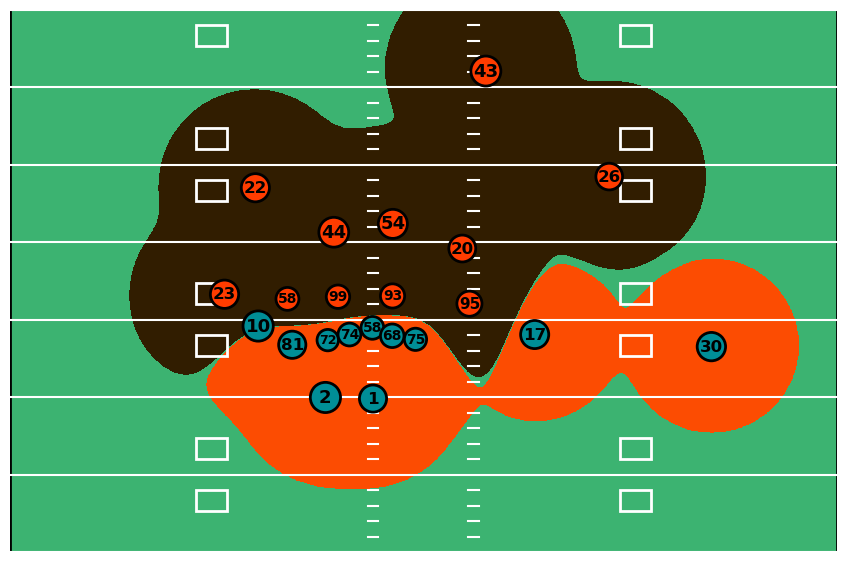

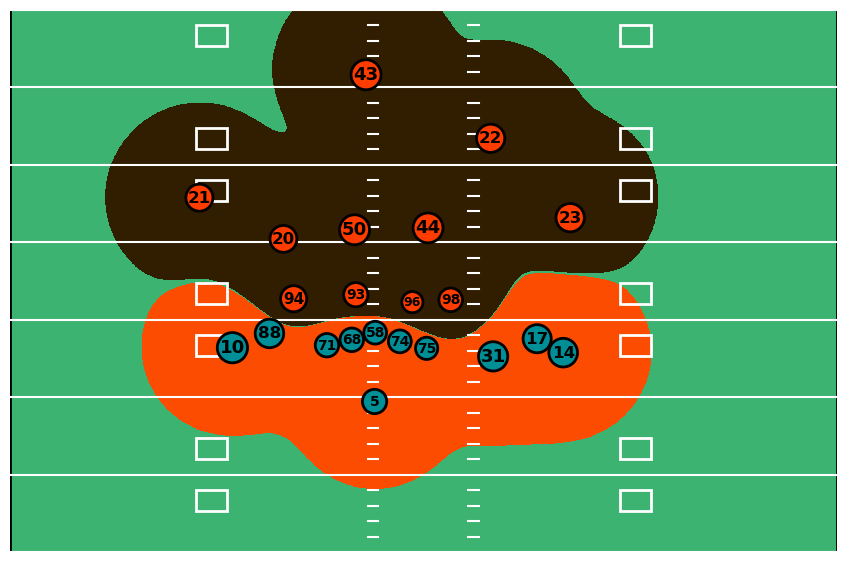

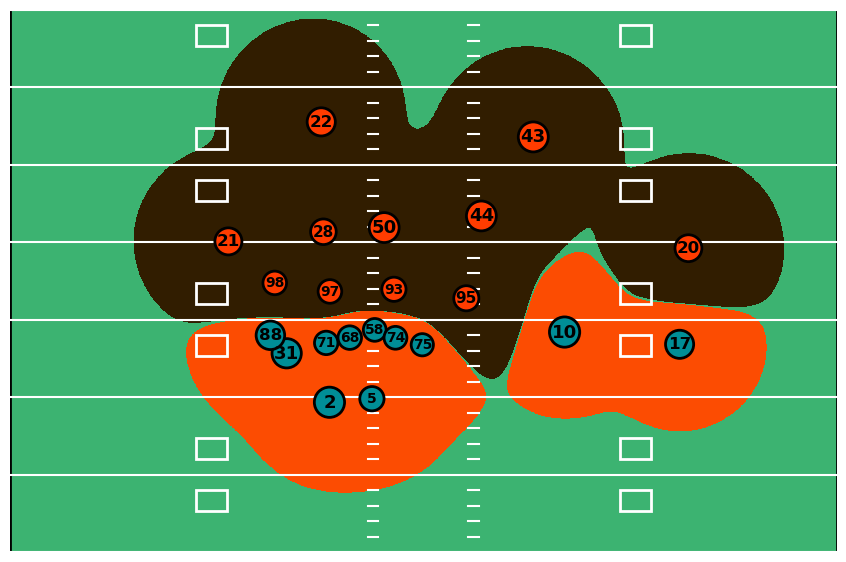

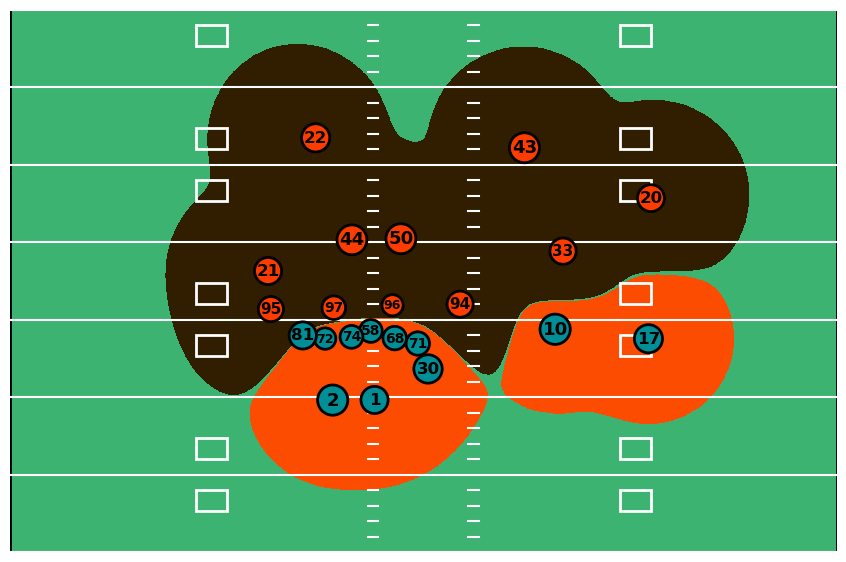

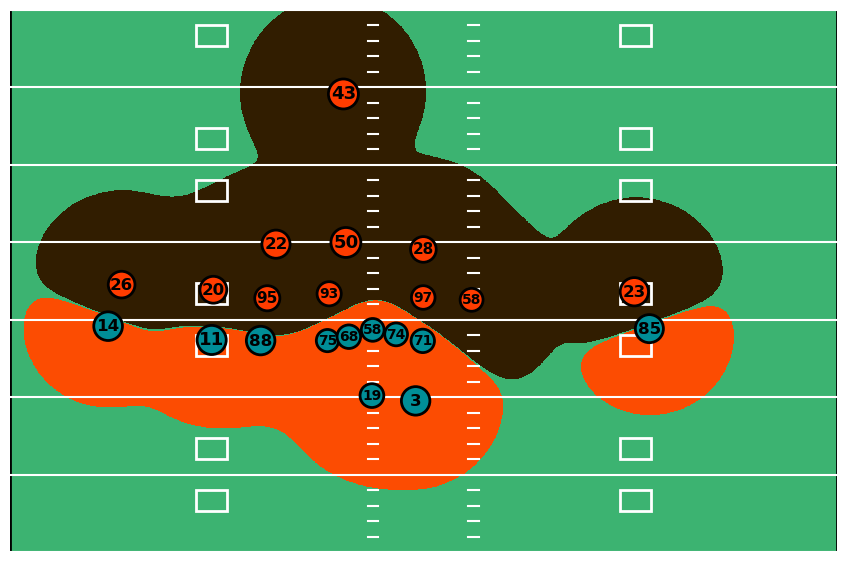

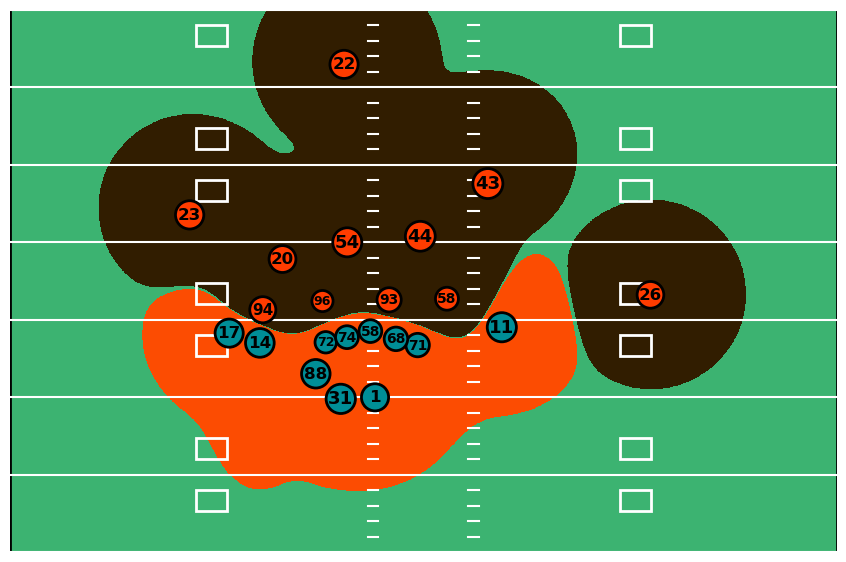

In [227]:
for hdx, h in enumerate(reciprocated_labels):
    offensive_play = list(predicted_plays.loc[(predicted_plays['O_Label'] == h)]['PlayIdO'].drop_duplicates())[0]
    playlistD = list(predicted_plays.loc[(predicted_plays['O_Label'] == h)]['PlayIdD'].drop_duplicates())
    for idx, i in enumerate(playlistD):
        def_label = predicted_plays.loc[(predicted_plays['PlayIdD'] == i)]['D_Label'].iloc[0]
        snapo = predicted_plays.loc[(predicted_plays['PlayIdO'] == offensive_play) & (predicted_plays['PossessionTeam'] == offense) & (predicted_plays['IsOnOffense'] == True)].reset_index(drop=True)
        snapo = pd.merge(snapo, player_number, how = 'left', left_on = ['PlayIdO', 'NflId'], right_on = ['PlayId', 'NflId']).reset_index(drop=True)
        snapd = predicted_plays.loc[(predicted_plays['PlayIdD'] == i) & (predicted_plays['DefensiveTeam'] == defense) & (predicted_plays['IsOnOffense'] == False)].reset_index(drop=True)
        snapd = pd.merge(snapd, player_number, how = 'left', left_on = ['PlayIdD', 'NflId'], right_on = ['PlayId', 'NflId']).reset_index(drop=True)
        snap = pd.concat([snapo, snapd]).reset_index(drop=True)
        snap = pd.merge(snap, player_space[['NflId', 'Space Factor']], how = 'left', on = 'NflId').reset_index(drop=True)
        
        field_width = 53.33  # NFL field width
        field_length = 120  # View range: -20 to 20
        hashmark_to_sideline = 23.42  # NFL official hash mark distance from sideline
        hashmark_width = .67  # hashmark length
        number_to_sideline = 12  # NFL official hash mark distance from sideline
        number_width = 2  # hashmark length
    
        fig, ax = bdb.plt.subplots(figsize=(field_width/5, field_length/7.5))
    
        overlay_image = ppdict[i][:, :, 3]
        overlay_image = np.rot90(overlay_image)
        overlay_image = np.flip(overlay_image, axis=1)
        
        custom_cmap = ListedColormap(["#311D00", "mediumseagreen", "#FC4C02"])
        x_min, x_max, y_min, y_max = -field_width/2, field_width/2, -field_length/2, field_length/2
        ax.imshow(overlay_image, cmap=custom_cmap, extent=[x_min, x_max, y_min, y_max], zorder = 5)
    
        # Main field (excluding end zones)
        ax.add_patch(bdb.patches.Rectangle(
            (-field_width/2, -field_length/2), field_width, field_length,
            linewidth=2, edgecolor='black', facecolor='none', zorder=9))
        
        for idx, row in snap.iterrows():
            x_draw = row['X'] - (field_length / 2)# - 50
            y_draw = row['Y'] - (field_width / 2)
            #y_draw_d = 53.33 - row['Y'] - (field_width / 2)
            pos = row['Position']
            team = row['PossessionTeam']
            size = row['Space Factor']
            jersey_number = int(row['JerseyNumber'])
            if team == offense:
                ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .5 + .5 * size, facecolor='#008E97', edgecolor='black', lw=2)).set_zorder(10)   
            else:
                ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .5 + .5 * size, facecolor='#FF3C00', edgecolor='black', lw=2)).set_zorder(10)   
            ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=int(7 + 7*size), zorder=11, weight='bold')
            
        for yard in range(int((-field_length/2)), int((field_length/2)), 1):
            linestyle = '-' #if yard % 10 == 0 else '--'
            y_position = yard
            if yard % 5 == 0:
                ax.plot([-field_width/2, field_width/2], [y_position, y_position], color='white', linestyle=linestyle, zorder=9)
            else:
                ax.plot([-field_width/2 + hashmark_to_sideline - hashmark_width/2, -field_width/2 + hashmark_to_sideline + hashmark_width/2], [y_position, y_position], color='white', linestyle=linestyle, zorder=9)
                ax.plot([field_width/2 - hashmark_to_sideline + hashmark_width/2, field_width/2 - hashmark_to_sideline - hashmark_width/2], [y_position, y_position], color='white', linestyle=linestyle, zorder=9)
    
            number_offset = number_width / 2  # Half the height of the number box
    
            if (yard % 10 == 0) & (yard != int(-field_length/2)) & (yard != int((field_length/2))):
                # Left numbers
                ax.add_patch(bdb.patches.Rectangle(
                    (-field_width/2 + number_to_sideline, y_position + number_offset), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
                ax.add_patch(bdb.patches.Rectangle(
                    (-field_width/2 + number_to_sideline, y_position - number_offset - number_width/1.5), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
                
                # Right numbers
                ax.add_patch(bdb.patches.Rectangle(
                    (field_width/2 - number_to_sideline - number_width, y_position + number_offset), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
                ax.add_patch(bdb.patches.Rectangle(
                    (field_width/2 - number_to_sideline - number_width, y_position - number_offset - number_width/1.5), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
    
        ax.set_xlim(-field_width/2, field_width/2)
        ax.set_ylim(-field_length/2, field_length/2)
        bdb.plt.gca().set_facecolor('green')
        bdb.plt.axis('off')
        #bdb.plt.title(str(i))
        bdb.plt.ylim(-15, 20) 
        bdb.plt.savefig('testfig/testfig-O' + str(h) + '-D' + str(def_label) + '-' + str(i)+  '.jpg', bbox_inches="tight", pad_inches = 0, dpi = 600)
        bdb.plt.show()

In [228]:
weights[114]

15.0

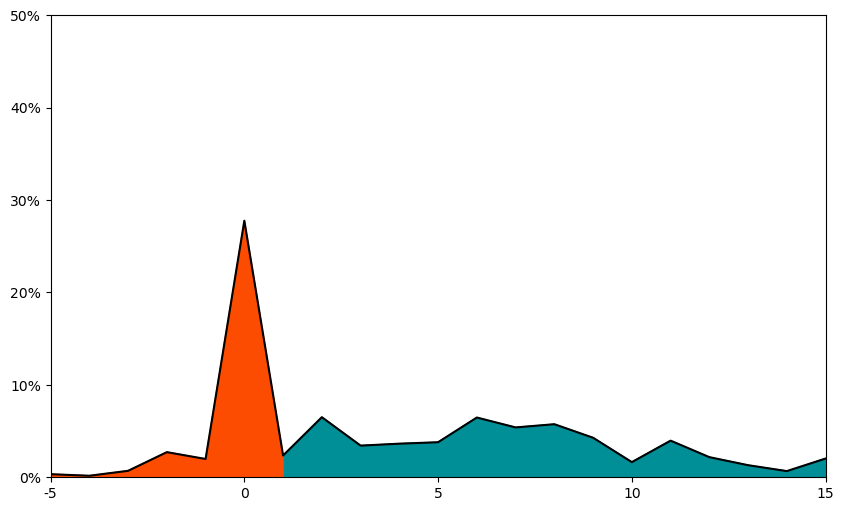

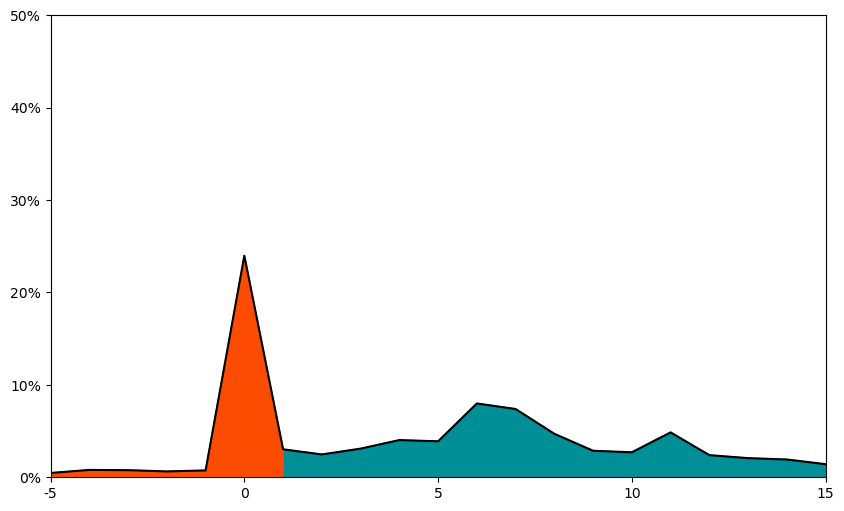

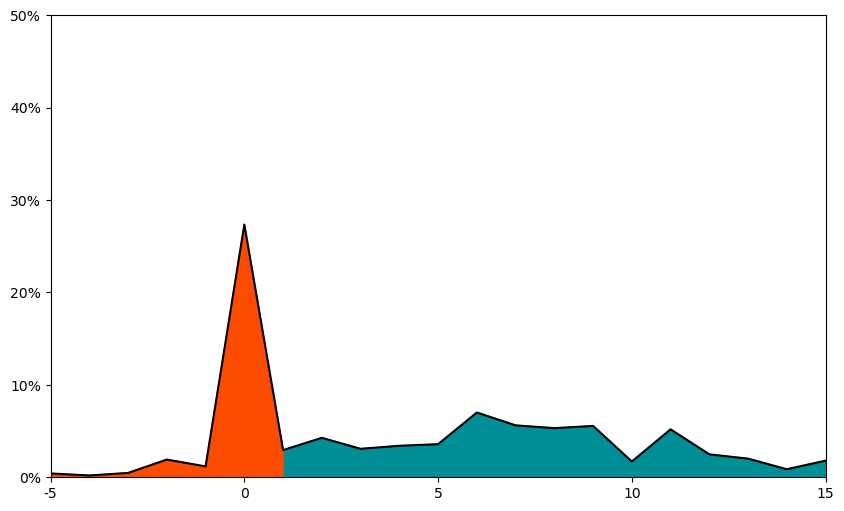

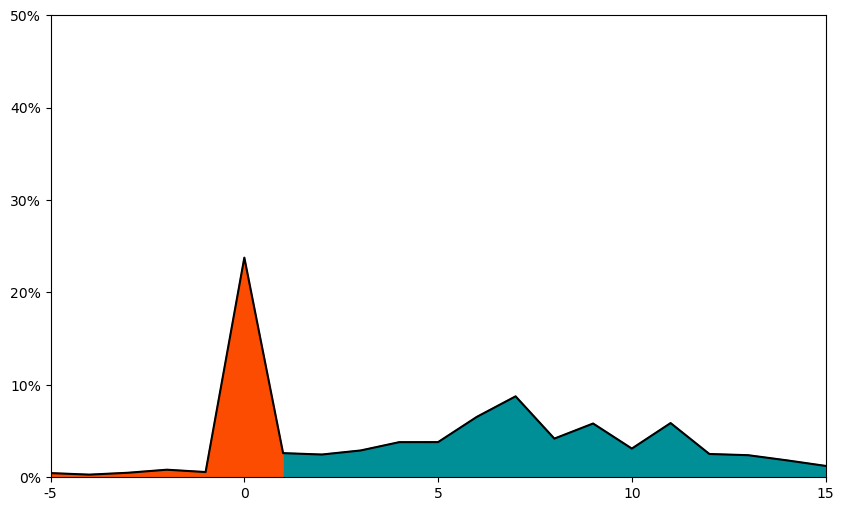

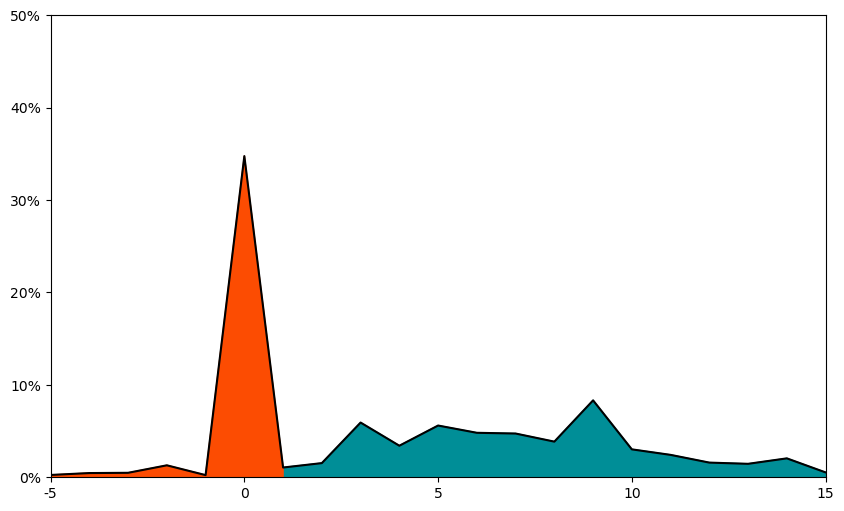

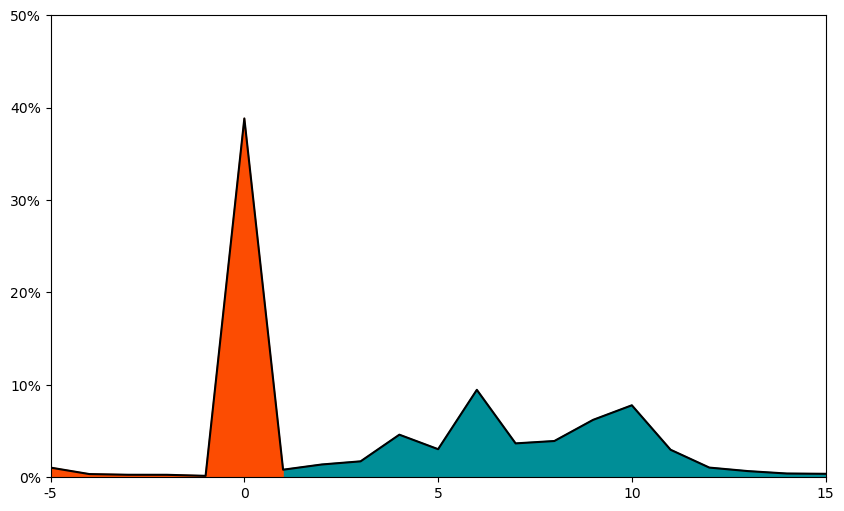

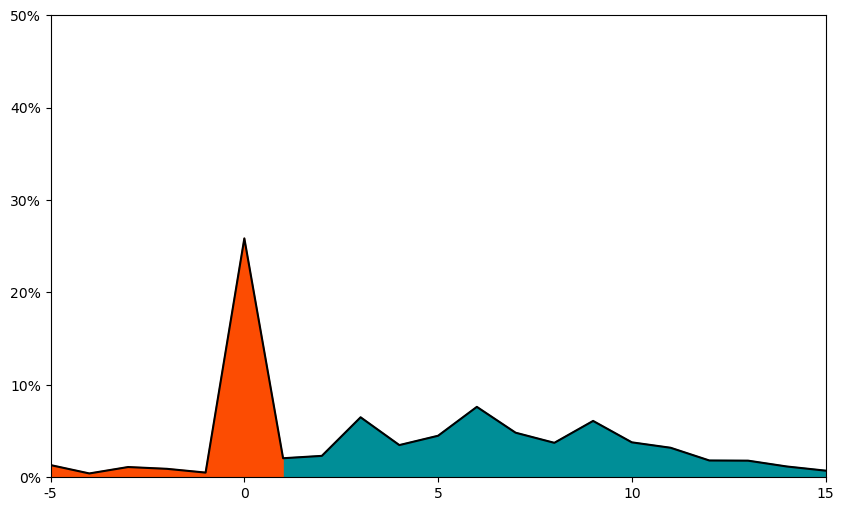

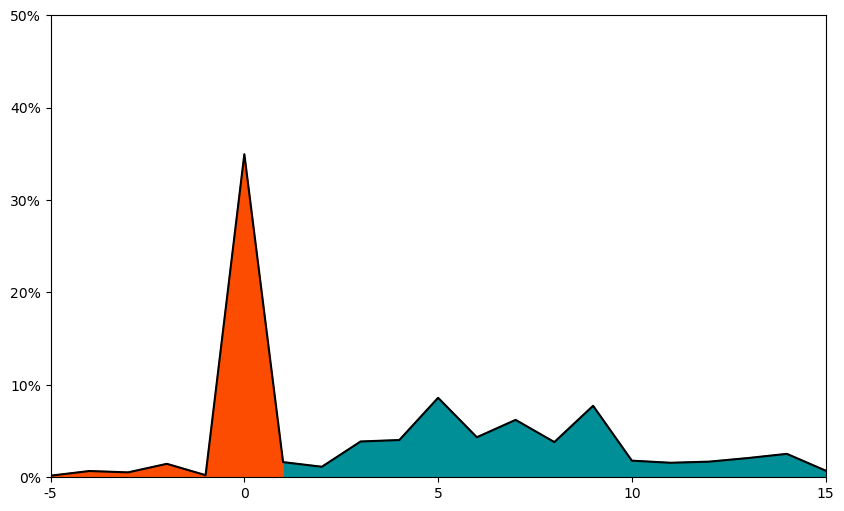

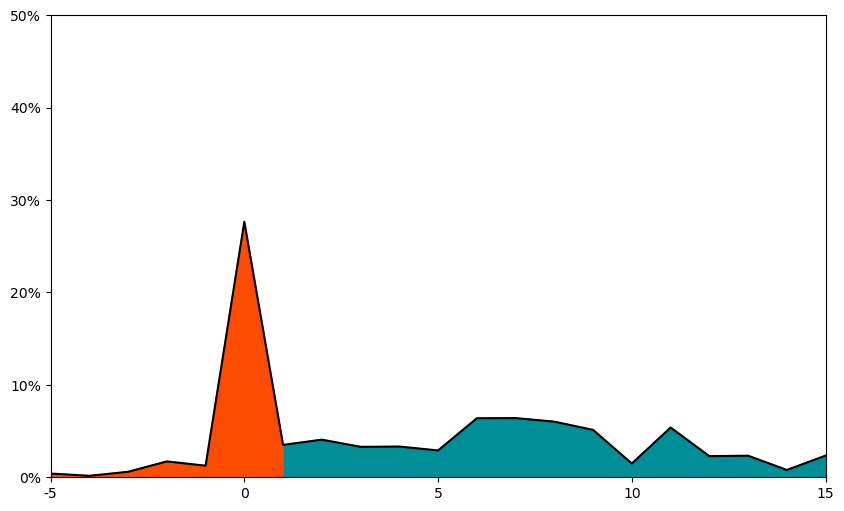

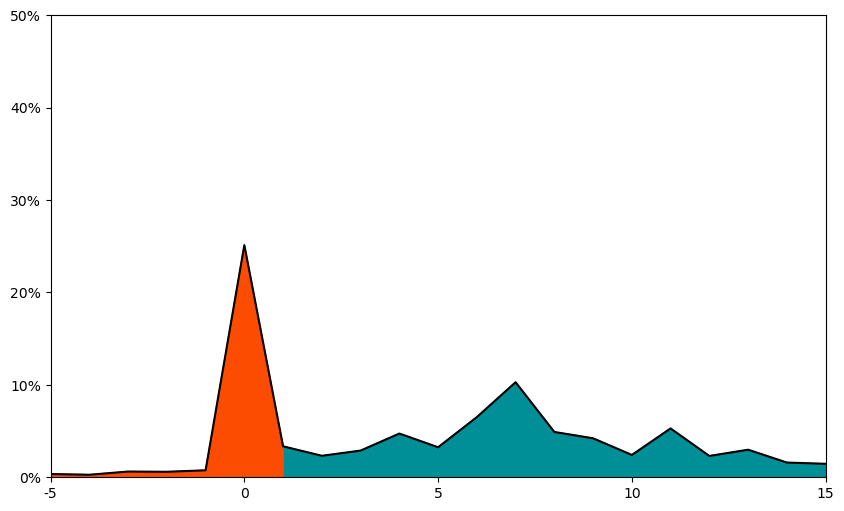

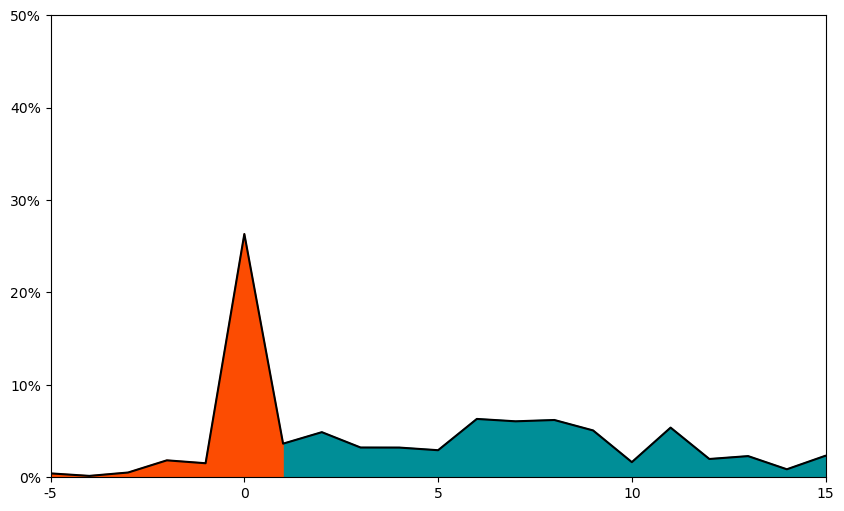

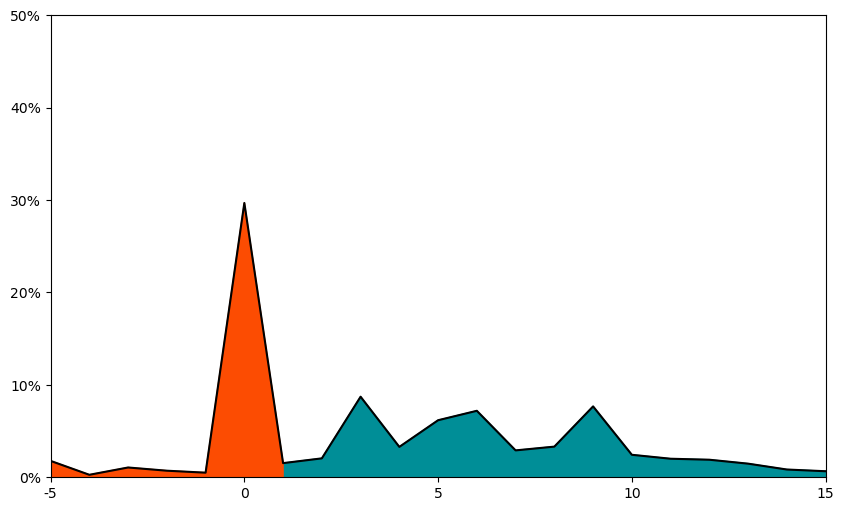

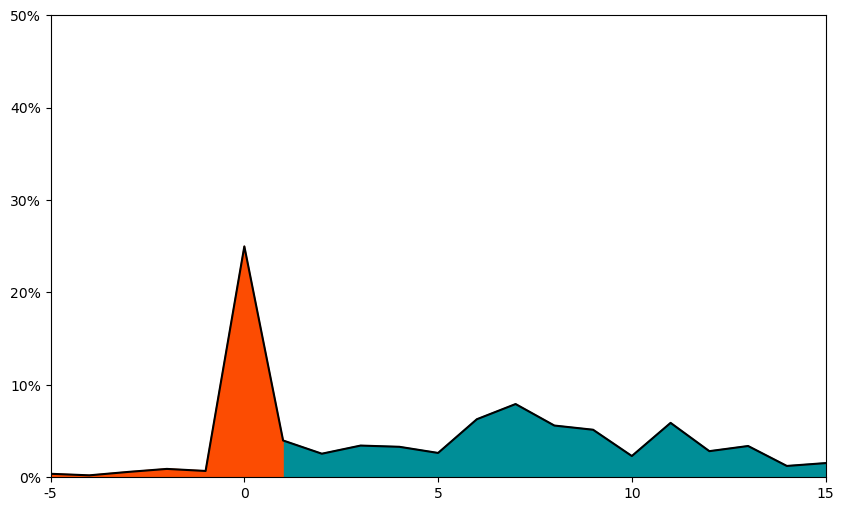

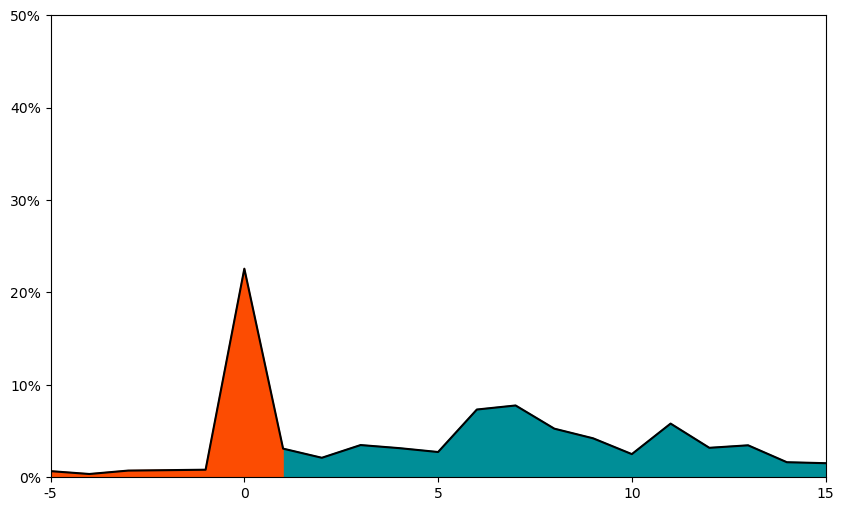

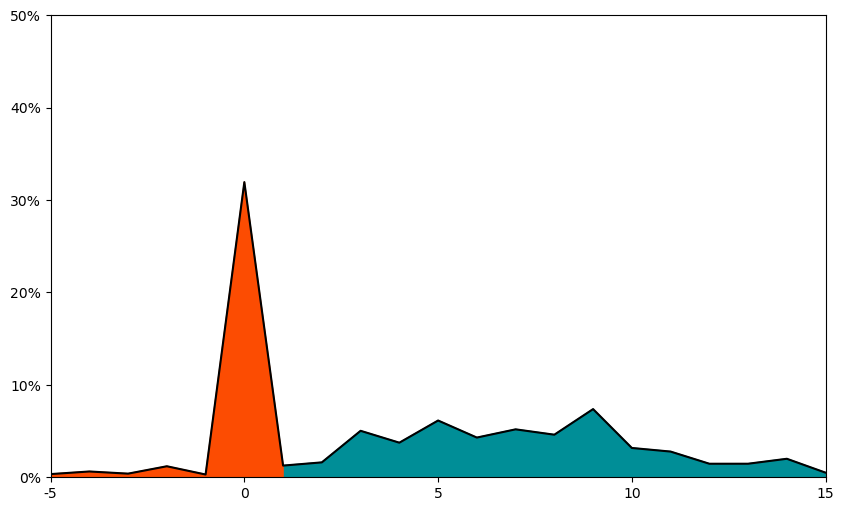

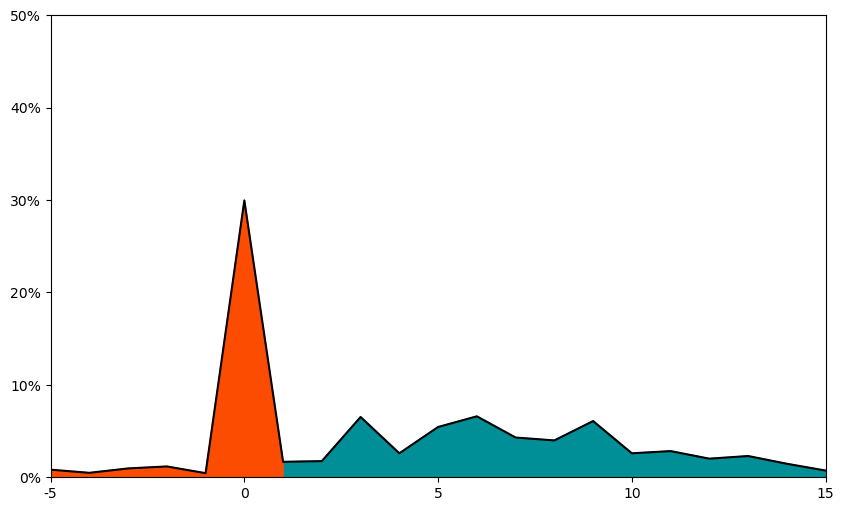

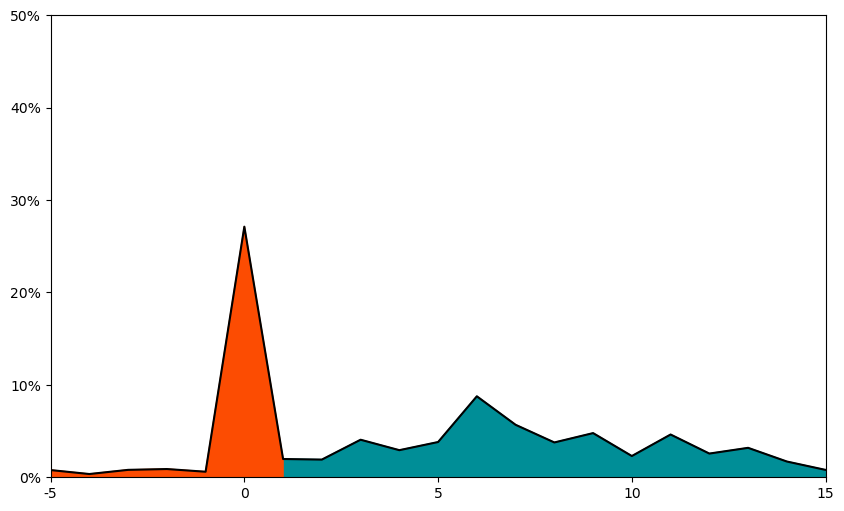

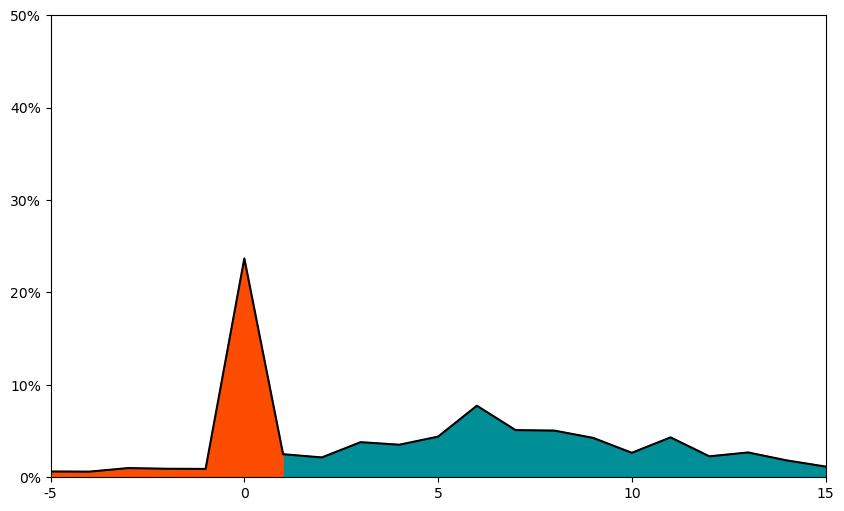

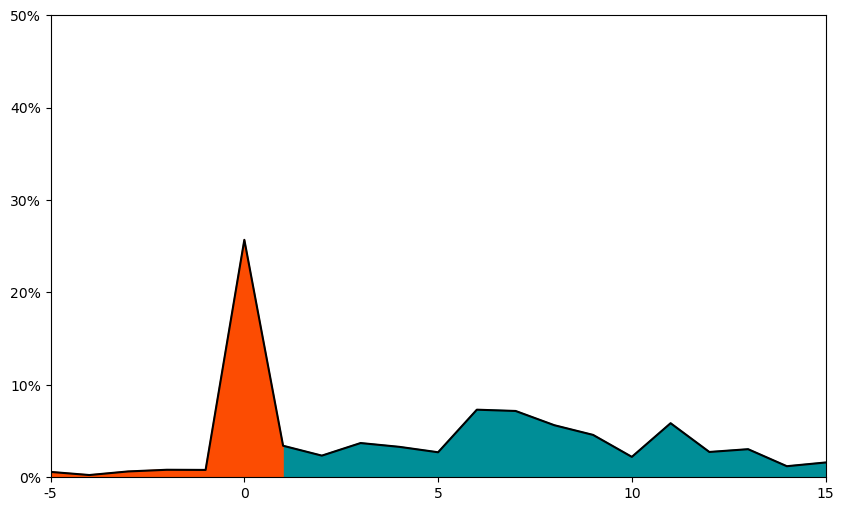

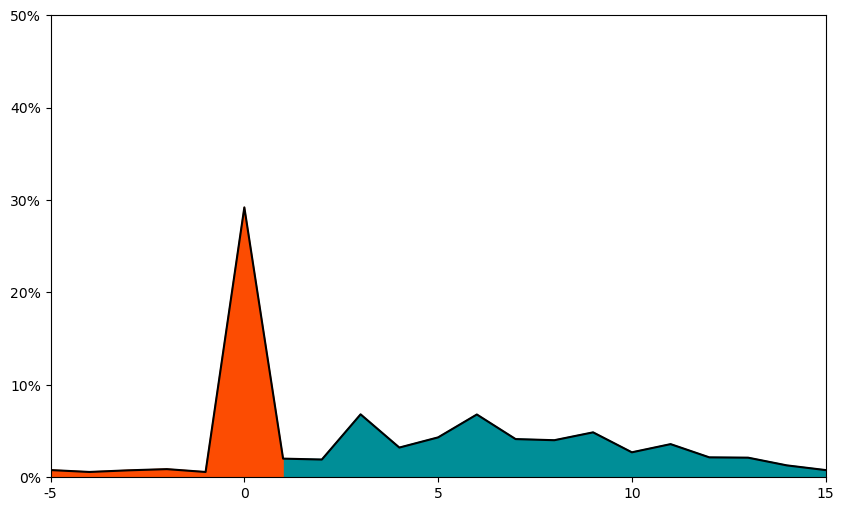

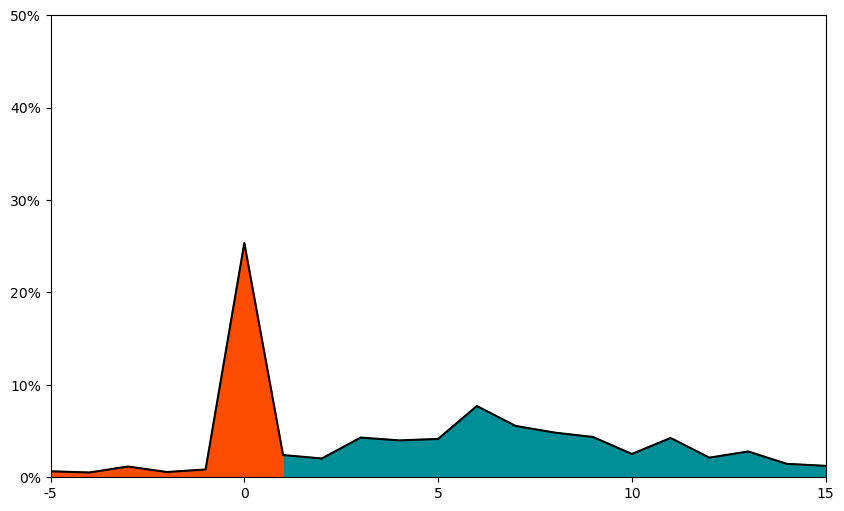

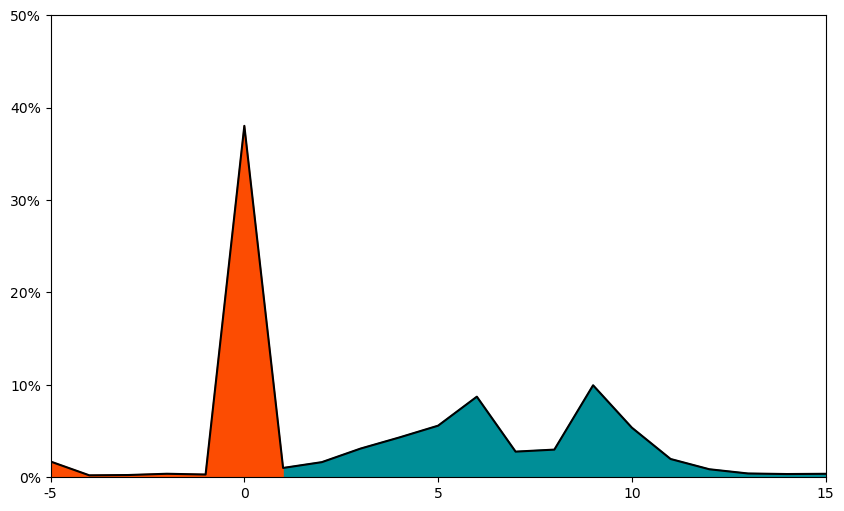

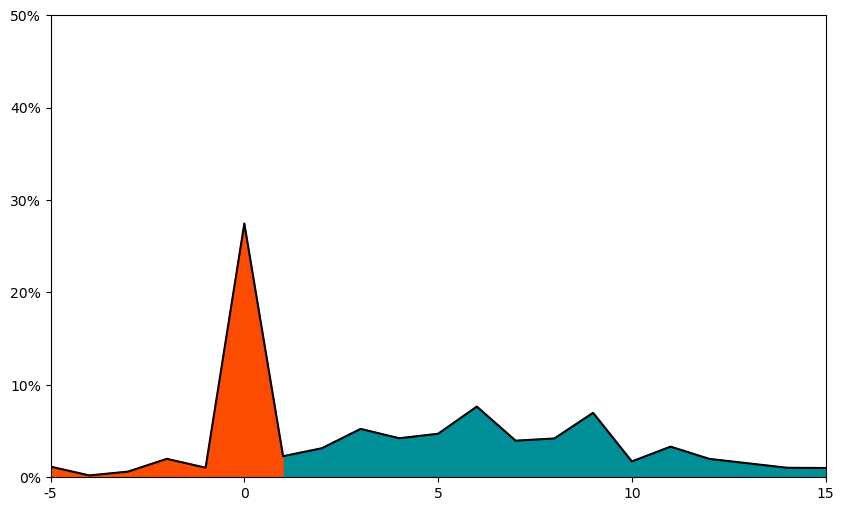

In [229]:
for i in range(len(predict_df)):
    bdb.plt.figure(figsize=(10, 6))  # Optional: Set figure size01
    bdb.plt.ylim([0, .5])
    bdb.plt.xlim([94, 114])
    new_x_ticks = [94, 99, 104, 109, 114]
    new_x_labels = [-5, 0, 5, 10, 15]
    new_y_ticks = [0, .1, .2, .3, .4, .5]
    new_y_labels = ['0%', '10%', '20%', '30%', '40%', '50%']
    bdb.plt.xticks(new_x_ticks, new_x_labels)
    bdb.plt.yticks(new_y_ticks, new_y_labels)
    y_values = predict_df['Prediction'].iloc[i][0].reshape(-1,)
    x_values = np.array(range(len(y_values)))
    bdb.plt.plot(x_values, y_values, color='black')
    bdb.plt.fill_between(x_values, y_values, 0, where=(x_values >= 100), alpha=1, color='#008E97')
    bdb.plt.fill_between(x_values, y_values, 0, where=(x_values <= 100), alpha=1, color='#FC4C02')# alpha controls the transparency
    bdb.plt.show()

In [230]:
predict_df

PlayId  O_Label  D_Label  Count  \
0   20220911010063       40        0      3   
1   20220911011338        9        0      3   
2   20220911010850       13        0      3   
3   20220918010598       10        0      1   
4   20220911011357       29        0      1   
5   20221009023942        3        0      1   
6   20220911013006        7        0      1   
7   20221016011643       19        0      3   
8   20221031001058        8        0      1   
9   20220918010811       42        0      1   
10  20221002012034        5        0      2   
11  20221016011552       33        0      1   
12  20221031002678       34        0      2   
13  20221002010354       35        0      3   
14  20220922003759       27        0      2   
15  20220922002083       15        0      3   
16  20221009021870       17        0      1   
17  20221031002656       16        0      2   
18  20221002010749       21        0      1   
19  20221009020394       38        0      1   
20  20221009021344       45        0      1   
21  20221016011184       24        0      1   
22  20221031000237       23        0      1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Prediction  \
0   [[8.3900195e-06, 9.8460305e-06, 9.054401e-06, 1.2353355e-05, 1.3077578e-05, 1.6231534e-05, 1.415645e-05, 9.735953e-06, 2.6193184e-05, 1.3778742e-05, 1.192162e-05, 9.731645e-06, 1.2361757e-05, 1.2315172e-05, 1.2329109e-05, 8.263861e-06, 1.6679754e-05, 1.4842072e-05, 1.692424e-05, 6.635419e-06, 8.213286e-06, 1.20939285e-05, 1.1783179e-05, 1.1224069e-05, 8.869456e-06, 1.24682565e-05, 1.10427245e-05, 1.4792996e-05, 1.2227727e-05, 1.3088146e-05, 2.4311617e-05, 1.1923144e-05, 7.676899e-06, 1.02503...   
1   [[1.3914174e-05, 2.0087555e-05, 1.36068575e-05, 1.7753697e-05, 2.5141906e-05, 3.0337518e-05, 1.5601485e-05, 2.0851743e-05, 2.6043634e-05, 1.4981939e-05, 1.7683757e-05, 1.7517666e-05, 2.5847887e-05, 2.5281504e-05, 2.263386e-05, 1.5270834e-05, 1.9173254e-05, 2.4699439e-05, 2.1229698e-05, 1.3150954e-05, 1.3955051e-05, 1.4942271e-05, 1.7972294e-05, 1.7914317e-05, 1.4897339e-05, 1.7193544e-05, 1.3433246e-05, 2.1723408e-05, 1.5557818e-05, 1.943628e-05, 1.6270233e-05, 2.4536599e-05, 1.3519239e-05, ...   
2   [[1.1374593e-05, 1.4365577e-05, 1.4061735e-05, 1.5148884e-05, 1.517047e-05, 1.6769454e-05, 1.545915e-05, 1.225287e-05, 2.4439518e-05, 1.2240968e-05, 1.1920959e-05, 1.3355692e-05, 1.4912885e-05, 1.6214359e-05, 1.4411683e-05, 8.880678e-06, 1.510621e-05, 1.8151897e-05, 1.996008e-05, 1.0094037e-05, 1.1477512e-05, 1.37133e-05, 1.5883694e-05, 1.3310261e-05, 9.565011e-06, 1.5654003e-05, 1.2045824e-05, 2.1710812e-05, 1.0610652e-05, 1.49196985e-05, 2.2621532e-05, 1.4935472e-05, 1.1254379e-05, 1.23296...   
3   [[8.829103e-06, 1.3956814e-05, 1.15828925e-05, 1.3739542e-05, 1.4663487e-05, 1.6313337e-05, 1.2473207e-05, 1.4641925e-05, 2.3656177e-05, 1.6774517e-05, 1.5578238e-05, 1.4079243e-05, 1.8236964e-05, 2.0451991e-05, 1.4899915e-05, 1.48377785e-05, 1.5785998e-05, 1.8101862e-05, 1.6004891e-05, 1.2861653e-05, 1.2487466e-05, 1.453814e-05, 1.2754907e-05, 1.4063193e-05, 1.1781925e-05, 1.43891975e-05, 1.660637e-05, 2.0266472e-05, 1.3897099e-05, 1.1934286e-05, 1.9011757e-05, 2.0702173e-05, 1.0968586e-05,...   
4   [[5.6552976e-06, 6.9487755e-06, 6.046396e-06, 6.9115795e-06, 9.208098e-06, 9.301015e-06, 6.459809e-06, 5.4976467e-06, 1.1289865e-05, 1.0146989e-05, 8.395319e-06, 5.8447067e-06, 8.135842e-06, 8.991542e-06, 9.386686e-06, 7.982889e-06, 9.353595e-06, 9.668972e-06, 9.935376e-06, 4.315687e-06, 7.080964e-06, 6.110666e-06, 6.9887174e-06, 6.8103977e-0

In [237]:
for idx, i in enumerate(player_space['Position']):
    position_adj = player_space.loc[(player_space['Position'] == player_space['Position'].iloc[idx])]['Space Factor'].min()
    player_space.at[idx, 'Space Factor Adj'] = player_space['Space Factor'].iloc[idx] - position_adj
    print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [238]:
ofdf = pd.DataFrame(offensive_formations)

In [239]:
ofdf_mean = ofdf.sort_values(by = 'Mean', ascending=False).reset_index(drop=True)
ofdf_expl = ofdf.sort_values(by = 'Explosive_%', ascending=False).reset_index(drop=True)
ofdf_neg = ofdf.sort_values(by = 'Negative_%', ascending=False).reset_index(drop=True)

In [245]:
players1 = pd.read_csv('nfl-big-data-bowl-2025/players.csv')

In [253]:
players1.loc[(players1['displayName'] == 'Terron Armstead')]['nflId'].iloc[0]

40023

In [247]:
players1.loc[(players1['displayName'] == 'Robert Jones')]

nflId height  weight birthDate       collegeName position   displayName
1433  53861    6-5     330       NaN  Middle Tennessee        G  Robert Jones

In [248]:
players1.loc[(players1['displayName'] == 'Connor Williams')]

nflId height  weight   birthDate collegeName position      displayName
606  46119    6-5     298  1997-05-12       Texas        C  Connor Williams

In [250]:
players1.loc[(players1['displayName'] == 'Robert Hunt')]

nflId height  weight   birthDate     collegeName position    displayName
366  43447    6-5     324  1992-02-06  South Carolina        T  Brandon Shell

In [251]:
players1.loc[(players1['displayName'] == 'Brandon Shell')]

nflId height  weight   birthDate     collegeName position    displayName
366  43447    6-5     324  1992-02-06  South Carolina        T  Brandon Shell

In [261]:
snap

GameId        PlayId_x  Team          X      Y     S     A   Dis  \
0   2022100907  20221002010354  away  59.520002  15.48  0.14  1.70  0.01   
1   2022100907  20221002010354  away  58.220002  20.35  1.40  2.44  0.13   
2   2022100907  20221002010354  away  54.930002  21.04  0.00  0.00  0.00   
3   2022100907  20221002010354  away  59.020002  22.05  0.75  3.13  0.06   
4   2022100907  20221002010354  away  54.990002  23.33  0.00  0.00  0.01   
5   2022100907  20221002010354  away  59.260002  23.54  1.05  2.33  0.12   
6   2022100907  20221002010354  away  59.030002  24.94  0.45  1.35  0.04   
7   2022100907  20221002010354  away  58.420002  26.48  0.56  1.77  0.06   
8   2022100907  20221002010354  away  59.290002  28.05  0.48  2.56  0.04   
9   2022100907  20221002010354  away  58.580002  37.69  0.17  1.42  0.01   
10  2022100907  20221002010354  away  57.460002  38.18  1.88  1.24  0.19   
11  2022100201  20221002010354  away  74.699999  25.51  0.47  1.19  0.04   
12  2022100201  20221002010354  away  61.139999  26.19  0.08  0.70  0.01   
13  2022100201  20221002010354  away  68.759999  14.36  0.00  0.00  0.00   
14  2022100201  20221002010354  away  65.369999  32.99  0.47  0.30  0.06   
15  2022100201  20221002010354  away  64.319999  18.20  0.80  0.50  0.08   
16  2022100201  20221002010354  away  60.869999  20.86  0.00  0.03  0.00   
17  2022100201  20221002010354  away  65.139999  23.06  0.01  0.01  0.00   
18  2022100201  20221002010354  away  67.869999  36.18  0.00  0.00  0.00   
19  2022100201  20221002010354  away  60.739999  28.80  0.14  0.04  0.01   
20  2022100201  20221002010354  away  61.199999  24.06  0.03  0.38  0.00   
21  2022100201  20221002010354  away  60.719999  17.41  0.01  0.19  0.00   

         Dir    NflId Position  YardLine  Quarter  GameClock PossessionTeam  \
0  -6.581637  46277.0       WR        31        4   0.200741            MIA   
1  -2.792352  40023.0        T        31        4   0.200741            MIA   
2  -5.117829  48017.0       RB        31        4   0.200741            MIA   
3  -2.710496  53861.0        G        31        4   0.200741            MIA   
4  -5.826084  54712.0       QB        31        4   0.200741            MIA   
5  -3.850022  46119.0        C        31        4   0.200741            MIA   
6  -3.513522  52447.0        G        31        4   0.200741            MIA   
7  -3.656988  43447.0        T        31        4   0.200741            MIA   
8  -6.299242  46111.0       TE        31        4   0.200741            MIA   
9  -6.047391  46671.0       WR        31        4   0.200741            MIA   
10 -5.009269  53435.0       WR        31        4   0.200741            MIA   
11 -0.607375  44903.0       SS        48        1   0.533963            ATL   
12 -3.100577  45038.0       DE        48        1   0.533963            ATL   
13  0.644899  46073.0       CB        48        1   0.533963            ATL   
14 -0.445233  46162.0       DB        48        1   0.533963            ATL   
15 -3.241775  52452.0       SS        48        1   0.533963            ATL   
16 -2.920809  52496.0       DT        48        1   0.533963            ATL   
17 -3.514570  52505.0      MLB        48        1   0.533963            ATL   
18 -0.156032  53455.0       CB        48        1   0.533963            ATL   
19 -4.445005  53481.0      OLB        48        1   0.533963            ATL   
20 -2.663722  53561.0       DT        48        1   0.533963            ATL   
21 -2.436131  54543.0       DE        48        1   0.533963            ATL   

   DefensiveTeam  Down  Distance FieldPosition  HomeScoreBeforePlay  \
0            NYJ     2         4           MIA                   40   
1            NYJ     2         4           MIA                   40   
2            NYJ     2         4           MIA                   40   
3            NYJ     2         4           MIA                   40   
4            NYJ     2         4           MIA                   40   
5            NY

In [262]:
player_number.loc[player_number['NflId'] == 40023.0]

PlayId    NflId  JerseyNumber
20682   20220911060290  40023.0          72.0
20704   20220911060314  40023.0          72.0
20726   20220911060338  40023.0          72.0
20748   20220911060359  40023.0          72.0
20770   20220911060380  40023.0          72.0
20792   20220911060442  40023.0          72.0
20814   20220911060466  40023.0          72.0
20836   20220911060499  40023.0          72.0
20857   20220911060523  40023.0          72.0
21056   20220911060835  40023.0          72.0
21078   20220911060859  40023.0          72.0
21100   20220911060883  40023.0          72.0
21121   20220911060904  40023.0          72.0
21143   20220911060925  40023.0          72.0
21165   20220911060950  40023.0          72.0
21187   20220911060974  40023.0          72.0
21209   20220911060998  40023.0          72.0
21232   20220911061019  40023.0          72.0
21253   20220911061040  40023.0          72.0
21429   20220911061380  40023.0          72.0
21451   20220911061401  40023.0          72.0
21473   20220911061425  40023.0          72.0
21495   20220911061446  40023.0          72.0
21517   20220911061480  40023.0          72.0
21539   20220911061544  40023.0          72.0
21561   20220911061568  40023.0          72.0
21583   20220911061590  40023.0          72.0
21605   20220911061609  40023.0          72.0
21628   20220911061653  40023.0          72.0
21672   20220911061774  40023.0          72.0
21694   20220911061798  40023.0          72.0
21716   20220911061819  40023.0          72.0
22067   20220911062329  40023.0          72.0
22089   20220911062358  40023.0          72.0
22111   20220911062384  40023.0          72.0
22133   20220911062405  40023.0          72.0
22155   20220911062429  40023.0          72.0
22178   20220911062450  40023.0          72.0
22199   20220911062474  40023.0          72.0
22332   20220911062721  40023.0          72.0
22354   20220911062743  40023.0          72.0
22376   20220911062767  40023.0          72.0
22485   20220911062935  40023.0          72.0
22507   20220911062956  40023.0          72.0
22529   20220911062978  40023.0          72.0
22552   20220911063002  40023.0          72.0
22728   20220911063253  40023.0          72.0
22750   20220911063277  40023.0          72.0
22772   20220911063298  40023.0          72.0
22793   20220911063337  40023.0          72.0
22815   20220911063361  40023.0          72.0
22838   20220911063399  40023.0          72.0
22860   20220911063437  40023.0          72.0
22882   20220911063475  40023.0          72.0
22904   20220911063529  40023.0          72.0
22926   20220911063550  40023.0          72.0
77486   20220918000096  40023.0          72.0
77508   20220918000117  40023.0          72.0
77530   20220918000141  40023.0          72.0
77552   20220918000165  40023.0          72.0
77574   20220918000195  40023.0          72.0
77596   20220918000229  40023.0          72.0
77617   20220918000253  40023.0          72.0
77639   20220918000281  40023.0          72.0
77991   20220918000883  40023.0          72.0
78014   20220918000913  40023.0          72.0
78036   20220918000937  40023.0          72.0
78058   20220918000966  40023.0          72.0
78081   20220918001018  40023.0          72.0
78103   20220918001052  40023.0          72.0
78145   20220918001164  40023.0          72.0
78167   20220918001188  40023.0          72.0
78190   20220918001209  40023.0          72.0
78213   20220918001233  40023.0          72.0
78235   20220918001256  40023.0          72.0
78257   20220918001278  40023.0          72.0
78278   20220918001297  40023.0          72.0
78432   20220918001575  40023.0          72.0
78454   20220918001597  40023.0          72.0
78475   20220918001621  40023.0          72.0
78497   20220918001642  40023.0          72.0
78520   20220918001664  40023.0          72.0
78542   20220918001688  40023.0          72.0
78565   20220918001722  40023.0          72.0
78586   20220918001744  40023.0          72.0
78717   20220918002034  40023.0          72.0
78739   202209

In [263]:
snapo

GameId        PlayId_x  Team          X      Y     S     A   Dis  \
0   2022100907  20221002010354  away  59.520002  15.48  0.14  1.70  0.01   
1   2022100907  20221002010354  away  58.220002  20.35  1.40  2.44  0.13   
2   2022100907  20221002010354  away  54.930002  21.04  0.00  0.00  0.00   
3   2022100907  20221002010354  away  59.020002  22.05  0.75  3.13  0.06   
4   2022100907  20221002010354  away  54.990002  23.33  0.00  0.00  0.01   
5   2022100907  20221002010354  away  59.260002  23.54  1.05  2.33  0.12   
6   2022100907  20221002010354  away  59.030002  24.94  0.45  1.35  0.04   
7   2022100907  20221002010354  away  58.420002  26.48  0.56  1.77  0.06   
8   2022100907  20221002010354  away  59.290002  28.05  0.48  2.56  0.04   
9   2022100907  20221002010354  away  58.580002  37.69  0.17  1.42  0.01   
10  2022100907  20221002010354  away  57.460002  38.18  1.88  1.24  0.19   

         Dir    NflId Position  YardLine  Quarter  GameClock PossessionTeam  \
0  -6.581637  46277.0       WR        31        4   0.200741            MIA   
1  -2.792352  40023.0        T        31        4   0.200741            MIA   
2  -5.117829  48017.0       RB        31        4   0.200741            MIA   
3  -2.710496  53861.0        G        31        4   0.200741            MIA   
4  -5.826084  54712.0       QB        31        4   0.200741            MIA   
5  -3.850022  46119.0        C        31        4   0.200741            MIA   
6  -3.513522  52447.0        G        31        4   0.200741            MIA   
7  -3.656988  43447.0        T        31        4   0.200741            MIA   
8  -6.299242  46111.0       TE        31        4   0.200741            MIA   
9  -6.047391  46671.0       WR        31        4   0.200741            MIA   
10 -5.009269  53435.0       WR        31        4   0.200741            MIA   

   DefensiveTeam  Down  Distance FieldPosition  HomeScoreBeforePlay  \
0            NYJ     2         4           MIA                   40   
1            NYJ     2         4           MIA                   40   
2            NYJ     2         4           MIA                   40   
3            NYJ     2         4           MIA                   40   
4            NYJ     2         4           MIA                   40   
5            NYJ     2         4           MIA                   40   
6            NYJ     2         4           MIA                   40   
7            NYJ     2         4           MIA                   40   
8            NYJ     2         4           MIA                   40   
9            NYJ     2         4           MIA                   40   
10           NYJ     2         4           MIA                   40   

    VisitorScoreBeforePlay  NflIdPasser OffenseFormation PlayDirection  Yards  \
0                       17      54712.0          SHOTGUN          left     30   
1                       17      54712.0          SHOTGUN          left     30   
2                       17      54712.0          SHOTGUN          left     30   
3                       17      54712.0          SHOTGUN          left     30   
4                       17      54712.0          SHOTGUN          left     30   
5                       17      54712.0          SHOTGUN          left     30   
6                       17      54712.0          SHOTGUN          left     30   
7                       17      54712.0          SHOTGUN          left     30   
8                       17      54712.0          SHOTGUN          left     30   
9                       17      54712.0          SHOTGUN          left     30   
10                      17      54712.0          SHOTGUN          left     30   

    expectedPointsAdded HomeTeamAbbr VisitorTeamAbbr  ToLeft  BallCarrier  \
0              1.863189          NYJ             MIA    True          0.0   
1              1.863189          NYJ             MIA    True          0.0   
2              1.863189          NYJ             MIA    True          0.0   
3           

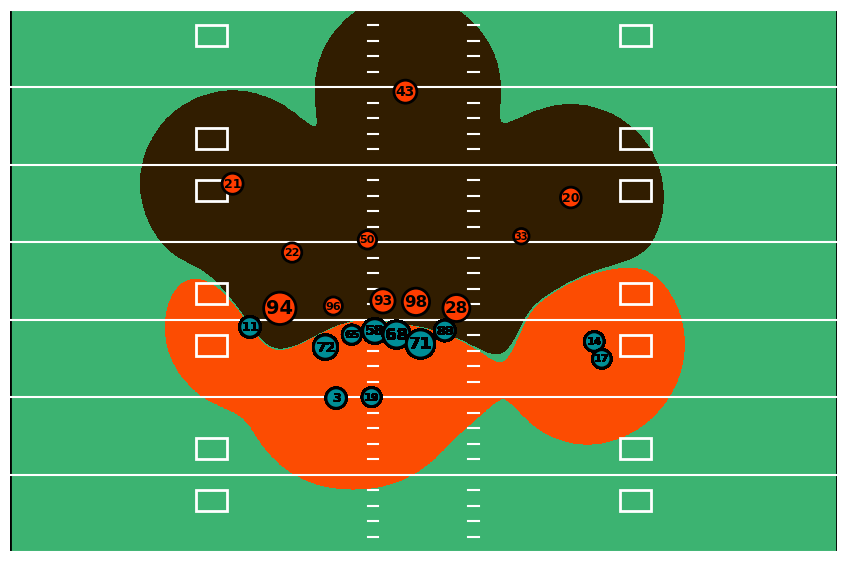

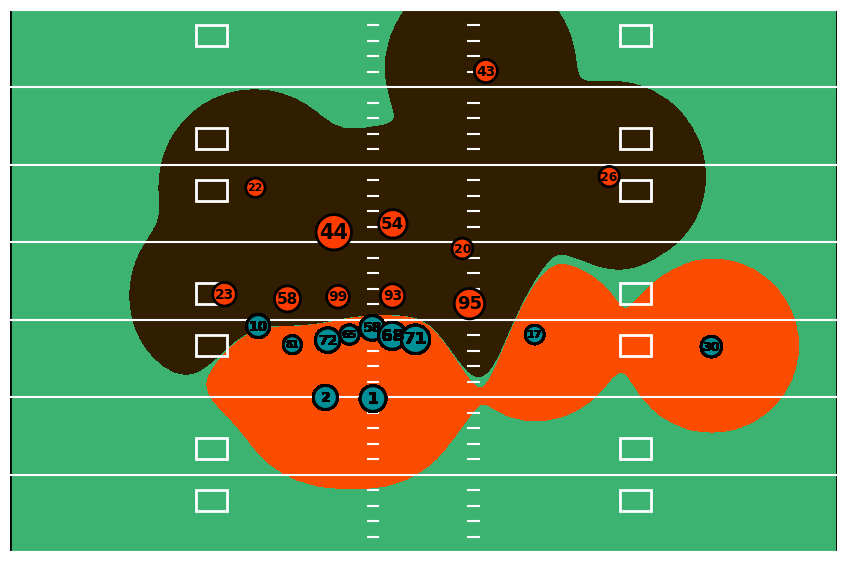

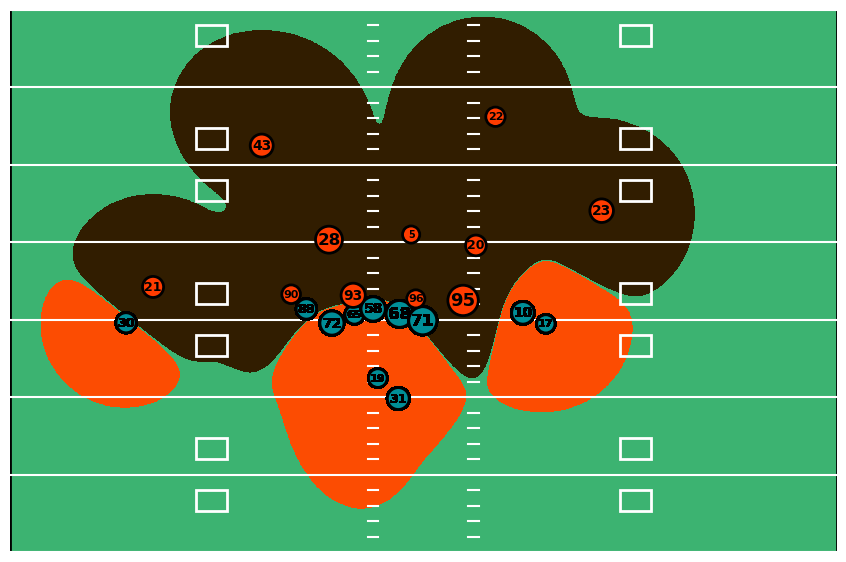

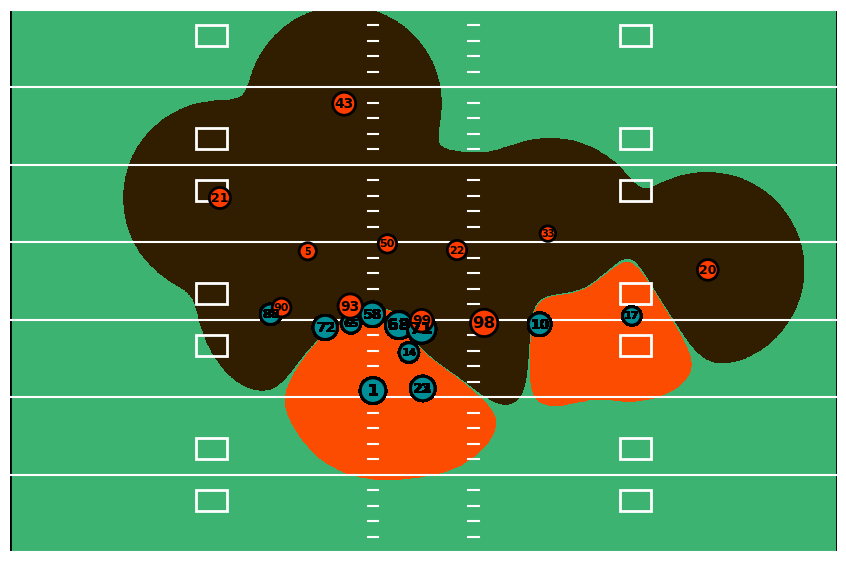

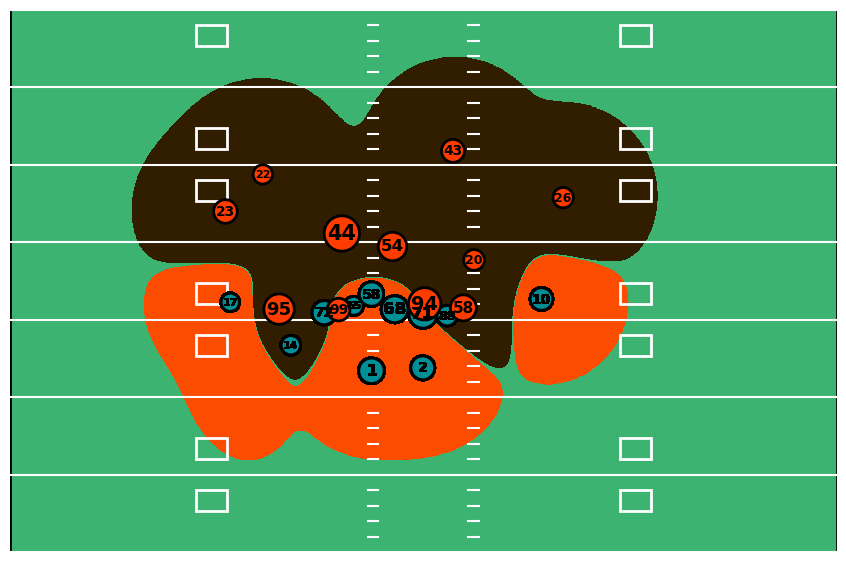

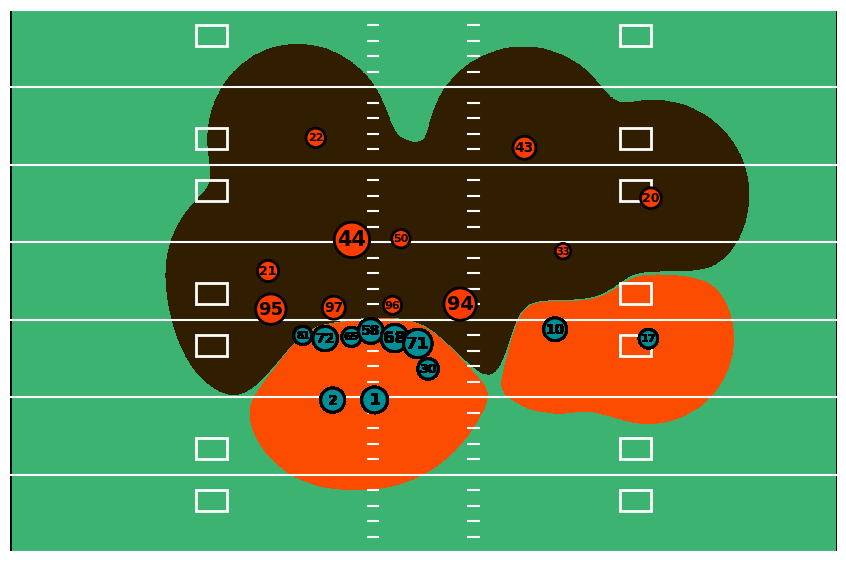

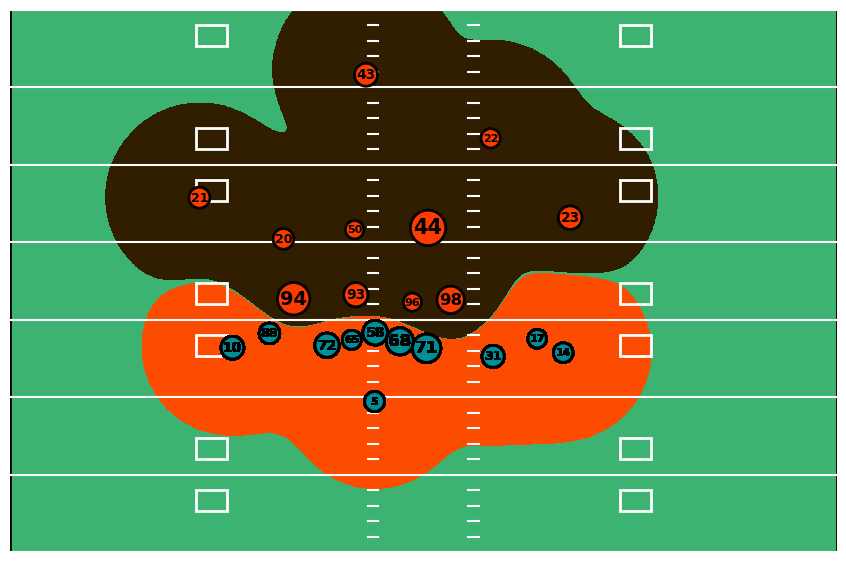

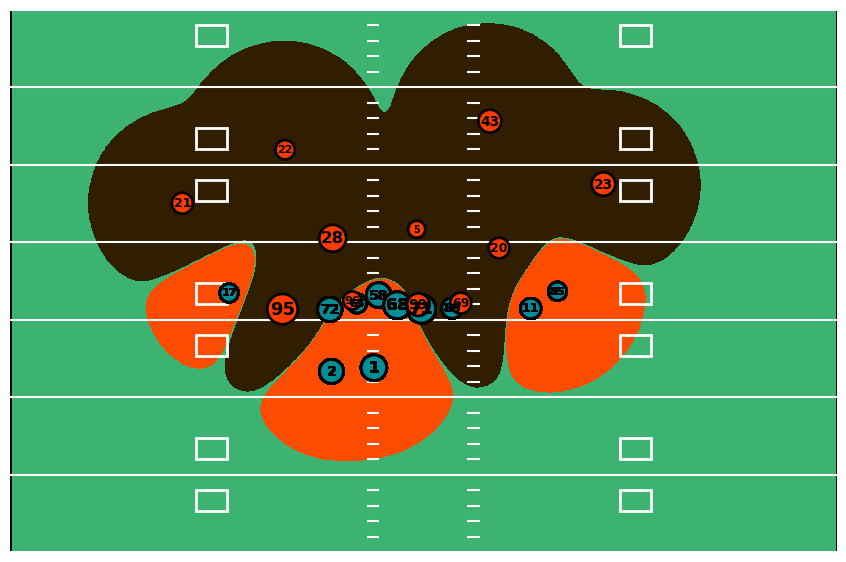

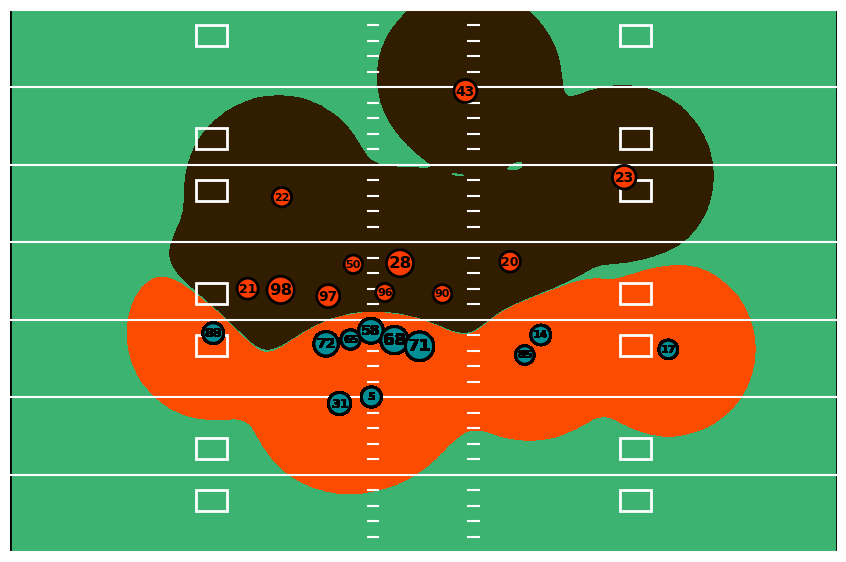

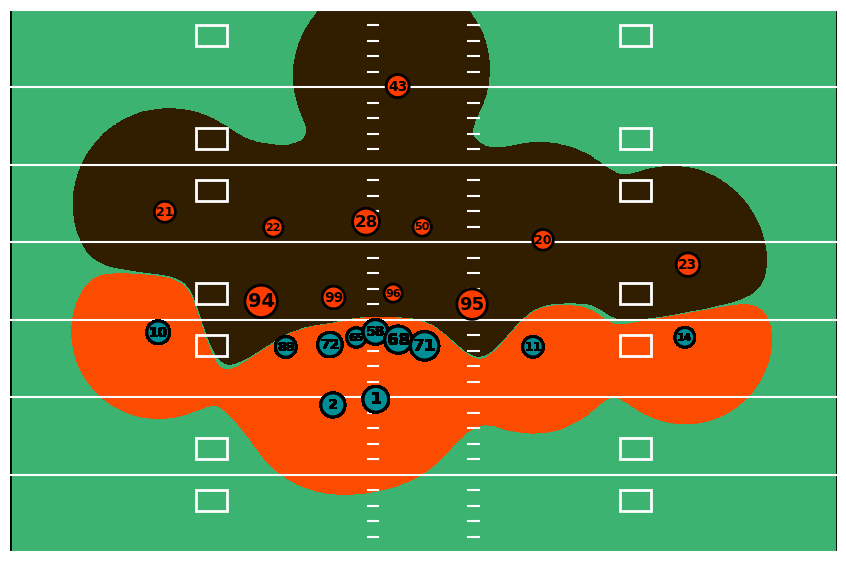

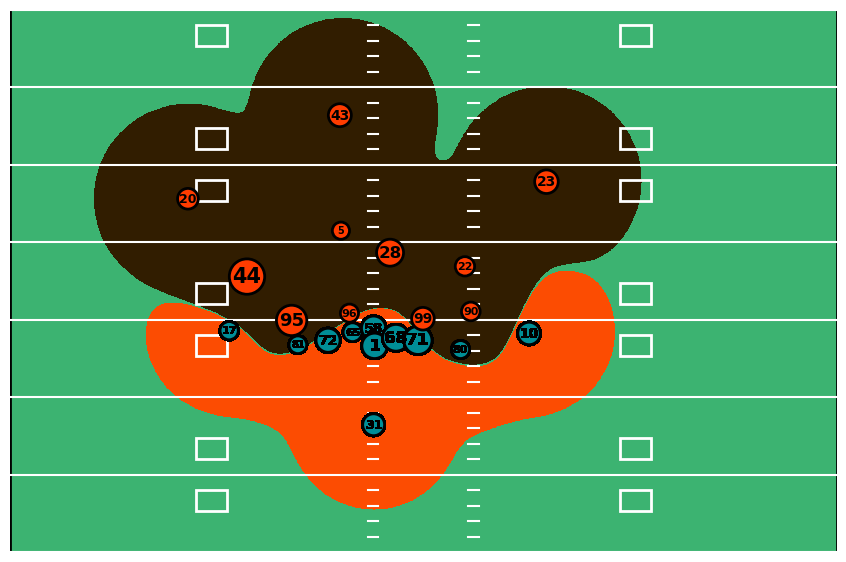

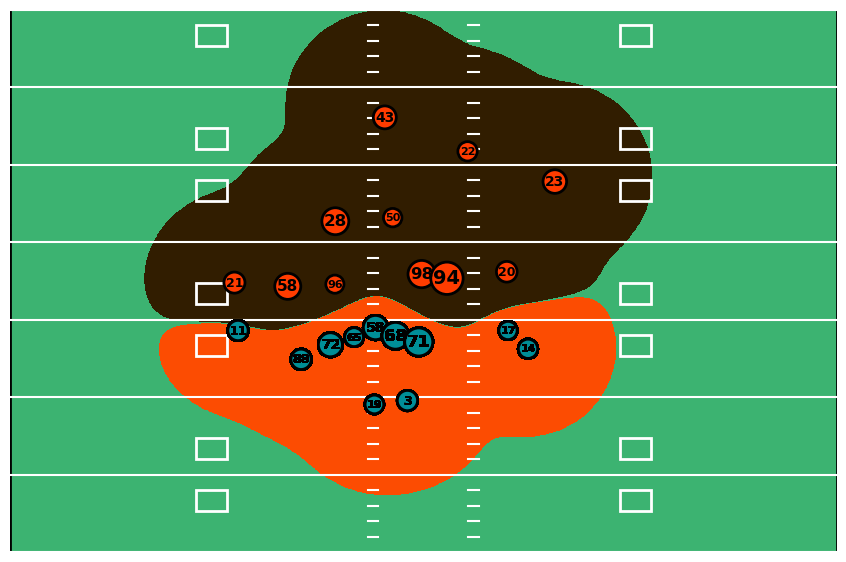

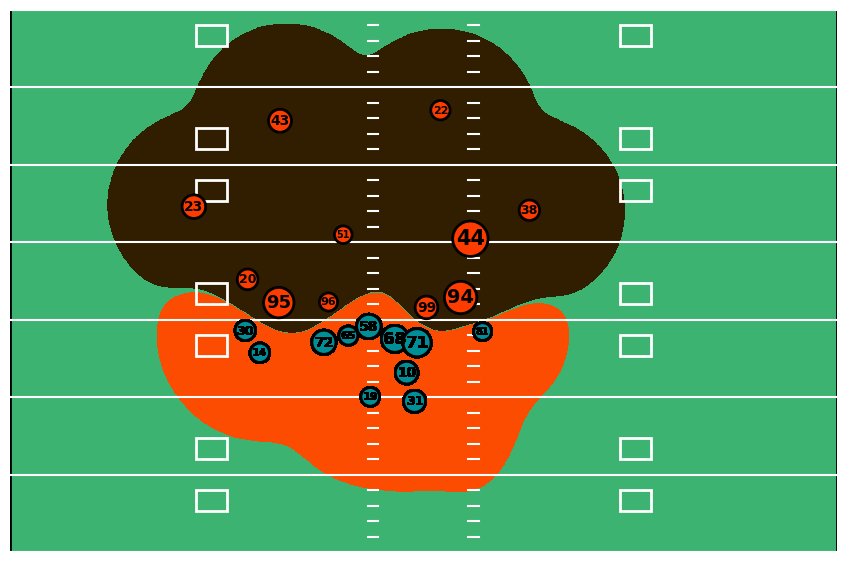

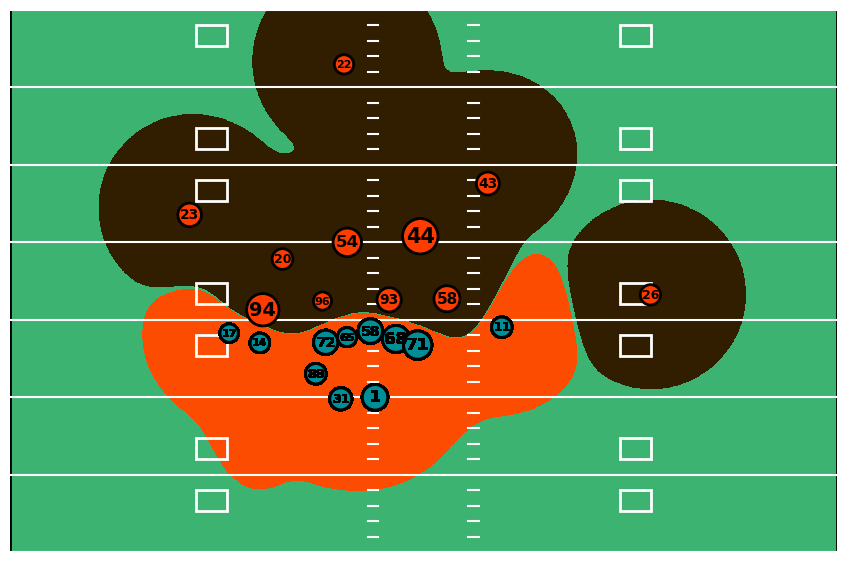

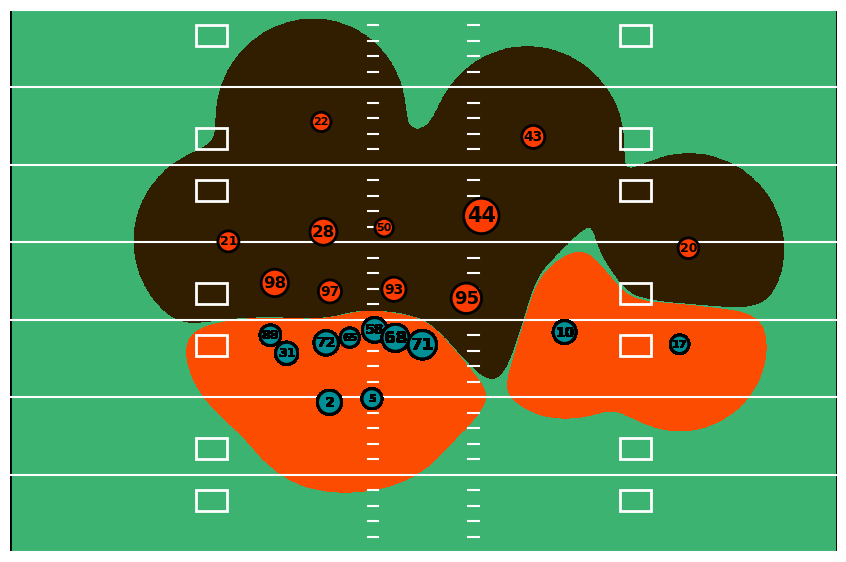

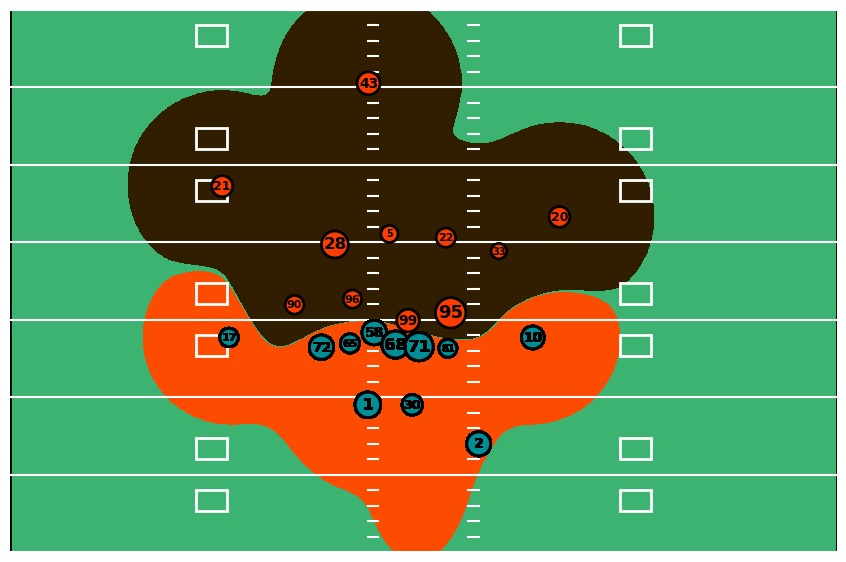

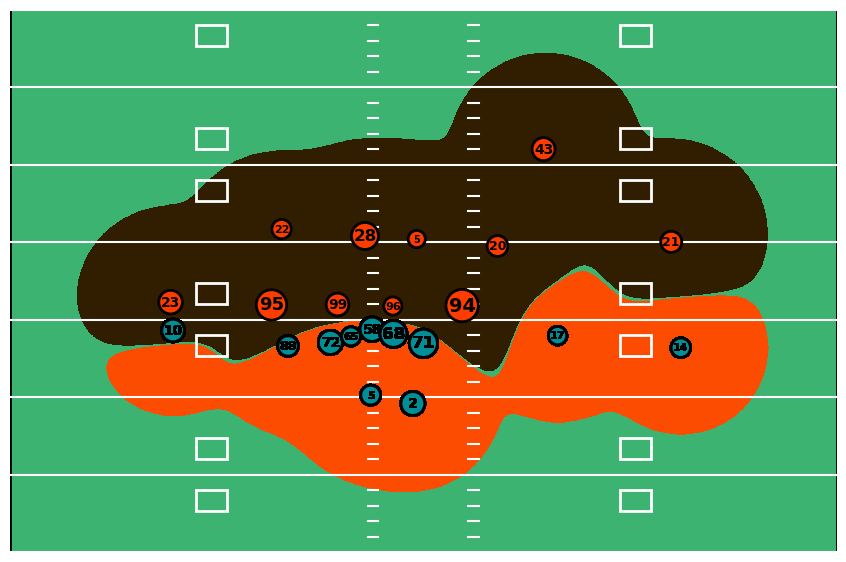

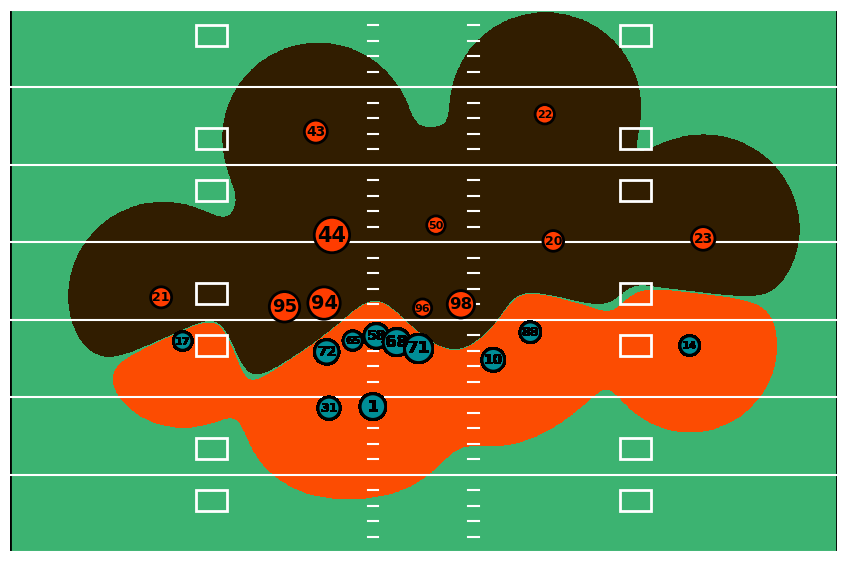

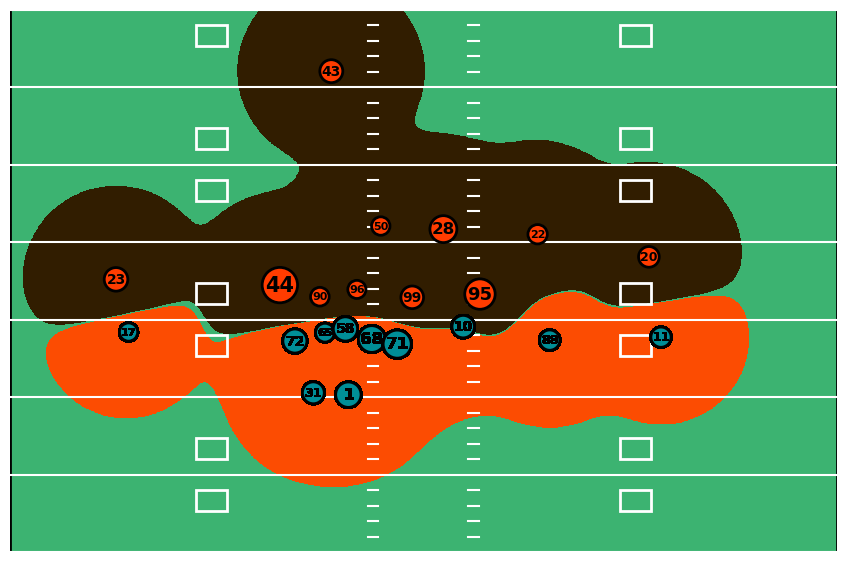

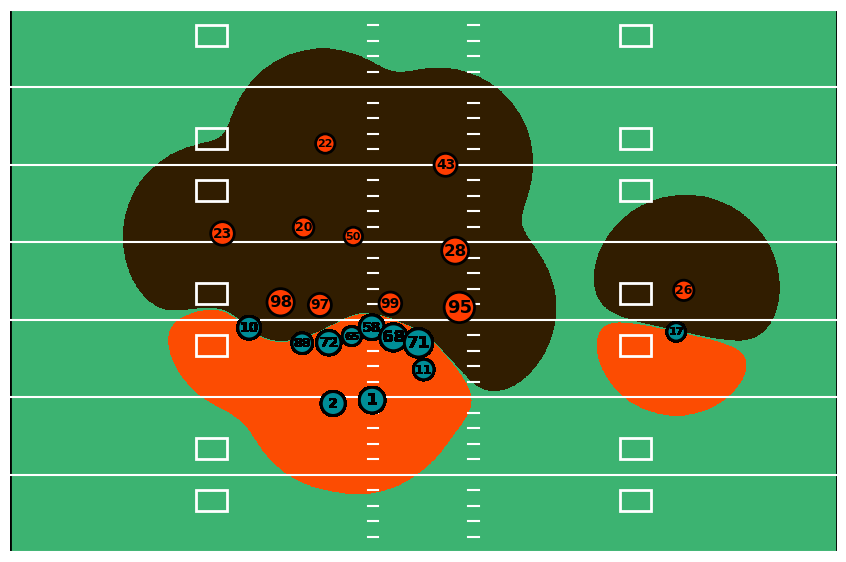

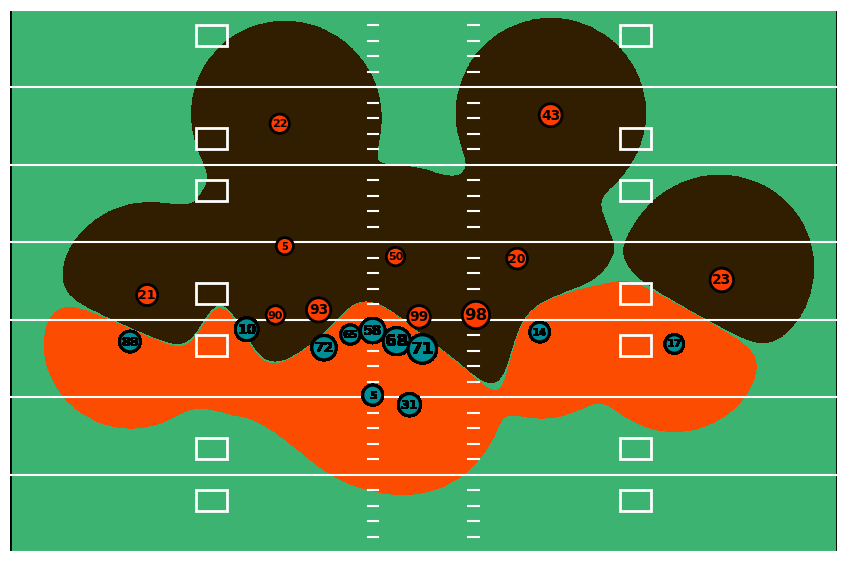

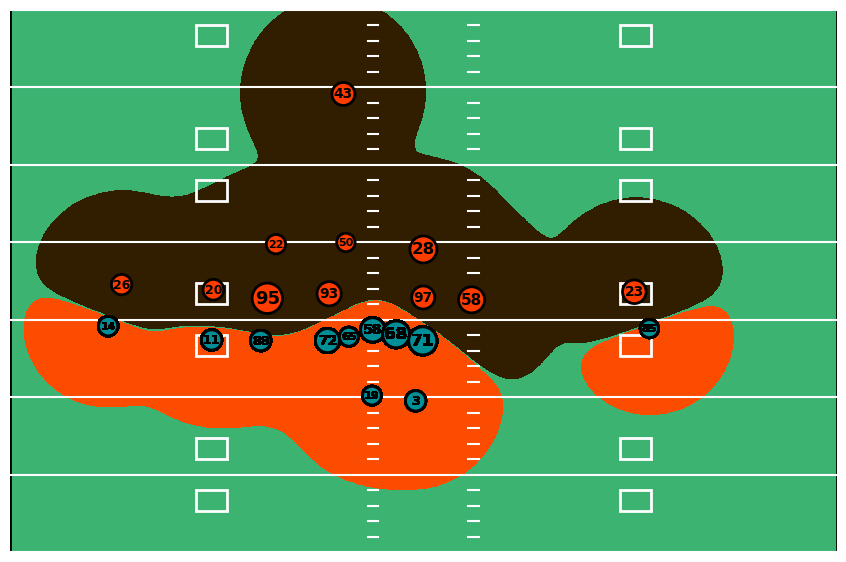

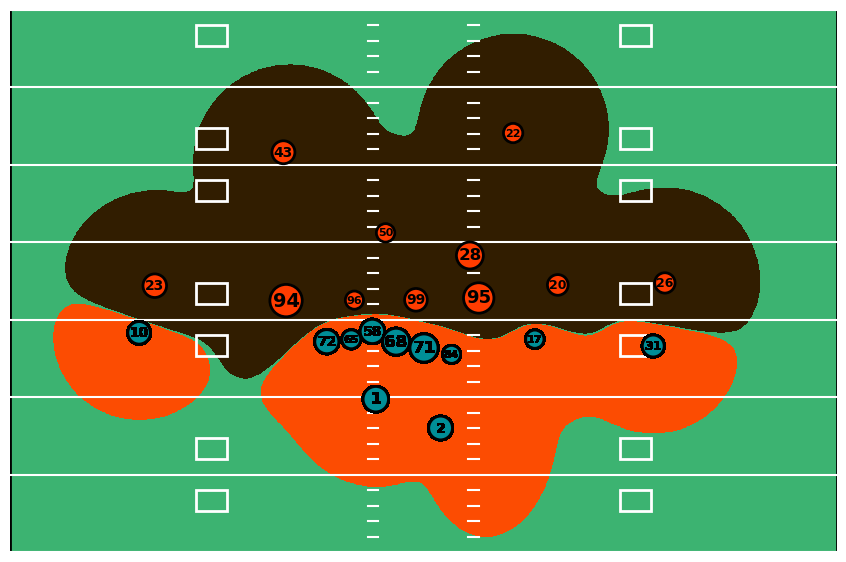

In [278]:
#5 best
var = 'Mean'
ofdf = pd.DataFrame(offensive_formations)
ofdf = ofdf.sort_values(by = 'Mean', ascending=False).reset_index(drop=True)
for hdx, h in enumerate(ofdf_mean['O_Label']):
    offensive_play = list(predicted_plays.loc[(predicted_plays['O_Label'] == h)]['PlayIdO'].drop_duplicates())[0]
    playlistD = list(predicted_plays.loc[(predicted_plays['O_Label'] == h)]['PlayIdD'].drop_duplicates())
    for idx, i in enumerate(playlistD):
        def_label = predicted_plays.loc[(predicted_plays['PlayIdD'] == i)]['D_Label'].iloc[0]
        snapo = predicted_plays.loc[(predicted_plays['PlayIdO'] == offensive_play) & (predicted_plays['PossessionTeam'] == offense) & (predicted_plays['IsOnOffense'] == True)].reset_index(drop=True)
        snapo = snapo.sort_values(by = 'Y').reset_index(drop=True)
        pos_pl = 0
        for jdx, j in enumerate(snapo['Position']):
            if (j in ['T', 'G', 'C']):
                if pos_pl == 0:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Terron Armstead')]['nflId'].iloc[0]
                elif pos_pl == 1:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Robert Jones')]['nflId'].iloc[0]
                elif pos_pl == 2:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Connor Williams')]['nflId'].iloc[0]
                elif pos_pl == 3:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Robert Hunt')]['nflId'].iloc[0]
                elif pos_pl == 4:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Brandon Shell')]['nflId'].iloc[0]
                pos_pl+=1
        snapo = pd.merge(snapo, player_number, how = 'left', on = 'NflId').reset_index(drop=True)
        snapd = predicted_plays.loc[(predicted_plays['PlayIdD'] == i) & (predicted_plays['DefensiveTeam'] == defense) & (predicted_plays['IsOnOffense'] == False)].reset_index(drop=True)
        snapd = pd.merge(snapd, player_number, how = 'left', left_on = ['PlayIdD', 'NflId'], right_on = ['PlayId', 'NflId']).reset_index(drop=True)
        snap = pd.concat([snapo, snapd]).reset_index(drop=True)
        snap = pd.merge(snap, player_space[['NflId', 'Space Factor Adj']], how = 'left', on = 'NflId').reset_index(drop=True)
        
        
        field_width = 53.33  # NFL field width
        field_length = 120  # View range: -20 to 20
        hashmark_to_sideline = 23.42  # NFL official hash mark distance from sideline
        hashmark_width = .67  # hashmark length
        number_to_sideline = 12  # NFL official hash mark distance from sideline
        number_width = 2  # hashmark length
    
        fig, ax = bdb.plt.subplots(figsize=(field_width/5, field_length/7.5))
    
        overlay_image = ppdict[i][:, :, 3]
        overlay_image = np.rot90(overlay_image)
        overlay_image = np.flip(overlay_image, axis=1)
        
        custom_cmap = ListedColormap(["#311D00", "mediumseagreen", "#FC4C02"])
        x_min, x_max, y_min, y_max = -field_width/2, field_width/2, -field_length/2, field_length/2
        ax.imshow(overlay_image, cmap=custom_cmap, extent=[x_min, x_max, y_min, y_max], zorder = 5)
    
        # Main field (excluding end zones)
        ax.add_patch(bdb.patches.Rectangle(
            (-field_width/2, -field_length/2), field_width, field_length,
            linewidth=2, edgecolor='black', facecolor='none', zorder=9))
        
        for idx, row in snap.iterrows():
            x_draw = row['X'] - (field_length / 2)# - 50
            y_draw = row['Y'] - (field_width / 2)
            #y_draw_d = 53.33 - row['Y'] - (field_width / 2)
            pos = row['Position']
            team = row['PossessionTeam']
            size = row['Space Factor Adj']
            jersey_number = int(row['JerseyNumber'])
            if team == offense:
                if pos in ['T', 'G', 'C']:
                    ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .5 + size, facecolor='#008E97', edgecolor='black', lw=2)).set_zorder(10)
                    ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=int(7 + 14*size), zorder=11, weight='bold')
                else:
                    ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .5 + size, facecolor='#008E97', edgecolor='black', lw=2)).set_zorder(10)
                    ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=int(7 + 14*size), zorder=11, weight='bold')
            else:
                if pos in ['DT', 'DE', 'NT']:
                    ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .5 + size, facecolor='#FF3C00', edgecolor='black', lw=2)).set_zorder(10)
                    ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=int(7 + 14*size), zorder=11, weight='bold')
                else:
                    ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .5 + size, facecolor='#FF3C00', edgecolor='black', lw=2)).set_zorder(10)   
                    ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=int(7 + 14*size), zorder=11, weight='bold')
            
        for yard in range(int((-field_length/2)), int((field_length/2)), 1):
            linestyle = '-' #if yard % 10 == 0 else '--'
            y_position = yard
            if yard % 5 == 0:
                ax.plot([-field_width/2, field_width/2], [y_position, y_position], color='white', linestyle=linestyle, zorder=9)
            else:
                ax.plot([-field_width/2 + hashmark_to_sideline - hashmark_width/2, -field_width/2 + hashmark_to_sideline + hashmark_width/2], [y_position, y_position], color='white', linestyle=linestyle, zorder=9)
                ax.plot([field_width/2 - hashmark_to_sideline + hashmark_width/2, field_width/2 - hashmark_to_sideline - hashmark_width/2], [y_position, y_position], color='white', linestyle=linestyle, zorder=9)
    
            number_offset = number_width / 2  # Half the height of the number box
    
            if (yard % 10 == 0) & (yard != int(-field_length/2)) & (yard != int((field_length/2))):
                # Left numbers
                ax.add_patch(bdb.patches.Rectangle(
                    (-field_width/2 + number_to_sideline, y_position + number_offset), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
                ax.add_patch(bdb.patches.Rectangle(
                    (-field_width/2 + number_to_sideline, y_position - number_offset - number_width/1.5), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
                
                # Right numbers
                ax.add_patch(bdb.patches.Rectangle(
                    (field_width/2 - number_to_sideline - number_width, y_position + number_offset), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
                ax.add_patch(bdb.patches.Rectangle(
                    (field_width/2 - number_to_sideline - number_width, y_position - number_offset - number_width/1.5), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
    
        ax.set_xlim(-field_width/2, field_width/2)
        ax.set_ylim(-field_length/2, field_length/2)
        bdb.plt.gca().set_facecolor('green')
        bdb.plt.axis('off')
        #bdb.plt.title(str(i))
        bdb.plt.ylim(-15, 20) 
        bdb.plt.savefig(prefix + '/testfig/best/testfig-O' + str(h) + '-D' + str(def_label) + '-' + str(i)+  '.jpg', bbox_inches="tight", pad_inches = 0, dpi = 600)
        bdb.plt.show()

In [279]:
ofdf_mean

O_Label  \
0        35   
1        16   
2        10   
3         9   
4        34   
5        45   
6        21   
7        42   
8        17   
9         7   
10       13   
11        5   
12        8   
13       23   
14       38   
15       40   
16       15   
17       27   
18        3   
19       33   
20       29   
21       24   
22       19   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Prediction  \
0   [[1.5066088e-05, 2.204655e-05, 2.0948295e-05, 1.7892873e-05, 3.244099e-05, 2.3010381e-05, 2.0689338e-05, 1.8165912e-05, 2.8852568e-05, 2.0947913e-05, 1.8254968e-05, 2.306016e-05, 2.8076567e-05, 2.9893052e-05, 2.324683e-05, 1.590569e-05, 2.2407125e-05, 2.5894891e-05, 2.5094958e-05, 1.53274e-05, 1.6572523e-05, 2.1300943e-05, 2.564449e-05, 1.7270737e-05, 1.8161789e-05, 2.0683141e-05, 1.6028149e-05, 2.3413008e-05, 1.7100223e-05, 1.963821e-05, 2.5116455e-05, 2.52511e-05, 1.6098478e-05, 1.715162e-...   
1   [[2.0056319e-05, 2.6547586e-05, 2.0361595e-05, 2.143868e-05, 3.2782893e-05, 3.779811e-05, 2.3114599e-05, 2.5602441e-05, 4.019898e-05, 2.1474161e-05, 2.632979e-05, 2.2736933e-05, 2.8952913e-05, 2.7364476e-05, 2.6678117e-05, 2.4099276e-05, 2.7760356e-05, 3.162547e-05, 2.6894664e-05, 1.9001987e-05, 1.944185e-05, 2.0798112e-05, 2.7388469e-05, 2.1242933e-05, 2.0285655e-05, 2.2496657e-05, 2.1114436e-05, 2.6504404e-05, 2.0228299e-05, 2.3256642e-05, 2.288831e-05, 2.8104334e-05, 1.7873062e-05, 2.0771...   
2   [[8.829103e-06, 1.3956814e-05, 1.15828925e-05, 1.3739542e-05, 1.4663487e-05, 1.6313337e-05, 1.2473207e-05, 1.4641925e-05, 2.3656177e-05, 1.6774517e-05, 1.5578238e-05, 1.4079243e-05, 1.8236964e-05, 2.0451991e-05, 1.4899915e-05, 1.48377785e-05, 1.5785998e-05, 1.8101862e-05, 1.6004891e-05, 1.2861653e-05, 1.2487466e-05, 1.453814e-05, 1.2754907e-05, 1.4063193e-05, 1.1781925e-05, 1.43891975e-05, 1.660637e-05, 2.0266472e-05, 1.3897099e-05, 1.1934286e-05, 1.9011757e-05, 2.0702173e-05, 1.0968586e-05,...   
3   [[1.3914174e-05, 2.0087555e-05, 1.3606858e-05, 1.7753697e-05, 2.5141906e-05, 3.0337518e-05, 1.5601485e-05, 2.0851743e-05, 2.6043634e-05, 1.4981939e-05, 1.7683757e-05, 1.7517666e-05, 2.5847889e-05, 2.5281503e-05, 2.263386e-05, 1.5270834e-05, 1.9173254e-05, 2.4699439e-05, 2.1229696e-05, 1.3150954e-05, 1.3955051e-05, 1.4942271e-05, 1.7972294e-05, 1.7914317e-05, 1.4897339e-05, 1.7193544e-05, 1.3433247e-05, 2.172341e-05, 1.5557818e-05, 1.943628e-05, 1.6270233e-05, 2.45366e-05, 1.3519239e-05, 1.54...   
4   [[7.995312e-06, 1.0960099e-05, 1.3304283e-05, 1.35104965e-05, 1.5280548e-05, 1.2083182e-05, 1.0944661e-05, 1.107959e-05, 2.0603782e-05, 1.2580876e-05, 1.0010549e-05, 1.3556496e-05, 1.7885037e-05, 1.6378068e-05, 1.2378458e-05, 8.617296e-06, 1.3223088e-05, 1.8703719e-05, 1.5753925e-05, 9.829031e-06, 9.425121e-06, 1.3178836e-05, 1.4321928e-05, 1.2099395e-05, 8.537735e-06, 1.2535006e-05, 9.781229e-06, 1.5858343e-05, 9.161191e-06, 1.24626295e-05, 1.8373748e-05, 1.5919257e-05, 9.909107e-06, 8.8677...   
5   [[1.6066957e-05, 1.8957391e-05, 1.5719917e-05, 1.655961e-05, 2.5798652e-05, 2.483487e-05, 1.9319867e-05, 1.836534e-05, 2.981006e-05, 1.7247852e-05, 1.889613e-05, 1.6518728e-05, 2.2916627e-05, 2.1081727e-05, 1.999876e-05, 1.7604867e-05, 2.021024e-05, 2.2961232e-05, 2.1398935e-05, 1.3972945e-05, 1.4596758e-05, 1.604073e-05, 2.1122862e-05, 1.5747166e-05, 1.5083983e-05, 1.7203907e-05, 1.5157426e-05, 1.8650193e-05, 1.5524749e-05, 1.8389788e-05, 1.898853e-05, 2.5119829e-05, 1.310719e-05, 1.5288564...   
6   [[1.0373604e-05, 1.4056889e-05, 1.4790307e-05, 1.286429e-05, 2.0560568e-05, 1.4272685e-05,

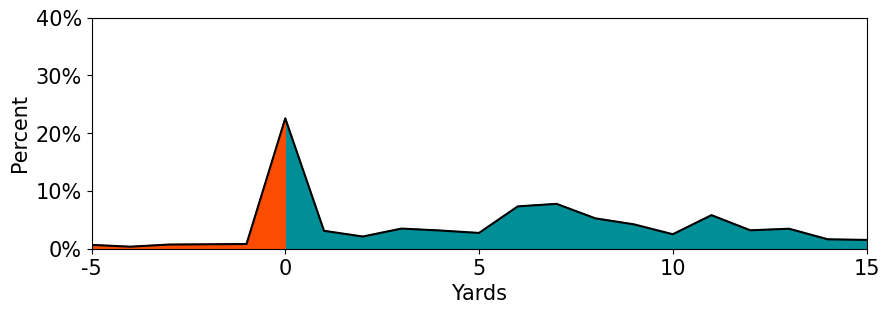

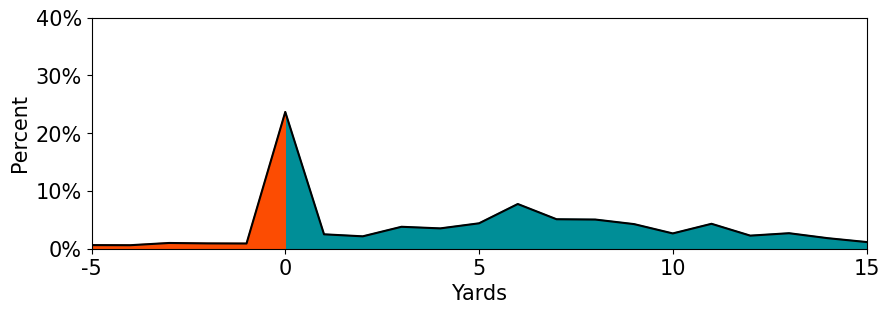

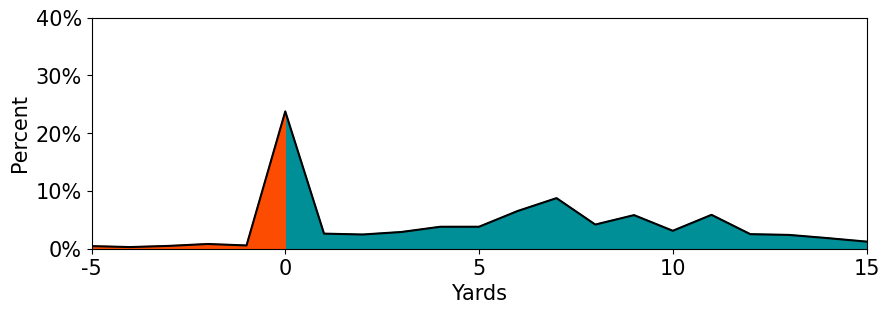

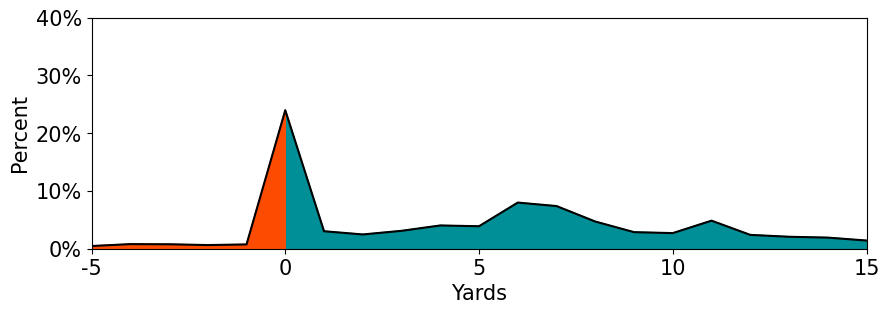

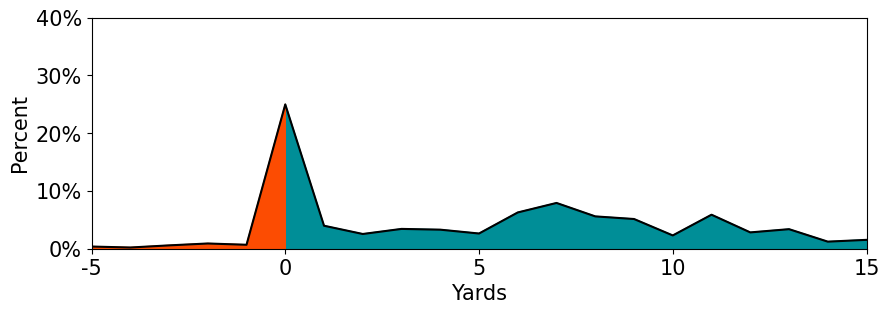

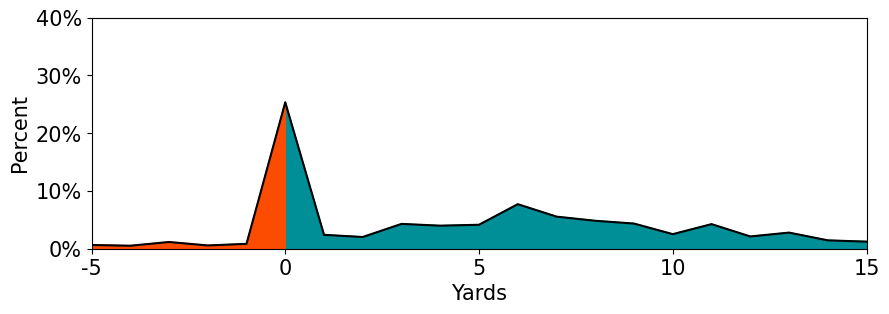

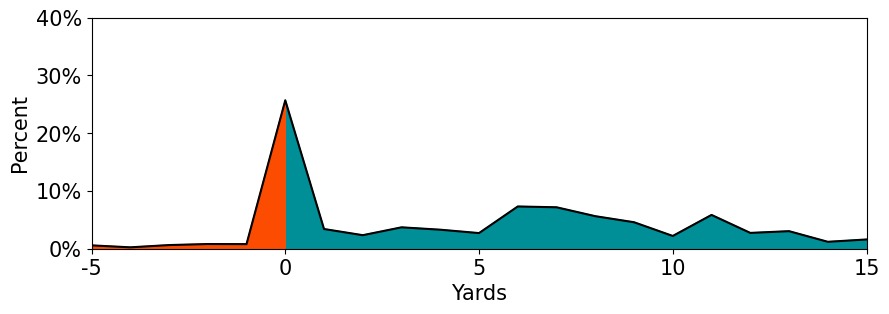

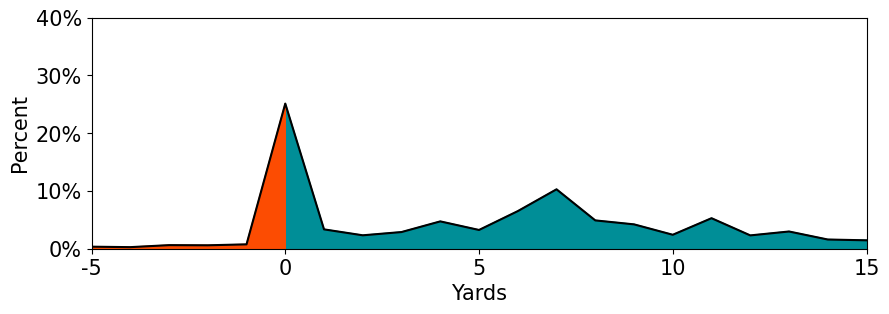

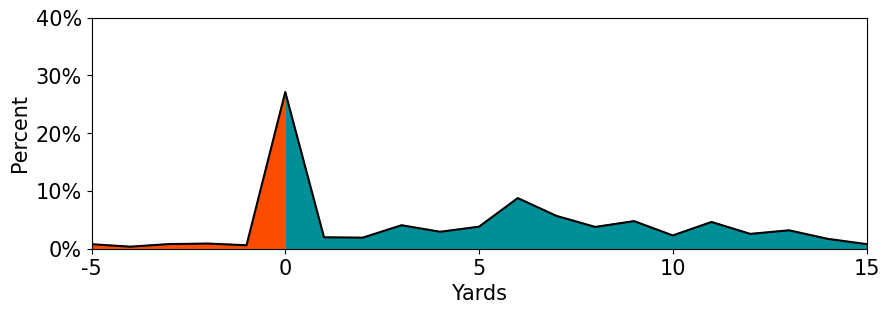

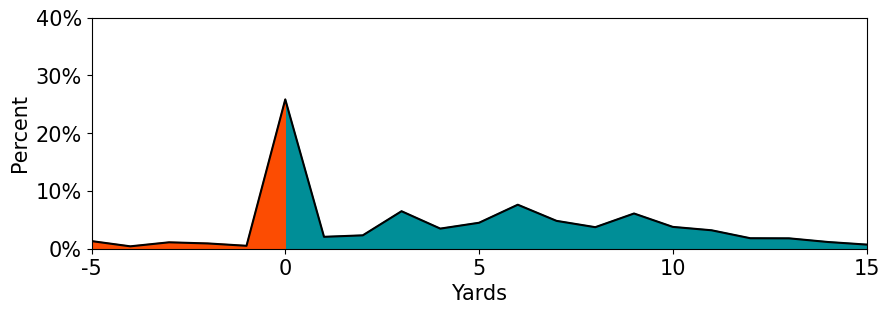

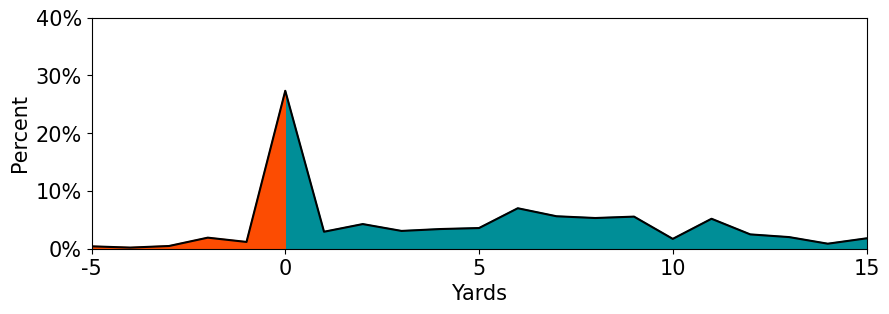

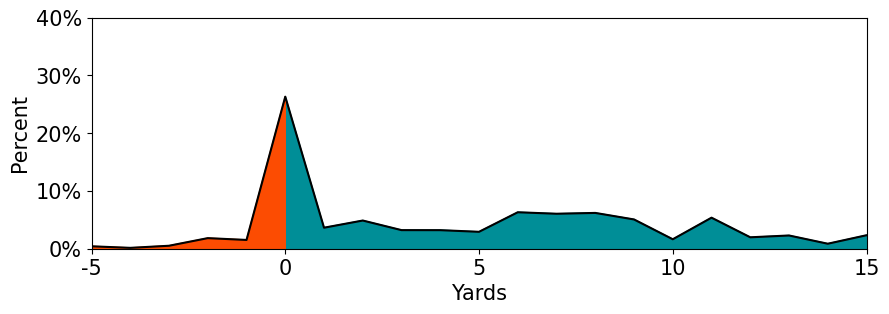

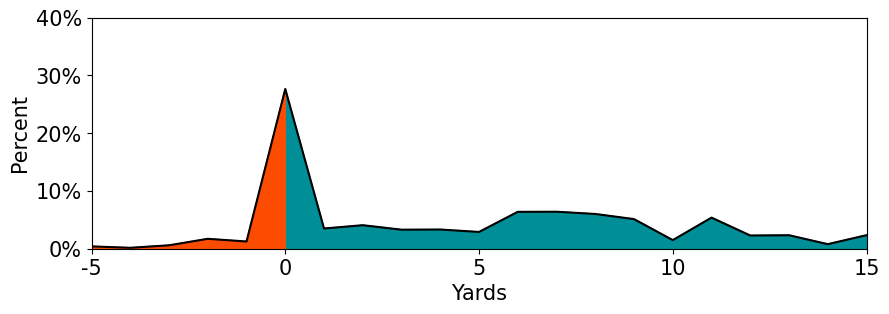

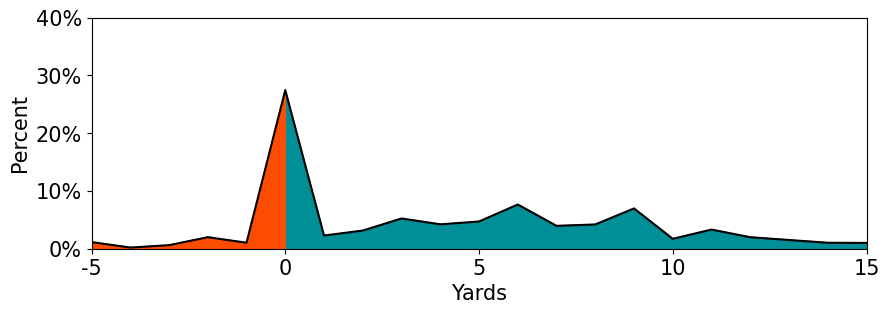

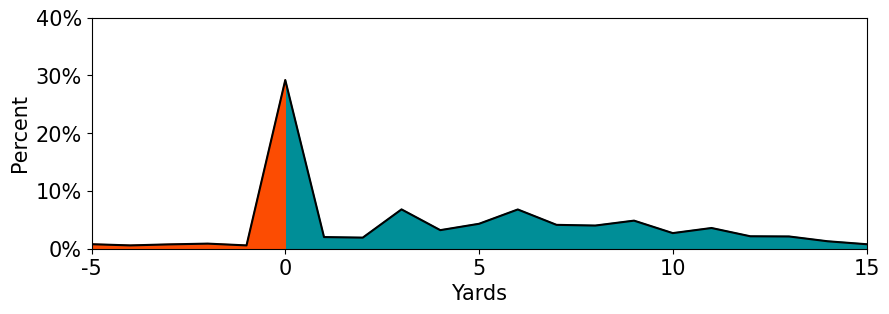

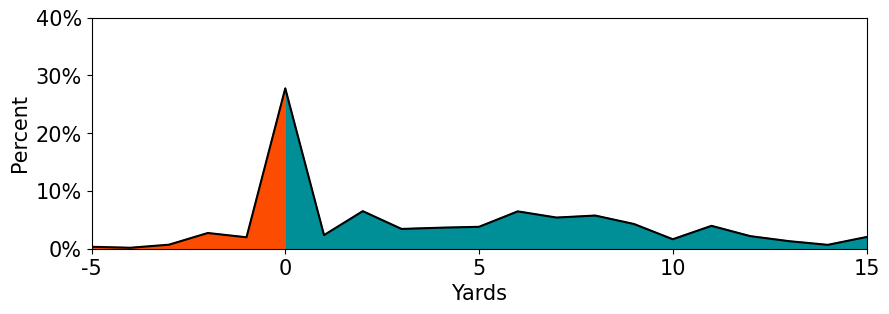

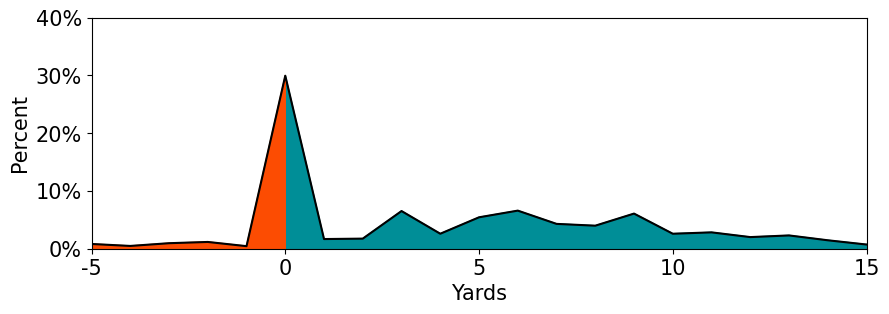

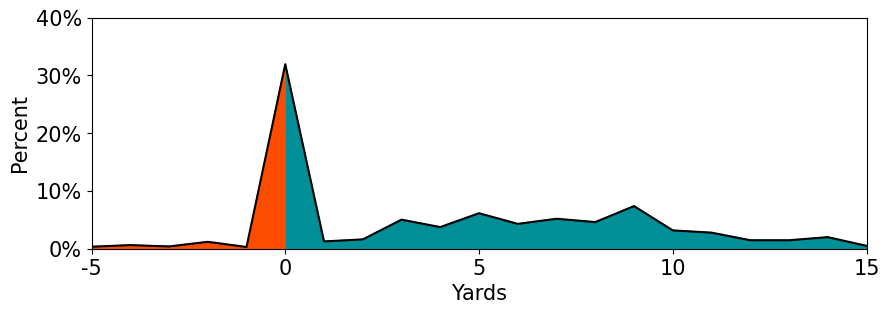

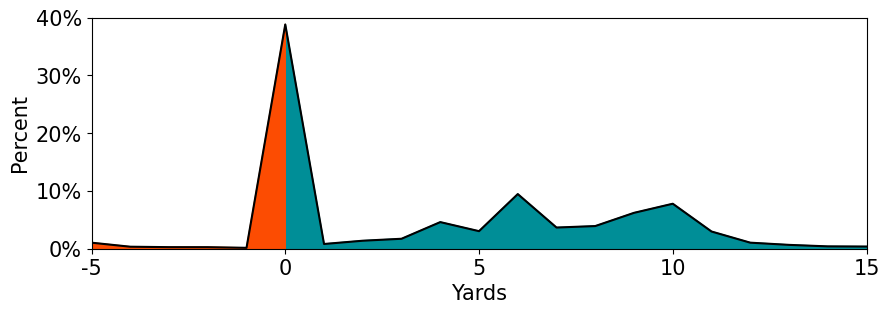

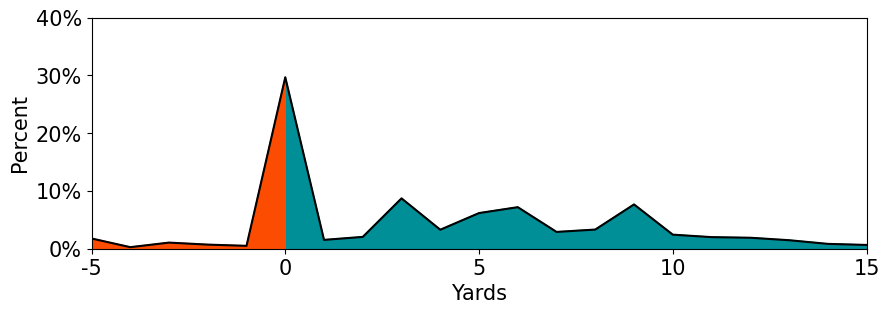

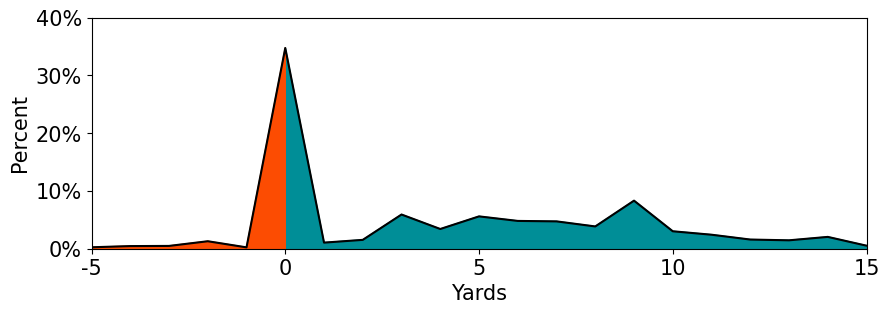

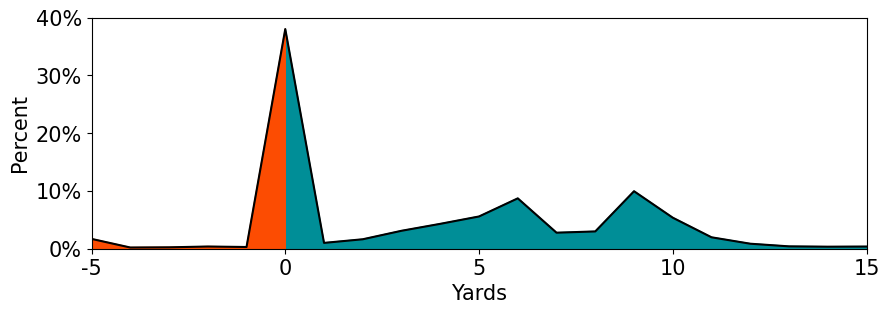

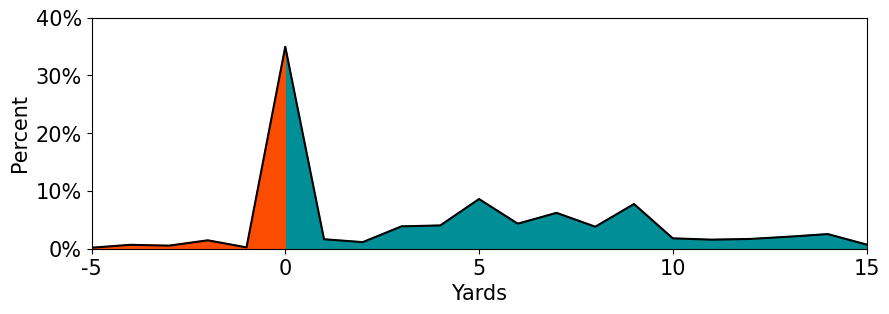

In [300]:
for i in range(len(ofdf_mean)):  
    bdb.plt.figure(figsize=(10, 3))  # Optional: Set figure size01
    bdb.plt.ylim([0, .4])
    bdb.plt.xlim([94, 114])
    new_x_ticks = [94, 99, 104, 109, 114]
    new_x_labels = [-5, 0, 5, 10, 15]
    new_y_ticks = [0, .1, .2, .3, .4]
    new_y_labels = ['0%', '10%', '20%', '30%', '40%']
    plt.xlabel("Yards", fontsize=15)  # X-axis label font size
    plt.ylabel("Percent", fontsize=15)  # Y-axis label font size
    plt.xticks(fontsize=15)  # X-tick labels font size
    plt.yticks(fontsize=15)
    bdb.plt.xticks(new_x_ticks, new_x_labels)
    bdb.plt.yticks(new_y_ticks, new_y_labels)
    y_values = ofdf_mean['Prediction'].iloc[i][0].reshape(-1,)
    x_values = np.array(range(len(y_values)))
    bdb.plt.plot(x_values, y_values, color='black')
    bdb.plt.fill_between(x_values, y_values, 0, where=(x_values >= 99), alpha=1, color='#008E97')
    bdb.plt.fill_between(x_values, y_values, 0, where=(x_values <= 99), alpha=1, color='#FC4C02')# alpha controls the transparency
    bdb.plt.savefig(prefix + '/testfig/line_charts/testfig-O-' + str(ofdf_mean['O_Label'].iloc[i]) + '-D' + '-' + str(i)+  '.jpg', bbox_inches="tight", pad_inches = 0, dpi = 600)
    bdb.plt.show()

In [322]:
play_stats1=pd.read_csv('nfl-big-data-bowl-2025/plays.csv')
play_stats1['playId'] = play_stats1['gameId'].astype(str) + play_stats1['playId'].astype(str).str.zfill(4)
play_stats1['playId'] = play_stats1['playId'].astype('int64')

In [326]:
predicted_plays_w_coverage = pd.merge(predicted_plays, play_stats1[['playId', 'pff_passCoverage']], how = 'left', left_on = 'PlayIdD', right_on = 'playId').reset_index(drop=True)

In [376]:
predicted_plays_w_coverage.loc[(predicted_plays_w_coverage['O_Label'] == 21)].reset_index(drop=True)

GameId          PlayId  Team          X          Y     S     A   Dis  \
0   2022100201  20221002010749  away  75.789999  22.970000  0.70  0.37  0.07   
1   2022100201  20221002010749  away  61.269999  28.430000  0.11  0.93  0.01   
2   2022100201  20221002010749  away  67.859999  12.220000  0.03  0.04  0.02   
3   2022100201  20221002010749  away  65.909999  26.970000  0.33  0.72  0.04   
4   2022100201  20221002010749  away  71.689999  31.010000  0.49  3.77  0.07   
5   2022100201  20221002010749  away  61.119999  25.960000  0.16  1.29  0.02   
6   2022100201  20221002010749  away  65.789999  22.230000  0.62  0.96  0.07   
7   2022100201  20221002010749  away  65.199999  17.640000  0.10  0.08  0.01   
8   2022100201  20221002010749  away  61.599999  22.310000  0.09  0.75  0.01   
9   2022100201  20221002010749  away  66.569999  36.140000  2.32  1.73  0.24   
10  2022100201  20221002010749  away  61.339999  18.300000  0.11  1.14  0.02   
11  2022101604  20221002010749  home  54.710001  23.520001  0.00  0.00  0.01   
12  2022101604  20221002010749  home  57.620001  31.170001  0.01  0.01  0.01   
13  2022101604  20221002010749  home  58.340001  20.450001  0.00  0.00  0.01   
14  2022101604  20221002010749  home  58.180001  14.350001  0.51  0.50  0.06   
15  2022101604  20221002010749  home  59.100001  16.740001  0.11  1.26  0.01   
16  2022101604  20221002010749  home  59.150001  23.560001  0.75  2.08  0.09   
17  2022101604  20221002010749  home  57.860001  35.690001  0.06  0.62  0.01   
18  2022101604  20221002010749  home  58.140001  26.880001  0.48  1.84  0.05   
19  2022101604  20221002010749  home  58.690001  22.050001  0.40  1.40  0.05   
20  2022101604  20221002010749  home  58.760001  34.010001  0.01  0.21  0.01   
21  2022101604  20221002010749  home  58.590001  25.150001  0.47  1.35  0.04   

         Dir    NflId Position  YardLine  Quarter  GameClock PossessionTeam  \
0  -0.131249  44903.0       SS        35        1   0.133537            ATL   
1  -2.646617  45038.0       DE        35        1   0.133537            ATL   
2  -0.837933  46073.0       CB        35        1   0.133537            ATL   
3  -1.058019  47863.0      OLB        35        1   0.133537            ATL   
4  -0.381354  52452.0       SS        35        1   0.133537            ATL   
5  -3.149796  52496.0       DT        35        1   0.133537            ATL   
6  -1.254368  52505.0      MLB        35        1   0.133537            ATL   
7  -1.752660  53455.0       CB        35        1   0.133537            ATL   
8  -2.911733  53561.0       DT        35        1   0.133537            ATL   
9   0.493230  54533.0       CB        35        1   0.133537            ATL   
10 -3.099356  54543.0       DE        35        1   0.133537            ATL   
11 -7.526383  41258.0       QB        42        4   0.267074            MIA   
12 -6.761580  42718.0       RB        42        4   0.267074            MIA   
13 -2.710322  43447.0        T        42        4   0.267074            MIA   
14 -4.864407  43454.0       WR        42        4   0.267074            MIA   
15 -6.283883  46111.0       TE        42        4   0.267074            MIA   
16 -2.509260  46119.0        C        42        4   0.267074            MIA   
17 -5.549798  46671.0       WR        42        4   0.267074            MIA   
18 -3.732910  47820.0        T        42        4   0.267074            MIA   
19 -2.389181  52447.0        G        42        4   0.267074            MIA   
20 -6.268874  53435.0       WR        42        4   0.267074            MIA   
21 -3.887721  53471.0        G        42        4   0.267074            MIA   

   DefensiveTeam  Down  Distance FieldPosition  HomeScoreBeforePlay  \
0            CLE     2        14           CLE                    3   
1            CLE     2        14           CLE                    3   
2            CLE     2        14           CLE                    3   
3            CLE     2        14           CLE                   

In [339]:
play_stats1.loc[(play_stats1['playId'] == 20221002010749)]

gameId          playId  \
14752  2022100201  20221002010749   

                                                                                                      playDescription  \
14752  (2:11) (Shotgun) M.Mariota pass deep left to P.Hesse pushed ob at CLV 13 for 22 yards (M.Emerson) [I.Rochell].   

       quarter  down  yardsToGo possessionTeam defensiveTeam yardlineSide  \
14752        1     2         14            ATL           CLE          CLE   

       yardlineNumber gameClock  preSnapHomeScore  preSnapVisitorScore  \
14752              35     02:11                 3                    0   

      playNullifiedByPenalty  absoluteYardlineNumber  \
14752                      N                      75   

       preSnapHomeTeamWinProbability  preSnapVisitorTeamWinProbability  \
14752                       0.683317                          0.316683   

       expectedPoints offenseFormation receiverAlignment  playClockAtSnap  \
14752        3.036869            EMPTY               3x2              8.0   

      passResult  passLength  targetX  targetY  playAction dropbackType  \
14752          C        17.0    91.51    51.23       False     SCRAMBLE   

       dropbackDistance passLocationType  timeToThrow  timeInTackleBox  \
14752              2.22     OUTSIDE_LEFT        5.939              3.5   

       timeToSack passTippedAtLine unblockedPressure qbSpike  qbKneel qbSneak  \
14752         NaN            False             False   False        0     NaN   

      rushLocationType  penaltyYards  prePenaltyYardsGained  yardsGained  \
14752              NaN           NaN                     22           22   

       homeTeamWinProbabilityAdded  visitorTeamWinProbilityAdded  \
14752                     0.034643                     -0.034643   

       expectedPointsAdded  isDropback pff_runConceptPrimary  \
14752             2.100005        True                   NaN   

      pff_runConceptSecondary  pff_runPassOption pff_passCoverage pff_manZone  
14752                     NaN                  0          Cover-3        Zone

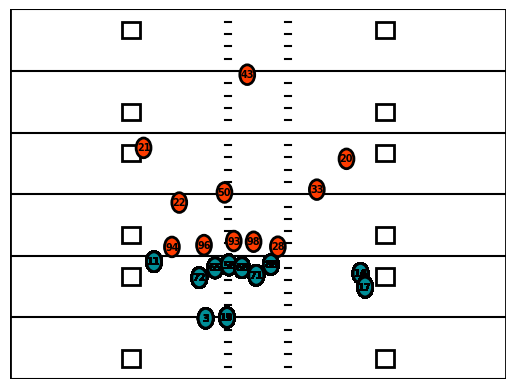

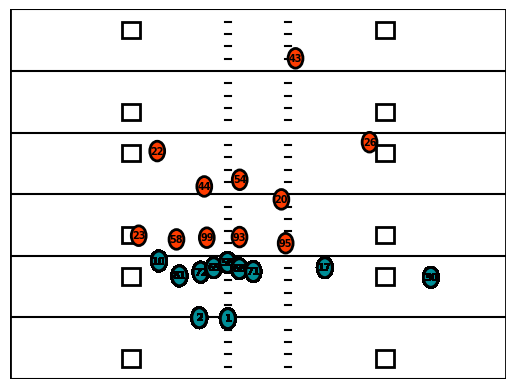

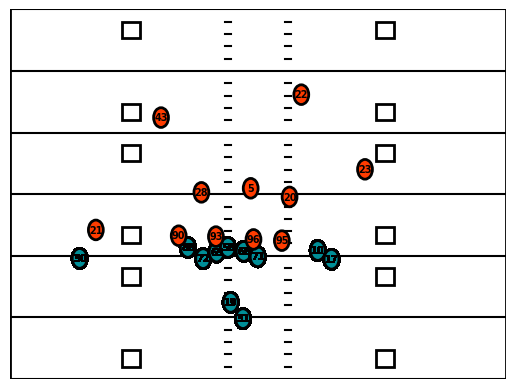

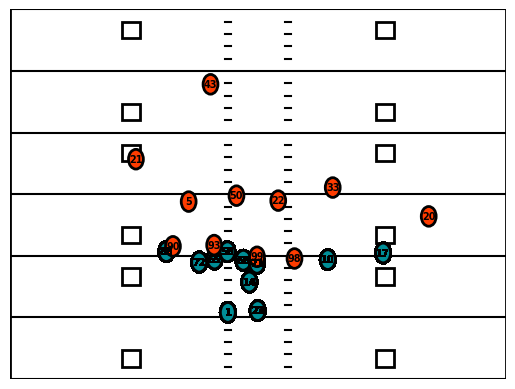

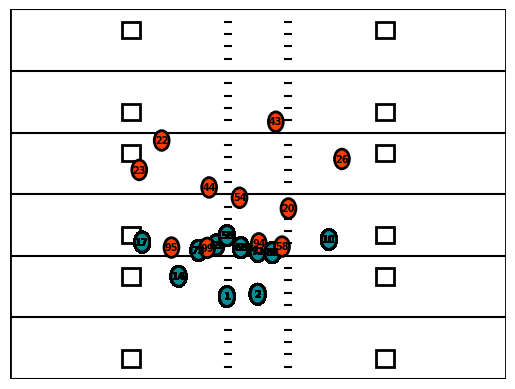

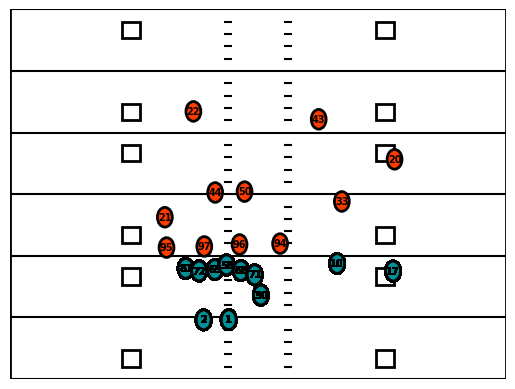

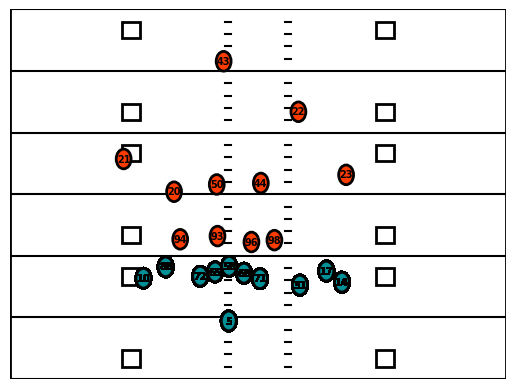

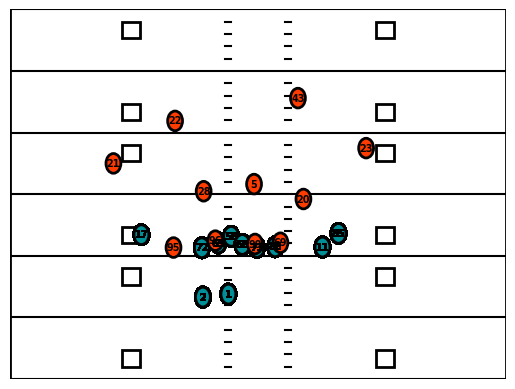

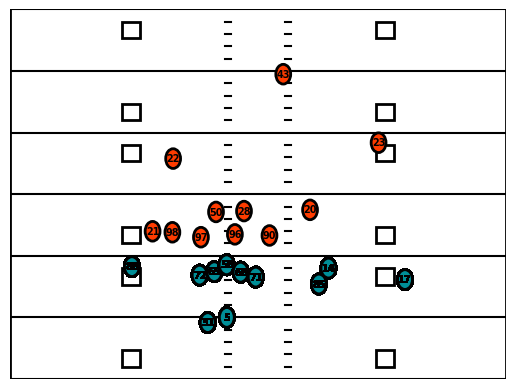

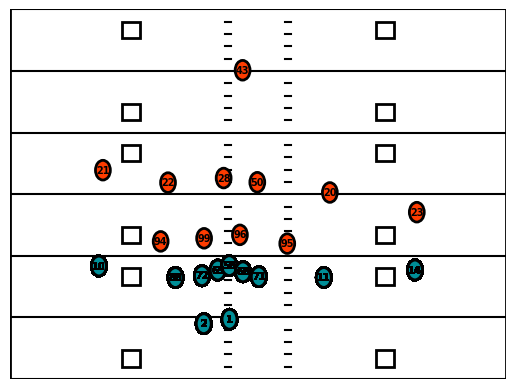

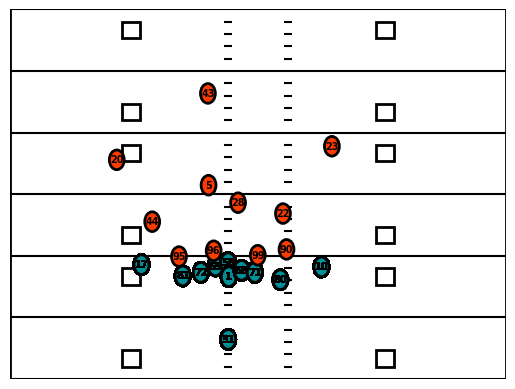

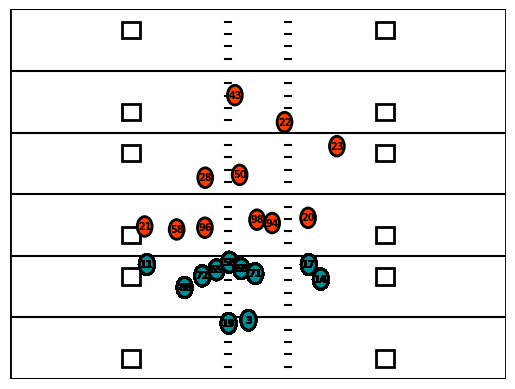

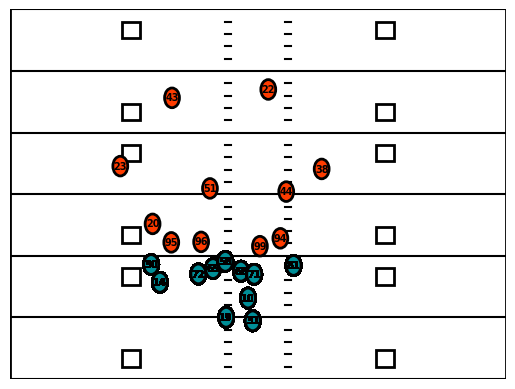

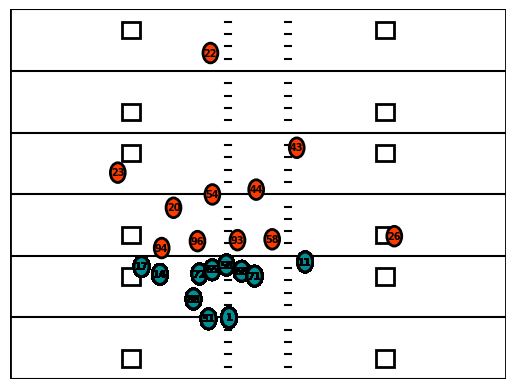

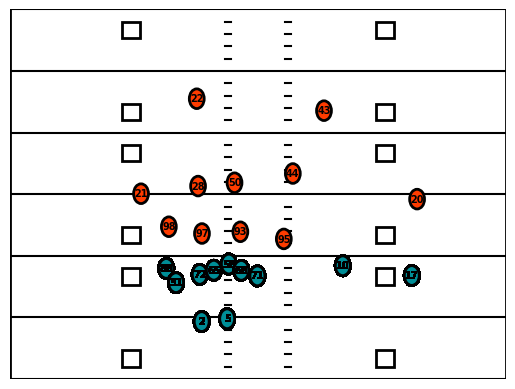

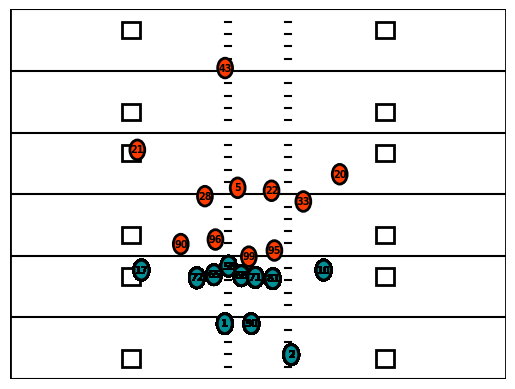

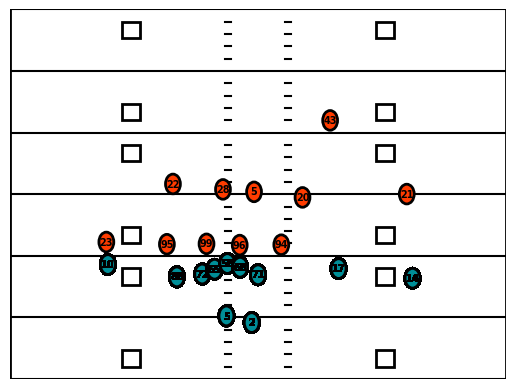

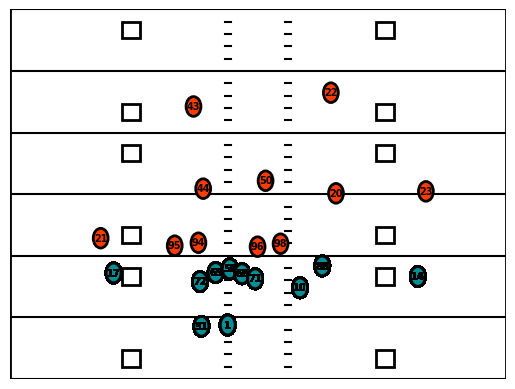

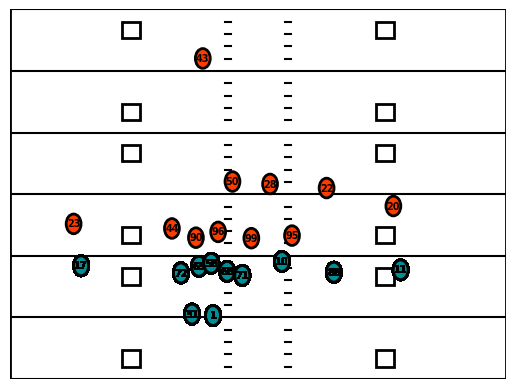

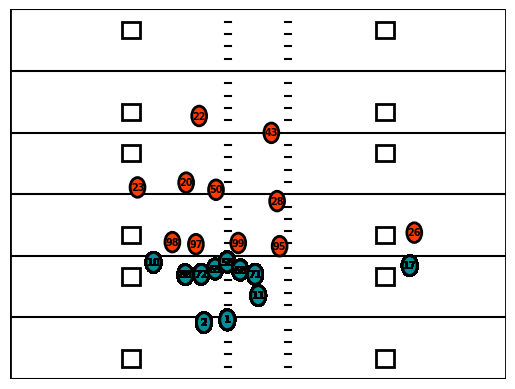

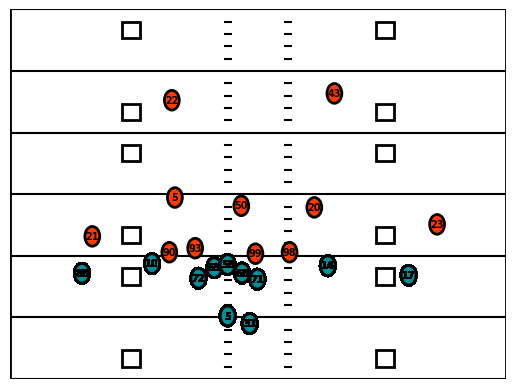

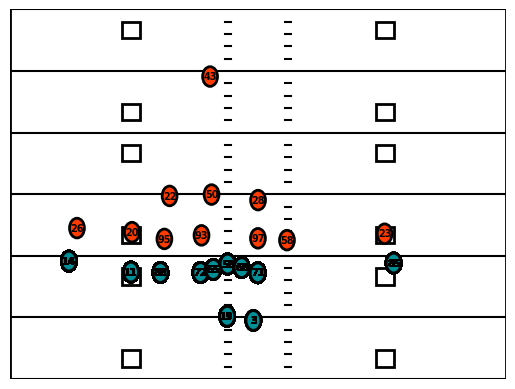

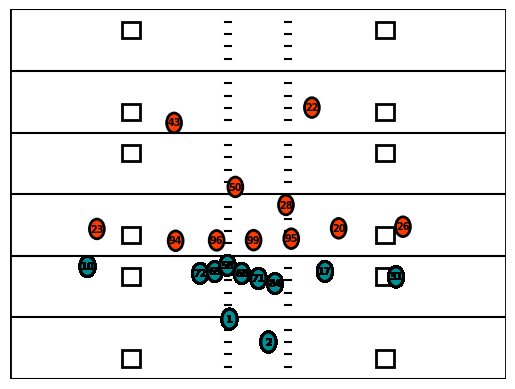

In [370]:
#5 best
var = 'Mean'
ofdf = pd.DataFrame(offensive_formations)
ofdf = ofdf.sort_values(by = 'Mean', ascending=False).reset_index(drop=True)
for hdx, h in enumerate(ofdf_mean['O_Label']):
    offensive_play = list(predicted_plays.loc[(predicted_plays['O_Label'] == h)]['PlayIdO'].drop_duplicates())[0]
    playlistD = list(predicted_plays.loc[(predicted_plays['O_Label'] == h)]['PlayIdD'].drop_duplicates())
    for idx, i in enumerate(playlistD):
        def_label = predicted_plays.loc[(predicted_plays['PlayIdD'] == i)]['D_Label'].iloc[0]
        snapo = predicted_plays.loc[(predicted_plays['PlayIdO'] == offensive_play) & (predicted_plays['PossessionTeam'] == offense) & (predicted_plays['IsOnOffense'] == True)].reset_index(drop=True)
        snapo = snapo.sort_values(by = 'Y').reset_index(drop=True)
        pos_pl = 0
        for jdx, j in enumerate(snapo['Position']):
            if (j in ['T', 'G', 'C']):
                if pos_pl == 0:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Terron Armstead')]['nflId'].iloc[0]
                elif pos_pl == 1:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Robert Jones')]['nflId'].iloc[0]
                elif pos_pl == 2:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Connor Williams')]['nflId'].iloc[0]
                elif pos_pl == 3:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Robert Hunt')]['nflId'].iloc[0]
                elif pos_pl == 4:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Brandon Shell')]['nflId'].iloc[0]
                pos_pl+=1
        snapo = pd.merge(snapo, player_number, how = 'left', on = 'NflId').reset_index(drop=True)
        snapd = predicted_plays.loc[(predicted_plays['PlayIdD'] == i) & (predicted_plays['DefensiveTeam'] == defense) & (predicted_plays['IsOnOffense'] == False)].reset_index(drop=True)
        snapd = pd.merge(snapd, player_number, how = 'left', left_on = ['PlayIdD', 'NflId'], right_on = ['PlayId', 'NflId']).reset_index(drop=True)
        snap = pd.concat([snapo, snapd]).reset_index(drop=True)
        snap = pd.merge(snap, player_space[['NflId', 'Space Factor Adj']], how = 'left', on = 'NflId').reset_index(drop=True)
        
        
        field_width = 53.33  # NFL field width
        field_length = 120  # View range: -20 to 20
        hashmark_to_sideline = 23.42  # NFL official hash mark distance from sideline
        hashmark_width = .67  # hashmark length
        number_to_sideline = 12  # NFL official hash mark distance from sideline
        number_width = 2  # hashmark length
    
        fig, ax = bdb.plt.subplots()
    
        overlay_image = ppdict[i][:, :, 3]
        overlay_image = np.rot90(overlay_image)
        overlay_image = np.flip(overlay_image, axis=1)
        
        custom_cmap = ListedColormap(["#311D00", "mediumseagreen", "#FC4C02"])
        x_min, x_max, y_min, y_max = -field_width/2, field_width/2, -field_length/2, field_length/2
        #ax.imshow(overlay_image, cmap=custom_cmap, extent=[x_min, x_max, y_min, y_max], zorder = 5)
    
        # Main field (excluding end zones)
        ax.add_patch(bdb.patches.Rectangle(
            (-field_width/2, -field_length/2), field_width, field_length,
            linewidth=2, edgecolor='black', facecolor='none', zorder=9))
        
        for idx, row in snap.iterrows():
            x_draw = row['X'] - (field_length / 2)# - 50
            y_draw = row['Y'] - (field_width / 2)
            #y_draw_d = 53.33 - row['Y'] - (field_width / 2)
            pos = row['Position']
            team = row['PossessionTeam']
            size = row['Space Factor Adj']
            jersey_number = int(row['JerseyNumber'])
            if team == offense:
                ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .8, facecolor='#008E97', edgecolor='black', lw=2)).set_zorder(10)
                ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=7, zorder=11, weight='bold')
            else:
                ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .8, facecolor='#FF3C00', edgecolor='black', lw=2)).set_zorder(10)
                ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=7, zorder=11, weight='bold')

        for yard in range(int((-field_length/2)), int((field_length/2)), 1):
            linestyle = '-' #if yard % 10 == 0 else '--'
            y_position = yard
            if yard % 5 == 0:
                ax.plot([-field_width/2, field_width/2], [y_position, y_position], color='black', linestyle=linestyle, zorder=9)
            else:
                ax.plot([-field_width/2 + hashmark_to_sideline - hashmark_width/2, -field_width/2 + hashmark_to_sideline + hashmark_width/2], [y_position, y_position], color='black', linestyle=linestyle, zorder=9)
                ax.plot([field_width/2 - hashmark_to_sideline + hashmark_width/2, field_width/2 - hashmark_to_sideline - hashmark_width/2], [y_position, y_position], color='black', linestyle=linestyle, zorder=9)
    
            number_offset = number_width / 2  # Half the height of the number box
    
            if (yard % 10 == 0) & (yard != int(-field_length/2)) & (yard != int((field_length/2))):
                # Left numbers
                ax.add_patch(bdb.patches.Rectangle(
                    (-field_width/2 + number_to_sideline, y_position + number_offset), number_width, number_width/1.5,
                    linewidth=2, edgecolor='black', facecolor='None', label="End Zone", zorder=9))
                ax.add_patch(bdb.patches.Rectangle(
                    (-field_width/2 + number_to_sideline, y_position - number_offset - number_width/1.5), number_width, number_width/1.5,
                    linewidth=2, edgecolor='black', facecolor='None', label="End Zone", zorder=9))
                
                # Right numbers
                ax.add_patch(bdb.patches.Rectangle(
                    (field_width/2 - number_to_sideline - number_width, y_position + number_offset), number_width, number_width/1.5,
                    linewidth=2, edgecolor='black', facecolor='None', label="End Zone", zorder=9))
                ax.add_patch(bdb.patches.Rectangle(
                    (field_width/2 - number_to_sideline - number_width, y_position - number_offset - number_width/1.5), number_width, number_width/1.5,
                    linewidth=2, edgecolor='black', facecolor='None', label="End Zone", zorder=9))
    
        ax.set_xlim(-field_width/2, field_width/2)
        ax.set_ylim(-field_length/2, field_length/2)
        bdb.plt.gca().set_facecolor('green')
        bdb.plt.axis('off')
        #bdb.plt.title(str(i))
        bdb.plt.ylim(-10, 20) 
        bdb.plt.savefig(prefix + '/testfig/drawing/testfig-O' + str(h) + '-D' + str(def_label) + '-' + str(i)+  '.jpg', bbox_inches="tight", pad_inches = 0, dpi = 600)
        bdb.plt.show()